Code to train a Segformer Model using Copernicus Data (10m resolution)
https://browser.dataspace.copernicus.eu/?zoom=5&lat=50.16282&lng=20.78613&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fsh.dataspace.copernicus.eu%2Fogc%2Fwms%2Fa91f72b5-f393-4320-bc0f-990129bd9e63&datasetId=S2_L2A_CDAS&demSource3D=%22MAPZEN%22&cloudCoverage=30&dateMode=SINGLE 

Uses 6 channels : RGB NIR and 2 calculated channels Near distance vegetation index and Near distance water index 

iou (1 class): 0.22
iou (0 class): 0.93
miou: 0.57

In [69]:
import numpy as np
import pickle
import itertools
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision import transforms
from SegDataset import SegmentationDataset
import geopandas as gpd
from einops import rearrange
from transformers import AdamW, SegformerForSemanticSegmentation, SegformerConfig
import matplotlib.pyplot as plt
import random
import rasterio

import torch
from rasterio.mask import mask
from torch.utils.data import DataLoader
from torch import nn
from rasterio.warp import reproject, Resampling
import numpy as np
from rasterio.plot import show

In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Config

In [71]:
DATASET_DIRECTORY = "ml-mangrove-data/"
PRETRAINED_MODEL_NAME = "nvidia/mit-b5"
#PRETRAINED_MODEL_NAME = "segformer-b5-finetuned-mangrove-128-128-15p" #alternative pretrained_model_name = "nvidia/mit-b0"
#PRETRAINED_MODEL_NAME ="./segformer-b3-finetuned-mangrove-128-128-15p/" 


DEVICE = "cuda" if torch.cuda.is_available() else "cpu" #device to be used for training and evaluation
PIN_MEMORY = True if DEVICE == "cuda" else False #if we will be pinning memory during data loading

INPUT_IMAGE_WIDTH = 64 #or 256
INPUT_IMAGE_HEIGHT = 64
NUM_CHANNELS = 6
NUM_CLASSES = 1

TEST_SPLIT = 0.10
PERCENT_NOMANGROVE_TILE_KEEP = 0.15 #percent of empty mangrove tiles to keep
BATCH_SIZE = 8
INIT_LR = 0.00006 #0.0001 
# LOSS_FUNCTION = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.0, 1.0]))
NUM_EPOCHS = 100
TEST_EVAL_EVERY_BATCH = 1 #how frequently to compute/save/display test accuracy, must be non-zero positive

EARLY_STOPPER_PATIENCE = 3 #how many epochs of lower test set accuracy before early stopping (also dependent on delta)
EARLY_STOPPER_DELTA = 0 #how much test set accuracy needs to drop before early stopping (also dependent on patience)

Read Files

In [72]:
# Function to align and mask src2 to src1's bounds, filling missing values with 0
def align_and_mask(src1, src2, fill_value=0):
    # Initialize an empty numpy array with the shape of src1 and the number of bands in src2
    destination = np.zeros((src2.count, src1.height, src1.width))

    # Reproject each band of src2 to align with src1
    for i in range(1, src2.count + 1):
        reproject(
            source=rasterio.band(src2, i),
            destination=destination[i-1],
            src_transform=src2.transform,
            src_crs=src2.crs,
            dst_transform=src1.transform,
            dst_crs=src1.crs,
            resampling=Resampling.nearest,
            fill_value=fill_value
        )

    return destination

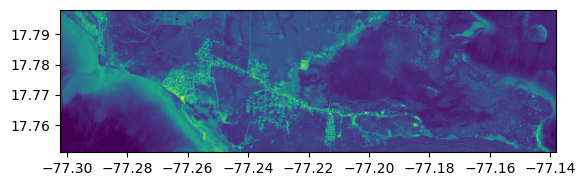

Source shape: (550, 1827)


In [73]:
# Open the first dataset and perform operations inside the context manager
with rasterio.open('image_train/TC.tiff') as src:
    # Show the first TIFF while it's open
    tiff_data = src.read()
    show(src)
    # Print source shape while the file is open
    print("Source shape:", src.shape)
    # Open the second dataset and perform alignment inside the context manager of the first dataset
    with rasterio.open('DEM_30m.tif') as src2:
        ele_data = align_and_mask(src, src2)

labels = gpd.read_file('ml-mangrove-data2/resizeLabel.shp')


Data Preprocessing

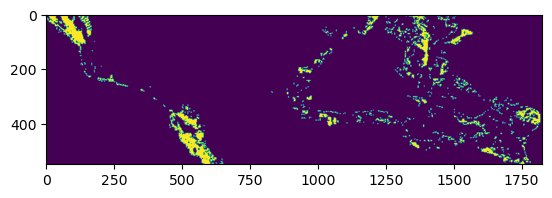

(550, 1827)


In [74]:
import rasterio.features

# Create an empty mask with the same dimensions as the TIFF file
mask = np.zeros(tiff_data.shape[1:], dtype=np.uint8)

# Rasterize the shapes onto the mask
for geom, value in zip(labels.geometry, np.ones(len(labels))):
    rasterized = rasterio.features.rasterize(
        [(geom, value)],
        out_shape=mask.shape,
        transform=src.transform,
        fill=0,
        all_touched=True,
        dtype=np.uint8
    )
    mask = np.maximum(mask, rasterized)
show(mask)
print(mask.shape)

In [75]:
#Concatenate all channels to create one numpy array of values to represent the image 

with rasterio.open('image_train/2.tiff') as src: #blue
    bimg = src.read()
with rasterio.open('image_train/3.tiff') as src: #green
    gimg = src.read()
with rasterio.open('image_train/4.tiff') as src: #red
    rimg = src.read()
with rasterio.open('image_train/8.tiff') as src: #nearIR
    irimg = src.read()

#Vegetation Index
ndvi = np.divide(irimg - rimg, irimg + rimg, where=(irimg + rimg != 0), dtype=np.float64)

#Water Index
ndwi = np.divide(gimg-irimg, gimg+irimg, where=(gimg+irimg != 0), dtype=np.float64)

#Custom Index
rimg_squeezed = np.squeeze(rimg, axis=0)
gimg_squeezed = np.squeeze(gimg, axis=0)
bimg_squeezed = np.squeeze(bimg, axis=0)
irimg_squeezed = np.squeeze(irimg, axis=0)
ndvi_squeezed = np.squeeze(ndvi, axis=0)
ndwi_squeezed = np.squeeze(ndwi, axis=0)
ele_squeezed = np.squeeze(ele_data, axis=0)

print(ele_squeezed.shape)
sat_img = np.stack((rimg_squeezed, gimg_squeezed, bimg_squeezed, irimg_squeezed, ndvi_squeezed, ndwi_squeezed), axis=0)

#full_img = full_img.unsqueeze(0)  # Add batch dimension
print(rimg.shape)
print(sat_img.shape)
print(mask.shape)


(550, 1827)
(1, 550, 1827)
(6, 550, 1827)
(550, 1827)


In [76]:
#Chunk the large image into smaller 64x64 images and fill in edges with 0 

def pad_and_split(arr, target_height=64, target_width=64):
    if arr.ndim == 2:  # For single-channel images (like masks)
        arr = np.expand_dims(arr, axis=0)  # Add a channel dimension

    channels, height, width = arr.shape

    # Calculate the padding
    pad_height = (target_height - height % target_height) % target_height
    pad_width = (target_width - width % target_width) % target_width

    # Pad the array
    padded_arr = np.pad(arr, ((0, 0), (0, pad_height), (0, pad_width)), mode='constant')

    # Calculate the number of splits
    num_vertical_splits = (height + pad_height) // target_height
    num_horizontal_splits = (width + pad_width) // target_width

    # Split the array and store the chunks
    split_arrays = []
    for i in range(num_vertical_splits):
        for j in range(num_horizontal_splits):
            chunk = padded_arr[:, i*target_height:(i+1)*target_height, j*target_width:(j+1)*target_width]
            split_arrays.append(chunk)

    # Reshape the list of chunks into a 4D numpy array
    split_arrays = np.array(split_arrays)
    split_arrays = np.moveaxis(split_arrays, 1, -1)  # Move channels to the last dimension

    return split_arrays

In [77]:
print(sat_img.shape)
print(mask.shape)
sat_images = pad_and_split(sat_img)
sat_labels = pad_and_split(mask)
sat_labels = np.squeeze(sat_labels, axis=-1)
sat_images = np.transpose(sat_images, (0, 3, 1, 2))
print(sat_images.shape)
print(sat_labels.shape)


(6, 550, 1827)
(550, 1827)
(261, 6, 64, 64)
(261, 64, 64)


In [78]:
# images = np.concatenate((images[:750], images[1000:]), axis=0)
# labels = np.concatenate((labels[:750], labels[1000:]), axis=0)

#systemic undersampling of 0 class
mask_sums = sat_labels.sum(axis=(1, 2))
non_empty_indices = mask_sums > 0

non_empty_indices_ls = non_empty_indices.tolist()
non_empty_indices = []
for element in non_empty_indices_ls:
    if element == False:
        if random.random() < PERCENT_NOMANGROVE_TILE_KEEP:
            non_empty_indices.append(True)
        else:
            non_empty_indices.append(False)
    else:
          non_empty_indices.append(True)

sat_images = sat_images[non_empty_indices]
sat_labels = sat_labels[non_empty_indices]

trainImages, testImages, trainMasks, testMasks = train_test_split(sat_images, sat_labels,
                         test_size=TEST_SPLIT, random_state=42)
# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize((INPUT_IMAGE_HEIGHT,
                                                    INPUT_IMAGE_WIDTH)),
                                 transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(images=trainImages, labels=trainMasks, transforms = transforms)
                              #transforms=transforms)
testDS = SegmentationDataset(images=testImages, labels=testMasks, transforms = transforms)
                             #transforms=transforms)
# testwithheldDS = SegmentationDataset(images=images[750:1000], labels=labels[750:1000], transforms = transforms)
#                              #transforms=transforms)

print(f"found {len(trainDS)} examples in the training set.")
print(f"found {len(testDS)} examples in the test set.")

# create the training and test data loaders #config
trainLoader = DataLoader(trainDS, shuffle=True,
                         batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                         num_workers=0) #os.cpu_count()
testLoader = DataLoader(testDS, shuffle=False,
                        batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                        num_workers=0) #os.cpu_count()

found 118 examples in the training set.
found 14 examples in the test set.


In [79]:
# assign the human-readable labels to encoding, encoding to human-readable labels
id2label = {
    0: "nomangrove",
    1: "mangrove"
}

label2id = {
    "nomangrove": 0,
    "mangrove": 1
}

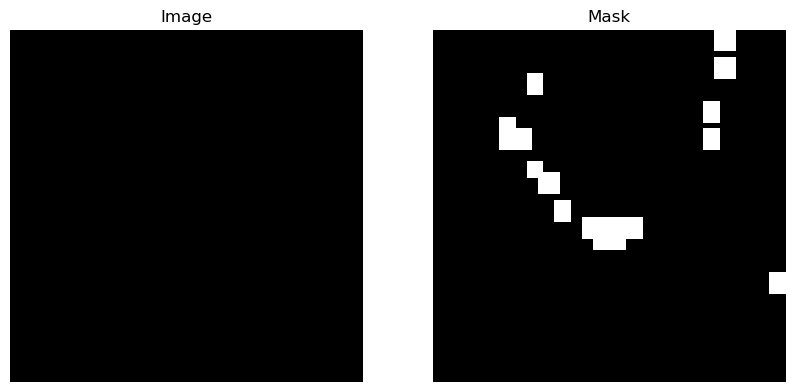

In [80]:
#Displays a random image chunk and corresponding labels for testing purposes 

def show_random_image_mask(image_set, mask_set):
    # Generate a random index based on the length of the image dataset
    idx = np.random.randint(0, len(image_set))
    
    # Fetch the image and mask using the random index
    image = image_set[idx]
    mask = mask_set[idx]
    
    # Check if the image and mask are in tensor format and convert them to numpy arrays for visualization
    if torch.is_tensor(image):
        image = image.numpy()
    if torch.is_tensor(mask):
        mask = mask.numpy()
    
    # Ensure the image and mask are in [H, W, C] format for displaying
    image = image[:3, :, :].astype(np.uint8)
    if image.shape[0] == 3:  # If channel-first format, convert to channel-last
        image = np.transpose(image, (1, 2, 0))
    
    # Plotting the image and mask side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Image')
    ax1.axis('off')
    
    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Mask')
    ax2.axis('off')
    
    plt.show()

# Call the function to display a random image and its corresponding mask
show_random_image_mask(trainImages, trainMasks)


Initialize Model

In [81]:
# config = SegformerConfig.from_pretrained(PRETRAINED_MODEL_NAME)
# config.id2label = id2label
# config.label2id = label2id

# Load the pretrained model
model = SegformerForSemanticSegmentation.from_pretrained(
    PRETRAINED_MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    num_labels = 2,
    num_channels = 6
)

# Modify the first layer to match the number of channels in data
# modified_layer = nn.Conv2d(NUM_CHANNELS, 64, kernel_size=7, stride=4, padding=3)
# model.segformer.encoder.patch_embeddings[0].proj = modified_layer

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized because the shapes did not m

In [82]:
print(model)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(6, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

Helper Classes

In [83]:
batch = next(iter(trainLoader))
test_batch = itertools.cycle(testLoader)
# val_batch = itertools.cycle(testwithheldLoader)

In [84]:
optimizer = AdamW(model.parameters(), lr=INIT_LR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

Model Initialized!


/home/jyang/miniconda3/envs/ML/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [85]:
class Early_stopper: #early stopper class 
    def __init__(self):
        self.patience = EARLY_STOPPER_PATIENCE
        self.delta = EARLY_STOPPER_DELTA
        self.patience_counter = 0
        self.min_test_loss = np.inf
    def check_stop(self, test_loss):
        if self.min_test_loss > test_loss:
            self.patience_counter = 0
            self.min_test_loss = test_loss
        elif test_loss > (self.min_test_loss + self.delta):
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                return True
        return False

In [86]:
class Total_updater:
  def __init__(self):
    self.test_epoch = [] 
    self.test_acc = [] 
    self.test_avr_acc = [] 
    self.test_loss = [] 
    self.test_avr_loss = [] 
    self.test_avr_acc_epoch = []
    self.test_avr_loss_epoch = []
    self.tests_count = 0 
    self.tests_epoch_count = 0 

    self.train_epoch = []
    self.train_acc = []
    self.train_avr_acc = []
    self.train_loss = []
    self.train_avr_loss = []
    self.train_avr_acc_epoch = []
    self.train_avr_loss_epoch = []
    self.trains_count = 0
    self.trains_epoch_count = 0


    self.epoch_test_acc_cum = 0 #use
    self.total_test_acc_cum = 0 #use
    self.epoch_test_loss_cum = 0 #use
    self.total_test_loss_cum = 0 #use

    self.epoch_train_acc_cum = 0
    self.total_train_acc_cum = 0
    self.epoch_train_loss_cum = 0
    self.total_train_loss_cum = 0

    self.epoch = 0
  def update_test(self, acc, loss):
    self.tests_count += 1
    self.tests_epoch_count += 1
    self.test_epoch.append(self.epoch + TEST_EVAL_EVERY_BATCH * self.tests_epoch_count/(len(trainDS) // BATCH_SIZE + 1 ))#self.epoch + (self.tests_epoch_count-1)/self.tests_epoch_count)

    self.test_acc.append(acc)
    self.test_acc.append(loss)

    self.epoch_test_acc_cum += acc
    self.total_test_acc_cum += acc
    self.epoch_test_loss_cum += loss
    self.total_test_loss_cum += loss

    self.test_avr_acc.append(self.total_test_acc_cum/self.tests_count)
    self.test_avr_loss.append(self.total_test_loss_cum/self.tests_count)

  def update_train(self, acc, loss):
    self.trains_count += 1
    self.trains_epoch_count += 1
    self.train_epoch.append(self.epoch + self.trains_epoch_count/(len(trainDS) // BATCH_SIZE + 1 )) #(self.epoch + (self.trains_epoch_count-1)/self.trains_epoch_count)

    self.train_acc.append(acc)
    self.train_acc.append(loss)

    self.epoch_train_acc_cum += acc
    self.total_train_acc_cum += acc
    self.epoch_train_loss_cum += loss
    self.total_train_loss_cum += loss

    self.train_avr_acc.append(self.total_train_acc_cum/self.trains_count)
    self.train_avr_loss.append(self.total_train_loss_cum/self.trains_count)


  def reset_epoch(self):
    self.test_avr_acc_epoch.append(self.epoch_test_acc_cum/self.tests_epoch_count)
    self.test_avr_loss_epoch.append(self.epoch_test_loss_cum/self.tests_epoch_count)

    self.train_avr_acc_epoch.append(self.epoch_train_acc_cum/self.trains_epoch_count)
    self.train_avr_loss_epoch.append(self.epoch_train_loss_cum/self.trains_epoch_count)
    
    print(f"EPOCH {self.epoch} Avr Test Accuracy: {self.test_avr_acc_epoch[self.epoch]}\
         Avr Test Loss: {self.test_avr_loss_epoch[self.epoch]}\
         Avr Train Accuracy: {self.train_avr_acc_epoch[self.epoch]}\
         Avr Train Loss: {self.train_avr_loss_epoch[self.epoch]}")
    
    
    self.epoch_test_acc_cum = 0
    self.epoch_test_loss_cum = 0
    self.epoch_train_acc_cum = 0
    self.epoch_train_loss_cum = 0

    self.tests_epoch_count = 0
    self.trains_epoch_count = 0

    self.epoch += 1



In [87]:
early_stopper = Early_stopper()
total_updater = Total_updater()

Train

In [88]:
for epoch in range(NUM_EPOCHS):
    print("Epoch:", epoch)
    pbar = tqdm(trainLoader)
    model.train()
    
    total_train_set = []
    for idx, batch in enumerate(pbar):
        batch_index = idx

        # get the inputs
        pixel_values = batch[0].float().to(device)
        labels = batch[1].long().to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)

        #train set eval
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)
        mask = (labels != -1) # don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        intersection = np.logical_and(pred_labels, true_labels)
        union = np.logical_or(pred_labels, true_labels)
        accuracy = np.sum(intersection) / np.sum(union)
        loss = outputs.loss

        # probabilities = torch.sigmoid(upsampled_logits)
        # logits_flat = upsampled_logits.reshape(-1, 2)  # Reshape logits to [batch_size * height * width, num_classes]
        # labels_one_hot = nn.functional.one_hot(labels.view(-1), num_classes=2)
        # loss_fn = nn.BCEWithLogitsLoss().cuda()
        # loss = loss_fn(logits_flat, labels_one_hot.float())

        total_updater.update_train(accuracy, loss.item())
        pbar.set_postfix({'Batch': idx, 'Batch Train Accuracy': accuracy, 'Train Loss': loss.item()})

        #test set eval
        if idx//TEST_EVAL_EVERY_BATCH == idx/TEST_EVAL_EVERY_BATCH:
            model.eval()
            with torch.no_grad():
                next_test_batch = next(test_batch)
                test_pixel_values = next_test_batch[0].float().to(device)
                test_labels = next_test_batch[1].long().to(device)
                test_outputs = model(pixel_values=test_pixel_values, labels=test_labels)
                test_upsampled_logits = nn.functional.interpolate(test_outputs.logits, size=test_labels.shape[-2:], mode="bilinear", align_corners=False)
                test_predicted = test_upsampled_logits.argmax(dim=1)
                test_mask = (test_labels != -1) # don't include the background class in the accuracy calculation
                test_pred_labels = test_predicted[test_mask].detach().cpu().numpy()
                test_true_labels = test_labels[test_mask].detach().cpu().numpy()
                print(np.sum(test_pred_labels))
                print(np.sum(test_true_labels))
                intersection = np.logical_and(test_pred_labels, test_true_labels)
                union = np.logical_or(test_pred_labels, test_true_labels)
                test_accuracy = np.sum(intersection) / np.sum(union)
                test_loss = test_outputs.loss

                total_updater.update_test(test_accuracy, test_loss.item())
                
                print(f'Batch Test Accuracy: {test_accuracy}, Test Loss: {test_loss.item()}')
                model.train()


        # backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         

    total_updater.reset_epoch()

    #early stopping
    test_loss_epoch = total_updater.test_avr_loss_epoch[total_updater.epoch-1]
    # if early_stopper.check_stop(test_loss_epoch):             
    #     break

Epoch: 0


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.0429, Train Loss=0.614]

21466
1208
Batch Test Accuracy: 0.025184247411493423, Test Loss: 0.7114495635032654


  7%|▋         | 1/15 [00:02<00:27,  1.94s/it, Batch=1, Batch Train Accuracy=0.103, Train Loss=0.573] 

1094
2944
Batch Test Accuracy: 0.10177353342428376, Test Loss: 0.6389630436897278


 13%|█▎        | 2/15 [00:04<00:24,  1.92s/it, Batch=2, Batch Train Accuracy=0.0766, Train Loss=0.56]

1556
1208
Batch Test Accuracy: 0.0, Test Loss: 0.6494296789169312


 20%|██        | 3/15 [00:06<00:23,  1.92s/it, Batch=3, Batch Train Accuracy=0.081, Train Loss=0.57] 

2629
2944
Batch Test Accuracy: 0.3119114877589454, Test Loss: 0.6464745998382568


 27%|██▋       | 4/15 [00:07<00:20,  1.90s/it, Batch=4, Batch Train Accuracy=0.107, Train Loss=0.521]

3166
1208
Batch Test Accuracy: 0.04242135367016206, Test Loss: 0.6110610365867615


 33%|███▎      | 5/15 [00:09<00:19,  1.90s/it, Batch=5, Batch Train Accuracy=0.0549, Train Loss=0.566]

3062
2944
Batch Test Accuracy: 0.07827648114901256, Test Loss: 0.6168583035469055


 40%|████      | 6/15 [00:11<00:17,  1.91s/it, Batch=6, Batch Train Accuracy=0.0727, Train Loss=0.52] 

767
1208
Batch Test Accuracy: 0.06699081577525662, Test Loss: 0.5855339765548706


 47%|████▋     | 7/15 [00:13<00:15,  1.94s/it, Batch=7, Batch Train Accuracy=0.0459, Train Loss=0.487]

1288
2944
Batch Test Accuracy: 0.0787662503186337, Test Loss: 0.6190500855445862


 53%|█████▎    | 8/15 [00:15<00:13,  1.93s/it, Batch=8, Batch Train Accuracy=0.023, Train Loss=0.487] 

170
1208
Batch Test Accuracy: 0.005105762217359592, Test Loss: 0.548933207988739


 60%|██████    | 9/15 [00:17<00:11,  1.93s/it, Batch=9, Batch Train Accuracy=0.114, Train Loss=0.451]

888
2944
Batch Test Accuracy: 0.06860011154489683, Test Loss: 0.5661660432815552


 67%|██████▋   | 10/15 [00:19<00:09,  1.92s/it, Batch=10, Batch Train Accuracy=0.191, Train Loss=0.492]

13
1208
Batch Test Accuracy: 0.0, Test Loss: 0.46134716272354126


 73%|███████▎  | 11/15 [00:21<00:07,  1.92s/it, Batch=11, Batch Train Accuracy=0.111, Train Loss=0.435]

73
2944
Batch Test Accuracy: 0.0, Test Loss: 0.5045432448387146


 80%|████████  | 12/15 [00:23<00:05,  1.92s/it, Batch=12, Batch Train Accuracy=0.124, Train Loss=0.415]

9
1208
Batch Test Accuracy: 0.0, Test Loss: 0.38922378420829773


 87%|████████▋ | 13/15 [00:25<00:03,  1.93s/it, Batch=13, Batch Train Accuracy=0.17, Train Loss=0.381] 

91
2944
Batch Test Accuracy: 0.0, Test Loss: 0.4660724699497223


 93%|█████████▎| 14/15 [00:27<00:01,  1.92s/it, Batch=14, Batch Train Accuracy=0.00949, Train Loss=0.402]

23
1208
Batch Test Accuracy: 0.0, Test Loss: 0.38757047057151794


100%|██████████| 15/15 [00:28<00:00,  1.90s/it, Batch=14, Batch Train Accuracy=0.00949, Train Loss=0.402]


EPOCH 0 Avr Test Accuracy: 0.05193533621800293         Avr Test Loss: 0.5601784447828929         Avr Train Accuracy: 0.0883801435146033         Avr Train Loss: 0.498286110162735
Epoch: 1


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.0866, Train Loss=0.369]

121
2944
Batch Test Accuracy: 0.0, Test Loss: 0.46844246983528137


  7%|▋         | 1/15 [00:02<00:26,  1.90s/it, Batch=1, Batch Train Accuracy=0.0199, Train Loss=0.439]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.37360939383506775


 13%|█▎        | 2/15 [00:04<00:24,  1.90s/it, Batch=2, Batch Train Accuracy=0.0495, Train Loss=0.399]

51
2944
Batch Test Accuracy: 0.0, Test Loss: 0.44003161787986755


 20%|██        | 3/15 [00:05<00:22,  1.87s/it, Batch=3, Batch Train Accuracy=0.0266, Train Loss=0.407]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.31761398911476135


 27%|██▋       | 4/15 [00:07<00:21,  1.92s/it, Batch=4, Batch Train Accuracy=0.0428, Train Loss=0.326]

12
2944
Batch Test Accuracy: 0.0, Test Loss: 0.4093111753463745


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.0736, Train Loss=0.367]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.28588852286338806


 40%|████      | 6/15 [00:11<00:17,  1.89s/it, Batch=6, Batch Train Accuracy=0.126, Train Loss=0.301] 

22
2944
Batch Test Accuracy: 0.0, Test Loss: 0.39837273955345154


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.0221, Train Loss=0.333]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.2818722426891327


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.0753, Train Loss=0.319]

223
2944
Batch Test Accuracy: 0.016041065126724416, Test Loss: 0.3924672603607178


 60%|██████    | 9/15 [00:17<00:11,  1.88s/it, Batch=9, Batch Train Accuracy=0.0829, Train Loss=0.385]

12
1208
Batch Test Accuracy: 0.0, Test Loss: 0.28096961975097656


 67%|██████▋   | 10/15 [00:19<00:09,  1.89s/it, Batch=10, Batch Train Accuracy=0.0739, Train Loss=0.29]

564
2944
Batch Test Accuracy: 0.035724830233244756, Test Loss: 0.39972949028015137


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.144, Train Loss=0.349]

78
1208
Batch Test Accuracy: 0.008627450980392156, Test Loss: 0.28306832909584045


 80%|████████  | 12/15 [00:22<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.0992, Train Loss=0.341]

666
2944
Batch Test Accuracy: 0.03349556255367878, Test Loss: 0.38403812050819397


 87%|████████▋ | 13/15 [00:24<00:03,  1.90s/it, Batch=13, Batch Train Accuracy=0.0591, Train Loss=0.286]

42
1208
Batch Test Accuracy: 0.0, Test Loss: 0.2341517060995102


 93%|█████████▎| 14/15 [00:26<00:01,  1.91s/it, Batch=14, Batch Train Accuracy=0.0473, Train Loss=0.351]

628
2944
Batch Test Accuracy: 0.06183115338882283, Test Loss: 0.3608841001987457


100%|██████████| 15/15 [00:28<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.0473, Train Loss=0.351]


EPOCH 1 Avr Test Accuracy: 0.010381337485524196         Avr Test Loss: 0.35403005182743075         Avr Train Accuracy: 0.06862534626423612         Avr Train Loss: 0.35074121952056886
Epoch: 2


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.00741, Train Loss=0.336]

116
1208
Batch Test Accuracy: 0.010687022900763359, Test Loss: 0.21665190160274506


  7%|▋         | 1/15 [00:02<00:26,  1.90s/it, Batch=1, Batch Train Accuracy=0.0955, Train Loss=0.33]  

940
2944
Batch Test Accuracy: 0.08734602463605823, Test Loss: 0.3510027229785919


 13%|█▎        | 2/15 [00:04<00:24,  1.88s/it, Batch=2, Batch Train Accuracy=0.0467, Train Loss=0.232]

143
1208
Batch Test Accuracy: 0.031297709923664124, Test Loss: 0.22873759269714355


 20%|██        | 3/15 [00:06<00:22,  1.91s/it, Batch=3, Batch Train Accuracy=0.153, Train Loss=0.272] 

1646
2944
Batch Test Accuracy: 0.17121714723143658, Test Loss: 0.3532392978668213


 27%|██▋       | 4/15 [00:07<00:21,  1.91s/it, Batch=4, Batch Train Accuracy=0.121, Train Loss=0.283]

112
1208
Batch Test Accuracy: 0.034482758620689655, Test Loss: 0.21453261375427246


 33%|███▎      | 5/15 [00:09<00:19,  1.93s/it, Batch=5, Batch Train Accuracy=0.0988, Train Loss=0.23]

1350
2944
Batch Test Accuracy: 0.1469017094017094, Test Loss: 0.33075475692749023


 40%|████      | 6/15 [00:11<00:17,  1.91s/it, Batch=6, Batch Train Accuracy=0.181, Train Loss=0.275]

73
1208
Batch Test Accuracy: 0.047424366312346686, Test Loss: 0.18947234749794006


 47%|████▋     | 7/15 [00:13<00:15,  1.92s/it, Batch=7, Batch Train Accuracy=0.258, Train Loss=0.274]

712
2944
Batch Test Accuracy: 0.060632434000580215, Test Loss: 0.30787572264671326


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.074, Train Loss=0.21] 

57
1208
Batch Test Accuracy: 0.045454545454545456, Test Loss: 0.17167885601520538


 60%|██████    | 9/15 [00:17<00:11,  1.89s/it, Batch=9, Batch Train Accuracy=0.32, Train Loss=0.295]

783
2944
Batch Test Accuracy: 0.07005455067470572, Test Loss: 0.30196693539619446


 67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it, Batch=10, Batch Train Accuracy=0.17, Train Loss=0.26]

40
1208
Batch Test Accuracy: 0.033112582781456956, Test Loss: 0.1640162616968155


 73%|███████▎  | 11/15 [00:21<00:07,  1.88s/it, Batch=11, Batch Train Accuracy=0.118, Train Loss=0.251]

990
2944
Batch Test Accuracy: 0.09888268156424582, Test Loss: 0.29527074098587036


 80%|████████  | 12/15 [00:22<00:05,  1.85s/it, Batch=12, Batch Train Accuracy=0.0896, Train Loss=0.338]

47
1208
Batch Test Accuracy: 0.02115541090317331, Test Loss: 0.15495838224887848


 87%|████████▋ | 13/15 [00:24<00:03,  1.83s/it, Batch=13, Batch Train Accuracy=0, Train Loss=0.346]     

930
2944
Batch Test Accuracy: 0.09126760563380282, Test Loss: 0.2891673743724823


 93%|█████████▎| 14/15 [00:26<00:01,  1.85s/it, Batch=14, Batch Train Accuracy=0.0525, Train Loss=0.253]

67
1208
Batch Test Accuracy: 0.012708498808578236, Test Loss: 0.14679117500782013


100%|██████████| 15/15 [00:27<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.0525, Train Loss=0.253]


EPOCH 2 Avr Test Accuracy: 0.0641750032565171         Avr Test Loss: 0.24774111211299896         Avr Train Accuracy: 0.11902927228343073         Avr Train Loss: 0.27908010383447013
Epoch: 3


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.0355, Train Loss=0.225]

862
2944
Batch Test Accuracy: 0.08525805531793555, Test Loss: 0.291500061750412


  7%|▋         | 1/15 [00:02<00:25,  1.83s/it, Batch=1, Batch Train Accuracy=0.126, Train Loss=0.278] 

44
1208
Batch Test Accuracy: 0.00967741935483871, Test Loss: 0.14455735683441162


 13%|█▎        | 2/15 [00:04<00:24,  1.89s/it, Batch=2, Batch Train Accuracy=0.0198, Train Loss=0.224]

845
2944
Batch Test Accuracy: 0.07948717948717948, Test Loss: 0.2918921411037445


 20%|██        | 3/15 [00:05<00:22,  1.90s/it, Batch=3, Batch Train Accuracy=0.188, Train Loss=0.218] 

27
1208
Batch Test Accuracy: 0.022350993377483443, Test Loss: 0.14943379163742065


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.118, Train Loss=0.287]

805
2944
Batch Test Accuracy: 0.07022552098201541, Test Loss: 0.2883114516735077


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.184, Train Loss=0.26] 

39
1208
Batch Test Accuracy: 0.02972749793559042, Test Loss: 0.15113474428653717


 40%|████      | 6/15 [00:11<00:17,  1.90s/it, Batch=6, Batch Train Accuracy=0.112, Train Loss=0.311]

963
2944
Batch Test Accuracy: 0.09716371805672563, Test Loss: 0.2890242040157318


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.00774, Train Loss=0.217]

74
1208
Batch Test Accuracy: 0.03889789303079417, Test Loss: 0.1568150520324707


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.226, Train Loss=0.28]   

1069
2944
Batch Test Accuracy: 0.12377485298235788, Test Loss: 0.28306815028190613


 60%|██████    | 9/15 [00:17<00:11,  1.90s/it, Batch=9, Batch Train Accuracy=0.201, Train Loss=0.243]

73
1208
Batch Test Accuracy: 0.044861337683523655, Test Loss: 0.14461128413677216


 67%|██████▋   | 10/15 [00:19<00:09,  1.92s/it, Batch=10, Batch Train Accuracy=0.311, Train Loss=0.336]

835
2944
Batch Test Accuracy: 0.08904899135446685, Test Loss: 0.27378273010253906


 73%|███████▎  | 11/15 [00:21<00:07,  1.90s/it, Batch=11, Batch Train Accuracy=0.197, Train Loss=0.196]

56
1208
Batch Test Accuracy: 0.038619556285949055, Test Loss: 0.13547971844673157


 80%|████████  | 12/15 [00:23<00:05,  1.91s/it, Batch=12, Batch Train Accuracy=0.348, Train Loss=0.23] 

1063
2944
Batch Test Accuracy: 0.12146655471592499, Test Loss: 0.2712075710296631


 87%|████████▋ | 13/15 [00:25<00:03,  1.93s/it, Batch=13, Batch Train Accuracy=0.318, Train Loss=0.227]

80
1208
Batch Test Accuracy: 0.0378726833199033, Test Loss: 0.13392741978168488


 93%|█████████▎| 14/15 [00:26<00:01,  1.93s/it, Batch=14, Batch Train Accuracy=0.196, Train Loss=0.203]

1076
2944
Batch Test Accuracy: 0.11049723756906077, Test Loss: 0.27401819825172424


100%|██████████| 15/15 [00:28<00:00,  1.88s/it, Batch=14, Batch Train Accuracy=0.196, Train Loss=0.203]


EPOCH 3 Avr Test Accuracy: 0.06659529943024996         Avr Test Loss: 0.21858425835768383         Avr Train Accuracy: 0.1725651169718815         Avr Train Loss: 0.24900843799114228
Epoch: 4


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.0554, Train Loss=0.185]

81
1208
Batch Test Accuracy: 0.03451043338683788, Test Loss: 0.13642914593219757


  7%|▋         | 1/15 [00:02<00:26,  1.91s/it, Batch=1, Batch Train Accuracy=0.152, Train Loss=0.306] 

1624
2944
Batch Test Accuracy: 0.19331243469174503, Test Loss: 0.2761707007884979


 13%|█▎        | 2/15 [00:04<00:24,  1.87s/it, Batch=2, Batch Train Accuracy=0.262, Train Loss=0.22] 

86
1208
Batch Test Accuracy: 0.03272146847565842, Test Loss: 0.1538998782634735


 20%|██        | 3/15 [00:05<00:22,  1.89s/it, Batch=3, Batch Train Accuracy=0.00146, Train Loss=0.225]

3363
2944
Batch Test Accuracy: 0.43308339013860486, Test Loss: 0.2936185300350189


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.108, Train Loss=0.239]  

152
1208
Batch Test Accuracy: 0.060842433697347896, Test Loss: 0.1641744077205658


 33%|███▎      | 5/15 [00:09<00:19,  1.91s/it, Batch=5, Batch Train Accuracy=0.338, Train Loss=0.193]

3308
2944
Batch Test Accuracy: 0.43625086147484493, Test Loss: 0.2929559051990509


 40%|████      | 6/15 [00:11<00:17,  1.92s/it, Batch=6, Batch Train Accuracy=0.193, Train Loss=0.246]

139
1208
Batch Test Accuracy: 0.0665083135391924, Test Loss: 0.15810616314411163


 47%|████▋     | 7/15 [00:13<00:15,  1.94s/it, Batch=7, Batch Train Accuracy=0.0401, Train Loss=0.188]

2549
2944
Batch Test Accuracy: 0.3899291497975709, Test Loss: 0.2746615707874298


 53%|█████▎    | 8/15 [00:15<00:13,  1.92s/it, Batch=8, Batch Train Accuracy=0.233, Train Loss=0.197] 

28
1208
Batch Test Accuracy: 0.015612161051766639, Test Loss: 0.13897547125816345


 60%|██████    | 9/15 [00:17<00:11,  1.91s/it, Batch=9, Batch Train Accuracy=0.47, Train Loss=0.217] 

1147
2944
Batch Test Accuracy: 0.16221590909090908, Test Loss: 0.2631721496582031


 67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it, Batch=10, Batch Train Accuracy=0.294, Train Loss=0.22]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.1295640766620636


 73%|███████▎  | 11/15 [00:21<00:07,  1.91s/it, Batch=11, Batch Train Accuracy=0.252, Train Loss=0.185]

616
2944
Batch Test Accuracy: 0.06015485407980941, Test Loss: 0.26897162199020386


 80%|████████  | 12/15 [00:23<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.282, Train Loss=0.31] 

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.12490501999855042


 87%|████████▋ | 13/15 [00:25<00:03,  1.90s/it, Batch=13, Batch Train Accuracy=0.174, Train Loss=0.313]

573
2944
Batch Test Accuracy: 0.06061519903498191, Test Loss: 0.28354933857917786


 93%|█████████▎| 14/15 [00:26<00:01,  1.90s/it, Batch=14, Batch Train Accuracy=0.0651, Train Loss=0.211]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.12346946448087692


100%|██████████| 15/15 [00:28<00:00,  1.89s/it, Batch=14, Batch Train Accuracy=0.0651, Train Loss=0.211]


EPOCH 4 Avr Test Accuracy: 0.12971710723061794         Avr Test Loss: 0.20550822963317236         Avr Train Accuracy: 0.19473839348914979         Avr Train Loss: 0.23019050260384877
Epoch: 5


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.0802, Train Loss=0.235]

835
2944
Batch Test Accuracy: 0.06751412429378531, Test Loss: 0.26628658175468445


  7%|▋         | 1/15 [00:02<00:26,  1.87s/it, Batch=1, Batch Train Accuracy=0.0291, Train Loss=0.232]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.12734702229499817


 13%|█▎        | 2/15 [00:04<00:24,  1.91s/it, Batch=2, Batch Train Accuracy=0.26, Train Loss=0.198]  

3141
2944
Batch Test Accuracy: 0.4213968698902126, Test Loss: 0.2761600911617279


 20%|██        | 3/15 [00:06<00:22,  1.91s/it, Batch=3, Batch Train Accuracy=0.503, Train Loss=0.181]

652
1208
Batch Test Accuracy: 0.11310592459605028, Test Loss: 0.16003607213497162


 27%|██▋       | 4/15 [00:07<00:21,  1.91s/it, Batch=4, Batch Train Accuracy=0.387, Train Loss=0.223]

3532
2944
Batch Test Accuracy: 0.4248624862486249, Test Loss: 0.3127942383289337


 33%|███▎      | 5/15 [00:09<00:19,  1.91s/it, Batch=5, Batch Train Accuracy=0.327, Train Loss=0.213]

690
1208
Batch Test Accuracy: 0.11124121779859485, Test Loss: 0.16161903738975525


 40%|████      | 6/15 [00:11<00:17,  1.93s/it, Batch=6, Batch Train Accuracy=0.38, Train Loss=0.282] 

2746
2944
Batch Test Accuracy: 0.3793939393939394, Test Loss: 0.2673535645008087


 47%|████▋     | 7/15 [00:13<00:15,  1.91s/it, Batch=7, Batch Train Accuracy=0.175, Train Loss=0.242]

4
1208
Batch Test Accuracy: 0.0033112582781456954, Test Loss: 0.12396285682916641


 53%|█████▎    | 8/15 [00:15<00:13,  1.92s/it, Batch=8, Batch Train Accuracy=0.172, Train Loss=0.185]

1087
2944
Batch Test Accuracy: 0.12003334259516532, Test Loss: 0.26009485125541687


 60%|██████    | 9/15 [00:17<00:11,  1.90s/it, Batch=9, Batch Train Accuracy=0.429, Train Loss=0.185]

2
1208
Batch Test Accuracy: 0.0016556291390728477, Test Loss: 0.1183219775557518


 67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it, Batch=10, Batch Train Accuracy=0.525, Train Loss=0.241]

765
2944
Batch Test Accuracy: 0.07976710334788938, Test Loss: 0.28364264965057373


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.355, Train Loss=0.165]

2
1208
Batch Test Accuracy: 0.0016556291390728477, Test Loss: 0.11965060234069824


 80%|████████  | 12/15 [00:23<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.235, Train Loss=0.235]

670
2944
Batch Test Accuracy: 0.06765140324963072, Test Loss: 0.2904425263404846


 87%|████████▋ | 13/15 [00:25<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.26, Train Loss=0.166] 

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.12111863493919373


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.0476, Train Loss=0.222]

512
2944
Batch Test Accuracy: 0.04568835098335855, Test Loss: 0.28406456112861633


100%|██████████| 15/15 [00:28<00:00,  1.88s/it, Batch=14, Batch Train Accuracy=0.0476, Train Loss=0.222]


EPOCH 5 Avr Test Accuracy: 0.12248515193023615         Avr Test Loss: 0.21152635117371876         Avr Train Accuracy: 0.2776797101926241         Avr Train Loss: 0.21359123984972636
Epoch: 6


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.561, Train Loss=0.203]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.12429891526699066


  7%|▋         | 1/15 [00:02<00:26,  1.92s/it, Batch=1, Batch Train Accuracy=0.204, Train Loss=0.25] 

369
2944
Batch Test Accuracy: 0.030482115085536547, Test Loss: 0.2746254801750183


 13%|█▎        | 2/15 [00:04<00:24,  1.92s/it, Batch=2, Batch Train Accuracy=0.156, Train Loss=0.316]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.1269560605287552


 20%|██        | 3/15 [00:06<00:22,  1.91s/it, Batch=3, Batch Train Accuracy=0.0678, Train Loss=0.155]

954
2944
Batch Test Accuracy: 0.0971010413734872, Test Loss: 0.26840800046920776


 27%|██▋       | 4/15 [00:07<00:20,  1.90s/it, Batch=4, Batch Train Accuracy=0.0553, Train Loss=0.195]

76
1208
Batch Test Accuracy: 0.04816326530612245, Test Loss: 0.13782814145088196


 33%|███▎      | 5/15 [00:09<00:19,  1.91s/it, Batch=5, Batch Train Accuracy=0.267, Train Loss=0.171] 

2649
2944
Batch Test Accuracy: 0.38956521739130434, Test Loss: 0.272272527217865


 40%|████      | 6/15 [00:11<00:16,  1.86s/it, Batch=6, Batch Train Accuracy=0.369, Train Loss=0.148]

194
1208
Batch Test Accuracy: 0.11535401750198886, Test Loss: 0.14321264624595642


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.502, Train Loss=0.172]

2972
2944
Batch Test Accuracy: 0.4018957345971564, Test Loss: 0.2727773189544678


 53%|█████▎    | 8/15 [00:15<00:13,  1.90s/it, Batch=8, Batch Train Accuracy=0.418, Train Loss=0.246]

332
1208
Batch Test Accuracy: 0.11594202898550725, Test Loss: 0.13761113584041595


 60%|██████    | 9/15 [00:17<00:11,  1.91s/it, Batch=9, Batch Train Accuracy=0.402, Train Loss=0.219]

2416
2944
Batch Test Accuracy: 0.33068520357497516, Test Loss: 0.2633947730064392


 67%|██████▋   | 10/15 [00:19<00:09,  1.91s/it, Batch=10, Batch Train Accuracy=0.42, Train Loss=0.231]

358
1208
Batch Test Accuracy: 0.10906515580736544, Test Loss: 0.13321718573570251


 73%|███████▎  | 11/15 [00:21<00:07,  1.93s/it, Batch=11, Batch Train Accuracy=0.324, Train Loss=0.23]

2516
2944
Batch Test Accuracy: 0.31788559015206375, Test Loss: 0.26618891954421997


 80%|████████  | 12/15 [00:23<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.412, Train Loss=0.149]

418
1208
Batch Test Accuracy: 0.10386965376782077, Test Loss: 0.13294494152069092


 87%|████████▋ | 13/15 [00:25<00:03,  1.90s/it, Batch=13, Batch Train Accuracy=0.273, Train Loss=0.167]

2680
2944
Batch Test Accuracy: 0.33459895586141436, Test Loss: 0.26833975315093994


 93%|█████████▎| 14/15 [00:26<00:01,  1.87s/it, Batch=14, Batch Train Accuracy=0.133, Train Loss=0.207]

167
1208
Batch Test Accuracy: 0.07003891050583658, Test Loss: 0.1262933760881424


100%|██████████| 15/15 [00:28<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.133, Train Loss=0.207]


EPOCH 6 Avr Test Accuracy: 0.16430979266070528         Avr Test Loss: 0.19655794501304627         Avr Train Accuracy: 0.3043739289387073         Avr Train Loss: 0.203968612353007
Epoch: 7


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.575, Train Loss=0.203]

1474
2944
Batch Test Accuracy: 0.2320133853876185, Test Loss: 0.24959324300289154


  7%|▋         | 1/15 [00:02<00:26,  1.89s/it, Batch=1, Batch Train Accuracy=0.0224, Train Loss=0.133]

14
1208
Batch Test Accuracy: 0.011589403973509934, Test Loss: 0.12085922062397003


 13%|█▎        | 2/15 [00:04<00:24,  1.91s/it, Batch=2, Batch Train Accuracy=0.198, Train Loss=0.139] 

644
2944
Batch Test Accuracy: 0.10946196660482375, Test Loss: 0.2535918056964874


 20%|██        | 3/15 [00:05<00:22,  1.88s/it, Batch=3, Batch Train Accuracy=0.353, Train Loss=0.217]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.1215812936425209


 27%|██▋       | 4/15 [00:07<00:20,  1.90s/it, Batch=4, Batch Train Accuracy=0.0893, Train Loss=0.277]

140
2944
Batch Test Accuracy: 0.009492635024549919, Test Loss: 0.2660239636898041


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.203, Train Loss=0.2]   

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.12341854721307755


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.429, Train Loss=0.176]

160
2944
Batch Test Accuracy: 0.014047696831100947, Test Loss: 0.26554226875305176


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.34, Train Loss=0.23]  

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.12232689559459686


 53%|█████▎    | 8/15 [00:15<00:13,  1.92s/it, Batch=8, Batch Train Accuracy=0.221, Train Loss=0.169]

330
2944
Batch Test Accuracy: 0.0547680412371134, Test Loss: 0.2538573443889618


 60%|██████    | 9/15 [00:17<00:11,  1.89s/it, Batch=9, Batch Train Accuracy=0.426, Train Loss=0.188]

8
1208
Batch Test Accuracy: 0.006622516556291391, Test Loss: 0.11944848299026489


 67%|██████▋   | 10/15 [00:19<00:09,  1.91s/it, Batch=10, Batch Train Accuracy=0.261, Train Loss=0.28]

1122
2944
Batch Test Accuracy: 0.23062953995157384, Test Loss: 0.24079729616641998


 73%|███████▎  | 11/15 [00:21<00:07,  1.88s/it, Batch=11, Batch Train Accuracy=0.279, Train Loss=0.115]

67
1208
Batch Test Accuracy: 0.051112943116240726, Test Loss: 0.11918548494577408


 80%|████████  | 12/15 [00:23<00:05,  1.91s/it, Batch=12, Batch Train Accuracy=0.274, Train Loss=0.208]

1975
2944
Batch Test Accuracy: 0.315944355270198, Test Loss: 0.23962028324604034


 87%|████████▋ | 13/15 [00:24<00:03,  1.90s/it, Batch=13, Batch Train Accuracy=0.556, Train Loss=0.183]

95
1208
Batch Test Accuracy: 0.06280587275693311, Test Loss: 0.1179693192243576


 93%|█████████▎| 14/15 [00:26<00:01,  1.90s/it, Batch=14, Batch Train Accuracy=0.389, Train Loss=0.167]

2138
2944
Batch Test Accuracy: 0.3097938144329897, Test Loss: 0.24066583812236786


100%|██████████| 15/15 [00:28<00:00,  1.88s/it, Batch=14, Batch Train Accuracy=0.389, Train Loss=0.167]


EPOCH 7 Avr Test Accuracy: 0.09388547807619621         Avr Test Loss: 0.19029875248670577         Avr Train Accuracy: 0.3076781138966684         Avr Train Loss: 0.19232290635506313
Epoch: 8


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.0772, Train Loss=0.139]

138
1208
Batch Test Accuracy: 0.07080350039777247, Test Loss: 0.11889830231666565


  7%|▋         | 1/15 [00:02<00:25,  1.85s/it, Batch=1, Batch Train Accuracy=0.32, Train Loss=0.122]  

1939
2944
Batch Test Accuracy: 0.2900924702774108, Test Loss: 0.23860013484954834


 13%|█▎        | 2/15 [00:04<00:24,  1.88s/it, Batch=2, Batch Train Accuracy=0.607, Train Loss=0.191]

23
1208
Batch Test Accuracy: 0.01903973509933775, Test Loss: 0.11894134432077408


 20%|██        | 3/15 [00:05<00:22,  1.86s/it, Batch=3, Batch Train Accuracy=0.147, Train Loss=0.155]

972
2944
Batch Test Accuracy: 0.16965352449223417, Test Loss: 0.24195025861263275


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.468, Train Loss=0.194]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.12199167162179947


 33%|███▎      | 5/15 [00:09<00:19,  1.90s/it, Batch=5, Batch Train Accuracy=0.393, Train Loss=0.156]

554
2944
Batch Test Accuracy: 0.10277427490542244, Test Loss: 0.24976380169391632


 40%|████      | 6/15 [00:11<00:17,  1.89s/it, Batch=6, Batch Train Accuracy=0.0495, Train Loss=0.199]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.12211205810308456


 47%|████▋     | 7/15 [00:13<00:15,  1.88s/it, Batch=7, Batch Train Accuracy=0.356, Train Loss=0.213] 

332
2944
Batch Test Accuracy: 0.04731457800511509, Test Loss: 0.256526917219162


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.288, Train Loss=0.388]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.12039420753717422


 60%|██████    | 9/15 [00:17<00:11,  1.90s/it, Batch=9, Batch Train Accuracy=0.46, Train Loss=0.21]  

810
2944
Batch Test Accuracy: 0.1554324407510003, Test Loss: 0.24677474796772003


 67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it, Batch=10, Batch Train Accuracy=0.354, Train Loss=0.15]

7
1208
Batch Test Accuracy: 0.005794701986754967, Test Loss: 0.11946089565753937


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.323, Train Loss=0.189]

2464
2944
Batch Test Accuracy: 0.3581115017579106, Test Loss: 0.2470802217721939


 80%|████████  | 12/15 [00:22<00:05,  1.87s/it, Batch=12, Batch Train Accuracy=0.386, Train Loss=0.213]

108
1208
Batch Test Accuracy: 0.05787781350482315, Test Loss: 0.12158847600221634


 87%|████████▋ | 13/15 [00:24<00:03,  1.90s/it, Batch=13, Batch Train Accuracy=0.389, Train Loss=0.183]

2653
2944
Batch Test Accuracy: 0.36678876678876676, Test Loss: 0.24337024986743927


 93%|█████████▎| 14/15 [00:26<00:01,  1.88s/it, Batch=14, Batch Train Accuracy=0.154, Train Loss=0.136]

38
1208
Batch Test Accuracy: 0.03145695364238411, Test Loss: 0.11479946225881577


100%|██████████| 15/15 [00:28<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.154, Train Loss=0.136]


EPOCH 8 Avr Test Accuracy: 0.11167601744059552         Avr Test Loss: 0.17881684998671213         Avr Train Accuracy: 0.3181050100320086         Avr Train Loss: 0.18928292542695999
Epoch: 9


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.208, Train Loss=0.222]

1915
2944
Batch Test Accuracy: 0.29297498669505057, Test Loss: 0.23644901812076569


  7%|▋         | 1/15 [00:02<00:25,  1.80s/it, Batch=1, Batch Train Accuracy=0.293, Train Loss=0.0945]

77
1208
Batch Test Accuracy: 0.06374172185430464, Test Loss: 0.1124923899769783


 13%|█▎        | 2/15 [00:04<00:24,  1.88s/it, Batch=2, Batch Train Accuracy=0.331, Train Loss=0.131] 

1581
2944
Batch Test Accuracy: 0.2639664804469274, Test Loss: 0.23802171647548676


 20%|██        | 3/15 [00:05<00:22,  1.90s/it, Batch=3, Batch Train Accuracy=0.381, Train Loss=0.174]

54
1208
Batch Test Accuracy: 0.04470198675496689, Test Loss: 0.11601915955543518


 27%|██▋       | 4/15 [00:07<00:20,  1.88s/it, Batch=4, Batch Train Accuracy=0.313, Train Loss=0.177]

788
2944
Batch Test Accuracy: 0.16406737367436058, Test Loss: 0.24739009141921997


 33%|███▎      | 5/15 [00:09<00:18,  1.86s/it, Batch=5, Batch Train Accuracy=0.32, Train Loss=0.24]  

25
1208
Batch Test Accuracy: 0.020695364238410598, Test Loss: 0.1205102726817131


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.234, Train Loss=0.193]

646
2944
Batch Test Accuracy: 0.14367633004141447, Test Loss: 0.2511899769306183


 47%|████▋     | 7/15 [00:13<00:15,  1.88s/it, Batch=7, Batch Train Accuracy=0.253, Train Loss=0.158]

28
1208
Batch Test Accuracy: 0.023178807947019868, Test Loss: 0.12056111544370651


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.197, Train Loss=0.114]

953
2944
Batch Test Accuracy: 0.19576557226142988, Test Loss: 0.24550165235996246


 60%|██████    | 9/15 [00:17<00:11,  1.89s/it, Batch=9, Batch Train Accuracy=0.37, Train Loss=0.299] 

27
1208
Batch Test Accuracy: 0.022350993377483443, Test Loss: 0.12106070667505264


 67%|██████▋   | 10/15 [00:19<00:09,  1.89s/it, Batch=10, Batch Train Accuracy=0.515, Train Loss=0.177]

1180
2944
Batch Test Accuracy: 0.2262860541183467, Test Loss: 0.24555110931396484


 73%|███████▎  | 11/15 [00:20<00:07,  1.88s/it, Batch=11, Batch Train Accuracy=0.343, Train Loss=0.142]

99
1208
Batch Test Accuracy: 0.04643714971977582, Test Loss: 0.12519243359565735


 80%|████████  | 12/15 [00:22<00:05,  1.90s/it, Batch=12, Batch Train Accuracy=0.321, Train Loss=0.218]

2334
2944
Batch Test Accuracy: 0.3382352941176471, Test Loss: 0.25883355736732483


 87%|████████▋ | 13/15 [00:24<00:03,  1.91s/it, Batch=13, Batch Train Accuracy=0.524, Train Loss=0.245]

59
1208
Batch Test Accuracy: 0.03937653814602133, Test Loss: 0.12278211116790771


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.441, Train Loss=0.181]

1980
2944
Batch Test Accuracy: 0.30023765513599154, Test Loss: 0.24835658073425293


100%|██████████| 15/15 [00:27<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.441, Train Loss=0.181]


EPOCH 9 Avr Test Accuracy: 0.14571282056861         Avr Test Loss: 0.18732745945453644         Avr Train Accuracy: 0.33638899864167127         Avr Train Loss: 0.18444724182287853
Epoch: 10


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.191, Train Loss=0.152]

81
1208
Batch Test Accuracy: 0.05482815057283143, Test Loss: 0.11537177115678787


  7%|▋         | 1/15 [00:02<00:27,  1.93s/it, Batch=1, Batch Train Accuracy=0.419, Train Loss=0.124]

2018
2944
Batch Test Accuracy: 0.30475940047331057, Test Loss: 0.23847945034503937


 13%|█▎        | 2/15 [00:04<00:24,  1.85s/it, Batch=2, Batch Train Accuracy=0.493, Train Loss=0.284]

56
1208
Batch Test Accuracy: 0.04462809917355372, Test Loss: 0.11325041204690933


 20%|██        | 3/15 [00:05<00:22,  1.86s/it, Batch=3, Batch Train Accuracy=0.437, Train Loss=0.17] 

1278
2944
Batch Test Accuracy: 0.20525264059377676, Test Loss: 0.2315291315317154


 27%|██▋       | 4/15 [00:07<00:20,  1.85s/it, Batch=4, Batch Train Accuracy=0.282, Train Loss=0.232]

59
1208
Batch Test Accuracy: 0.046242774566473986, Test Loss: 0.11403001844882965


 33%|███▎      | 5/15 [00:09<00:19,  1.90s/it, Batch=5, Batch Train Accuracy=0.186, Train Loss=0.166]

1026
2944
Batch Test Accuracy: 0.17944147355912063, Test Loss: 0.23455186188220978


 40%|████      | 6/15 [00:11<00:16,  1.89s/it, Batch=6, Batch Train Accuracy=0.427, Train Loss=0.152]

40
1208
Batch Test Accuracy: 0.033112582781456956, Test Loss: 0.11896435916423798


 47%|████▋     | 7/15 [00:13<00:15,  1.88s/it, Batch=7, Batch Train Accuracy=0.391, Train Loss=0.18] 

827
2944
Batch Test Accuracy: 0.16352977476087627, Test Loss: 0.24406079947948456


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.36, Train Loss=0.259]

13
1208
Batch Test Accuracy: 0.01076158940397351, Test Loss: 0.12580876052379608


 60%|██████    | 9/15 [00:17<00:11,  1.90s/it, Batch=9, Batch Train Accuracy=0.291, Train Loss=0.145]

571
2944
Batch Test Accuracy: 0.1204972904048454, Test Loss: 0.26202574372291565


 67%|██████▋   | 10/15 [00:19<00:09,  1.87s/it, Batch=10, Batch Train Accuracy=0.18, Train Loss=0.127]

10
1208
Batch Test Accuracy: 0.008278145695364239, Test Loss: 0.12064388394355774


 73%|███████▎  | 11/15 [00:21<00:07,  1.90s/it, Batch=11, Batch Train Accuracy=0.271, Train Loss=0.181]

742
2944
Batch Test Accuracy: 0.16424510423247, Test Loss: 0.2463710457086563


 80%|████████  | 12/15 [00:22<00:05,  1.90s/it, Batch=12, Batch Train Accuracy=0.248, Train Loss=0.175]

7
1208
Batch Test Accuracy: 0.005794701986754967, Test Loss: 0.11946894973516464


 87%|████████▋ | 13/15 [00:24<00:03,  1.91s/it, Batch=13, Batch Train Accuracy=0.476, Train Loss=0.278]

979
2944
Batch Test Accuracy: 0.22059738643434973, Test Loss: 0.24790145456790924


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.264, Train Loss=0.162]

113
1208
Batch Test Accuracy: 0.0783673469387755, Test Loss: 0.1239638552069664


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.264, Train Loss=0.162]


EPOCH 10 Avr Test Accuracy: 0.10935576410519558         Avr Test Loss: 0.177094766497612         Avr Train Accuracy: 0.3277664597541383         Avr Train Loss: 0.18566639721393585
Epoch: 11


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.353, Train Loss=0.181]

1609
2944
Batch Test Accuracy: 0.33284543325526933, Test Loss: 0.24928539991378784


  7%|▋         | 1/15 [00:02<00:25,  1.85s/it, Batch=1, Batch Train Accuracy=0.293, Train Loss=0.133]

279
1208
Batch Test Accuracy: 0.13165905631659056, Test Loss: 0.1275196522474289


 13%|█▎        | 2/15 [00:03<00:23,  1.84s/it, Batch=2, Batch Train Accuracy=0.225, Train Loss=0.108]

1757
2944
Batch Test Accuracy: 0.3442951100943666, Test Loss: 0.25113382935523987


 20%|██        | 3/15 [00:05<00:22,  1.86s/it, Batch=3, Batch Train Accuracy=0.307, Train Loss=0.164]

166
1208
Batch Test Accuracy: 0.10628019323671498, Test Loss: 0.12374967336654663


 27%|██▋       | 4/15 [00:07<00:20,  1.87s/it, Batch=4, Batch Train Accuracy=0.192, Train Loss=0.183]

1329
2944
Batch Test Accuracy: 0.26870546318289784, Test Loss: 0.24605490267276764


 33%|███▎      | 5/15 [00:09<00:18,  1.87s/it, Batch=5, Batch Train Accuracy=0.226, Train Loss=0.217]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.11756303906440735


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.501, Train Loss=0.168]

868
2944
Batch Test Accuracy: 0.17473035439137133, Test Loss: 0.24757082760334015


 47%|████▋     | 7/15 [00:13<00:14,  1.87s/it, Batch=7, Batch Train Accuracy=0.255, Train Loss=0.178]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.1157270148396492


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.364, Train Loss=0.275]

1166
2944
Batch Test Accuracy: 0.21597633136094674, Test Loss: 0.24708150327205658


 60%|██████    | 9/15 [00:17<00:11,  1.87s/it, Batch=9, Batch Train Accuracy=0.414, Train Loss=0.213]

2
1208
Batch Test Accuracy: 0.0016556291390728477, Test Loss: 0.1129380390048027


 67%|██████▋   | 10/15 [00:19<00:09,  1.89s/it, Batch=10, Batch Train Accuracy=0.189, Train Loss=0.125]

2087
2944
Batch Test Accuracy: 0.2956476950811228, Test Loss: 0.24842876195907593


 73%|███████▎  | 11/15 [00:20<00:07,  1.88s/it, Batch=11, Batch Train Accuracy=0.402, Train Loss=0.244]

71
1208
Batch Test Accuracy: 0.04922067268252666, Test Loss: 0.11227194219827652


 80%|████████  | 12/15 [00:22<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.338, Train Loss=0.174]

3125
2944
Batch Test Accuracy: 0.3727663424564578, Test Loss: 0.25315895676612854


 87%|████████▋ | 13/15 [00:24<00:03,  1.87s/it, Batch=13, Batch Train Accuracy=0.488, Train Loss=0.18] 

754
1208
Batch Test Accuracy: 0.21636701797892127, Test Loss: 0.12225856631994247


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.327, Train Loss=0.25]

3921
2944
Batch Test Accuracy: 0.4033115290269828, Test Loss: 0.26773154735565186


100%|██████████| 15/15 [00:27<00:00,  1.85s/it, Batch=14, Batch Train Accuracy=0.327, Train Loss=0.25]


EPOCH 11 Avr Test Accuracy: 0.19423072188021612         Avr Test Loss: 0.18949824372927349         Avr Train Accuracy: 0.3250696010942093         Avr Train Loss: 0.1862093950311343
Epoch: 12


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.368, Train Loss=0.231]

1277
1208
Batch Test Accuracy: 0.20455647115850703, Test Loss: 0.12778028845787048


  7%|▋         | 1/15 [00:02<00:26,  1.91s/it, Batch=1, Batch Train Accuracy=0.355, Train Loss=0.193]

3703
2944
Batch Test Accuracy: 0.39672200042025635, Test Loss: 0.26435884833335876


 13%|█▎        | 2/15 [00:04<00:24,  1.89s/it, Batch=2, Batch Train Accuracy=0.625, Train Loss=0.262]

1014
1208
Batch Test Accuracy: 0.1744186046511628, Test Loss: 0.12228630483150482


 20%|██        | 3/15 [00:06<00:23,  1.92s/it, Batch=3, Batch Train Accuracy=0.452, Train Loss=0.187]

2528
2944
Batch Test Accuracy: 0.3710849411175144, Test Loss: 0.23867659270763397


 27%|██▋       | 4/15 [00:07<00:21,  1.92s/it, Batch=4, Batch Train Accuracy=0.196, Train Loss=0.162]

774
1208
Batch Test Accuracy: 0.12231030577576443, Test Loss: 0.11944194883108139


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.625, Train Loss=0.102]

1741
2944
Batch Test Accuracy: 0.3204622322435175, Test Loss: 0.23213262856006622


 40%|████      | 6/15 [00:11<00:16,  1.87s/it, Batch=6, Batch Train Accuracy=0.372, Train Loss=0.128]

171
1208
Batch Test Accuracy: 0.06568778979907264, Test Loss: 0.11503805220127106


 47%|████▋     | 7/15 [00:13<00:15,  1.88s/it, Batch=7, Batch Train Accuracy=0.0735, Train Loss=0.143]

940
2944
Batch Test Accuracy: 0.19691833590138674, Test Loss: 0.243583083152771


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.322, Train Loss=0.218] 

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.11736422032117844


 60%|██████    | 9/15 [00:17<00:11,  1.86s/it, Batch=9, Batch Train Accuracy=0.464, Train Loss=0.179]

107
2944
Batch Test Accuracy: 0.012948207171314742, Test Loss: 0.28759095072746277


 67%|██████▋   | 10/15 [00:19<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.172, Train Loss=0.138]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.1230248361825943


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.348, Train Loss=0.136]

54
2944
Batch Test Accuracy: 0.000333667000333667, Test Loss: 0.30069848895072937


 80%|████████  | 12/15 [00:22<00:05,  1.86s/it, Batch=12, Batch Train Accuracy=0.0178, Train Loss=0.154]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.12457787990570068


 87%|████████▋ | 13/15 [00:24<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.318, Train Loss=0.207] 

37
2944
Batch Test Accuracy: 0.0003355704697986577, Test Loss: 0.3008078634738922


 93%|█████████▎| 14/15 [00:26<00:01,  1.88s/it, Batch=14, Batch Train Accuracy=0.347, Train Loss=0.182]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.12269798666238785


100%|██████████| 15/15 [00:27<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.347, Train Loss=0.182]


EPOCH 12 Avr Test Accuracy: 0.12438520838057526         Avr Test Loss: 0.1893373315533002         Avr Train Accuracy: 0.33704942923271713         Avr Train Loss: 0.17468820810317992
Epoch: 13


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.159, Train Loss=0.23]

92
2944
Batch Test Accuracy: 0.00231099372730274, Test Loss: 0.27551454305648804


  7%|▋         | 1/15 [00:02<00:25,  1.82s/it, Batch=1, Batch Train Accuracy=0.0821, Train Loss=0.11]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.1159699335694313


 13%|█▎        | 2/15 [00:03<00:23,  1.84s/it, Batch=2, Batch Train Accuracy=0.498, Train Loss=0.211]

1043
2944
Batch Test Accuracy: 0.2067191283292978, Test Loss: 0.23831641674041748


 20%|██        | 3/15 [00:05<00:22,  1.85s/it, Batch=3, Batch Train Accuracy=0.431, Train Loss=0.17] 

18
1208
Batch Test Accuracy: 0.012386457473162676, Test Loss: 0.11438219249248505


 27%|██▋       | 4/15 [00:07<00:20,  1.88s/it, Batch=4, Batch Train Accuracy=0.681, Train Loss=0.173]

2232
2944
Batch Test Accuracy: 0.36174690870823467, Test Loss: 0.2368215173482895


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.327, Train Loss=0.126]

325
1208
Batch Test Accuracy: 0.14402985074626865, Test Loss: 0.11855603009462357


 40%|████      | 6/15 [00:11<00:17,  1.91s/it, Batch=6, Batch Train Accuracy=0.443, Train Loss=0.191]

2972
2944
Batch Test Accuracy: 0.3972602739726027, Test Loss: 0.24576635658740997


 47%|████▋     | 7/15 [00:13<00:15,  1.91s/it, Batch=7, Batch Train Accuracy=0.3, Train Loss=0.158]  

321
1208
Batch Test Accuracy: 0.14189693801344286, Test Loss: 0.11597707867622375


 53%|█████▎    | 8/15 [00:15<00:13,  1.91s/it, Batch=8, Batch Train Accuracy=0.382, Train Loss=0.155]

2687
2944
Batch Test Accuracy: 0.3876293740758995, Test Loss: 0.23575644195079803


 60%|██████    | 9/15 [00:17<00:11,  1.89s/it, Batch=9, Batch Train Accuracy=0.369, Train Loss=0.121]

187
1208
Batch Test Accuracy: 0.10015772870662461, Test Loss: 0.1110728532075882


 67%|██████▋   | 10/15 [00:19<00:09,  1.89s/it, Batch=10, Batch Train Accuracy=0.293, Train Loss=0.282]

1794
2944
Batch Test Accuracy: 0.3249440715883669, Test Loss: 0.22854037582874298


 73%|███████▎  | 11/15 [00:20<00:07,  1.88s/it, Batch=11, Batch Train Accuracy=0.508, Train Loss=0.153]

30
1208
Batch Test Accuracy: 0.020610057708161583, Test Loss: 0.10830418765544891


 80%|████████  | 12/15 [00:22<00:05,  1.87s/it, Batch=12, Batch Train Accuracy=0.336, Train Loss=0.129]

934
2944
Batch Test Accuracy: 0.17124735729386892, Test Loss: 0.23592180013656616


 87%|████████▋ | 13/15 [00:24<00:03,  1.87s/it, Batch=13, Batch Train Accuracy=0.422, Train Loss=0.101]

6
1208
Batch Test Accuracy: 0.003305785123966942, Test Loss: 0.1100773885846138


 93%|█████████▎| 14/15 [00:26<00:01,  1.84s/it, Batch=14, Batch Train Accuracy=0.436, Train Loss=0.259]

491
2944
Batch Test Accuracy: 0.08943862987630828, Test Loss: 0.2506258189678192


100%|██████████| 15/15 [00:27<00:00,  1.85s/it, Batch=14, Batch Train Accuracy=0.436, Train Loss=0.259]


EPOCH 13 Avr Test Accuracy: 0.15757890368956726         Avr Test Loss: 0.18277352899312974         Avr Train Accuracy: 0.37767151698675866         Avr Train Loss: 0.17121565838654837
Epoch: 14


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.466, Train Loss=0.124]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.11197534203529358


  7%|▋         | 1/15 [00:02<00:26,  1.90s/it, Batch=1, Batch Train Accuracy=0.228, Train Loss=0.144]

535
2944
Batch Test Accuracy: 0.09782265698958661, Test Loss: 0.24714846909046173


 13%|█▎        | 2/15 [00:04<00:24,  1.87s/it, Batch=2, Batch Train Accuracy=0.441, Train Loss=0.219]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.1119404137134552


 20%|██        | 3/15 [00:05<00:22,  1.90s/it, Batch=3, Batch Train Accuracy=0.359, Train Loss=0.166]

672
2944
Batch Test Accuracy: 0.12333022677850264, Test Loss: 0.24212022125720978


 27%|██▋       | 4/15 [00:07<00:20,  1.90s/it, Batch=4, Batch Train Accuracy=0.561, Train Loss=0.161]

12
1208
Batch Test Accuracy: 0.007431874483897605, Test Loss: 0.11276479810476303


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.229, Train Loss=0.152]

1062
2944
Batch Test Accuracy: 0.18590882178804027, Test Loss: 0.23729568719863892


 40%|████      | 6/15 [00:11<00:16,  1.87s/it, Batch=6, Batch Train Accuracy=0.038, Train Loss=0.0835]

80
1208
Batch Test Accuracy: 0.027932960893854747, Test Loss: 0.11283209919929504


 47%|████▋     | 7/15 [00:13<00:14,  1.86s/it, Batch=7, Batch Train Accuracy=0.588, Train Loss=0.142] 

1312
2944
Batch Test Accuracy: 0.22580645161290322, Test Loss: 0.2362639307975769


 53%|█████▎    | 8/15 [00:15<00:12,  1.85s/it, Batch=8, Batch Train Accuracy=0.344, Train Loss=0.158]

85
1208
Batch Test Accuracy: 0.020520915548539857, Test Loss: 0.11195725947618484


 60%|██████    | 9/15 [00:17<00:11,  1.86s/it, Batch=9, Batch Train Accuracy=0.754, Train Loss=0.138]

1207
2944
Batch Test Accuracy: 0.19867167196072769, Test Loss: 0.23835307359695435


 67%|██████▋   | 10/15 [00:19<00:09,  1.86s/it, Batch=10, Batch Train Accuracy=0.396, Train Loss=0.16]

88
1208
Batch Test Accuracy: 0.022888713496448304, Test Loss: 0.11114072054624557


 73%|███████▎  | 11/15 [00:20<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.368, Train Loss=0.187]

1079
2944
Batch Test Accuracy: 0.1763157894736842, Test Loss: 0.2396971732378006


 80%|████████  | 12/15 [00:22<00:05,  1.87s/it, Batch=12, Batch Train Accuracy=0.413, Train Loss=0.212]

13
1208
Batch Test Accuracy: 0.01076158940397351, Test Loss: 0.11021055281162262


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.349, Train Loss=0.143]

978
2944
Batch Test Accuracy: 0.1596688350088705, Test Loss: 0.23869125545024872


 93%|█████████▎| 14/15 [00:26<00:01,  1.88s/it, Batch=14, Batch Train Accuracy=0.378, Train Loss=0.19] 

8
1208
Batch Test Accuracy: 0.006622516556291391, Test Loss: 0.10977422446012497


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.378, Train Loss=0.19]


EPOCH 14 Avr Test Accuracy: 0.08424553493302135         Avr Test Loss: 0.17147768139839173         Avr Train Accuracy: 0.39410645437442143         Avr Train Loss: 0.15864737182855607
Epoch: 15


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.349, Train Loss=0.151]

1104
2944
Batch Test Accuracy: 0.1912889935256033, Test Loss: 0.23636001348495483


  7%|▋         | 1/15 [00:02<00:25,  1.82s/it, Batch=1, Batch Train Accuracy=0.486, Train Loss=0.182]

21
1208
Batch Test Accuracy: 0.015702479338842976, Test Loss: 0.10988806188106537


 13%|█▎        | 2/15 [00:03<00:24,  1.85s/it, Batch=2, Batch Train Accuracy=0.477, Train Loss=0.17] 

1034
2944
Batch Test Accuracy: 0.17901600474214582, Test Loss: 0.23670333623886108


 20%|██        | 3/15 [00:05<00:21,  1.83s/it, Batch=3, Batch Train Accuracy=0.297, Train Loss=0.153]

71
1208
Batch Test Accuracy: 0.04493464052287582, Test Loss: 0.10974223911762238


 27%|██▋       | 4/15 [00:07<00:20,  1.87s/it, Batch=4, Batch Train Accuracy=0.341, Train Loss=0.151]

1028
2944
Batch Test Accuracy: 0.18143961927424151, Test Loss: 0.23697131872177124


 33%|███▎      | 5/15 [00:09<00:18,  1.86s/it, Batch=5, Batch Train Accuracy=0.588, Train Loss=0.166]

6
1208
Batch Test Accuracy: 0.0041356492969396195, Test Loss: 0.109123095870018


 40%|████      | 6/15 [00:11<00:16,  1.87s/it, Batch=6, Batch Train Accuracy=0.281, Train Loss=0.158]

917
2944
Batch Test Accuracy: 0.16365280289330922, Test Loss: 0.23932845890522003


 47%|████▋     | 7/15 [00:13<00:14,  1.87s/it, Batch=7, Batch Train Accuracy=0.32, Train Loss=0.167] 

19
1208
Batch Test Accuracy: 0.01488833746898263, Test Loss: 0.10872392356395721


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.559, Train Loss=0.164]

1114
2944
Batch Test Accuracy: 0.2138797487286868, Test Loss: 0.23773933947086334


 60%|██████    | 9/15 [00:17<00:11,  1.87s/it, Batch=9, Batch Train Accuracy=0.579, Train Loss=0.094]

15
1208
Batch Test Accuracy: 0.011579818031430935, Test Loss: 0.10929574072360992


 67%|██████▋   | 10/15 [00:18<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.476, Train Loss=0.249]

978
2944
Batch Test Accuracy: 0.19573170731707318, Test Loss: 0.24187342822551727


 73%|███████▎  | 11/15 [00:20<00:07,  1.86s/it, Batch=11, Batch Train Accuracy=0.322, Train Loss=0.148]

27
1208
Batch Test Accuracy: 0.013957307060755337, Test Loss: 0.10998854041099548


 80%|████████  | 12/15 [00:22<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.646, Train Loss=0.148]

1157
2944
Batch Test Accuracy: 0.22454464019110182, Test Loss: 0.24025733768939972


 87%|████████▋ | 13/15 [00:24<00:03,  1.82s/it, Batch=13, Batch Train Accuracy=0.496, Train Loss=0.103]

56
1208
Batch Test Accuracy: 0.02348178137651822, Test Loss: 0.10896658897399902


 93%|█████████▎| 14/15 [00:26<00:01,  1.86s/it, Batch=14, Batch Train Accuracy=0.282, Train Loss=0.149]

1191
2944
Batch Test Accuracy: 0.21725051516043567, Test Loss: 0.24049264192581177


100%|██████████| 15/15 [00:27<00:00,  1.84s/it, Batch=14, Batch Train Accuracy=0.282, Train Loss=0.149]


EPOCH 15 Avr Test Accuracy: 0.11303226966192953         Avr Test Loss: 0.17836360434691112         Avr Train Accuracy: 0.43317896458869465         Avr Train Loss: 0.15693986664215723
Epoch: 16


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.49, Train Loss=0.153]

23
1208
Batch Test Accuracy: 0.01903973509933775, Test Loss: 0.10798145085573196


  7%|▋         | 1/15 [00:02<00:26,  1.87s/it, Batch=1, Batch Train Accuracy=0.531, Train Loss=0.155]

751
2944
Batch Test Accuracy: 0.12618104236513258, Test Loss: 0.2466808557510376


 13%|█▎        | 2/15 [00:04<00:24,  1.87s/it, Batch=2, Batch Train Accuracy=0.442, Train Loss=0.199]

18
1208
Batch Test Accuracy: 0.014900662251655629, Test Loss: 0.1076309084892273


 20%|██        | 3/15 [00:06<00:22,  1.91s/it, Batch=3, Batch Train Accuracy=0.386, Train Loss=0.11] 

792
2944
Batch Test Accuracy: 0.11589008363201912, Test Loss: 0.24561387300491333


 27%|██▋       | 4/15 [00:07<00:20,  1.90s/it, Batch=4, Batch Train Accuracy=0.316, Train Loss=0.134]

38
1208
Batch Test Accuracy: 0.028901734104046242, Test Loss: 0.10605358332395554


 33%|███▎      | 5/15 [00:09<00:19,  1.90s/it, Batch=5, Batch Train Accuracy=0.433, Train Loss=0.192]

667
2944
Batch Test Accuracy: 0.0856885147324113, Test Loss: 0.24731115996837616


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.35, Train Loss=0.0967]

76
1208
Batch Test Accuracy: 0.057660626029654036, Test Loss: 0.10666339099407196


 47%|████▋     | 7/15 [00:13<00:15,  1.88s/it, Batch=7, Batch Train Accuracy=0.484, Train Loss=0.147]

720
2944
Batch Test Accuracy: 0.1052790346907994, Test Loss: 0.24262309074401855


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.343, Train Loss=0.26] 

37
1208
Batch Test Accuracy: 0.028075970272502065, Test Loss: 0.10902287811040878


 60%|██████    | 9/15 [00:17<00:11,  1.88s/it, Batch=9, Batch Train Accuracy=0.35, Train Loss=0.133]

1110
2944
Batch Test Accuracy: 0.19551754644647595, Test Loss: 0.23755483329296112


 67%|██████▋   | 10/15 [00:19<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.442, Train Loss=0.176]

137
1208
Batch Test Accuracy: 0.07772435897435898, Test Loss: 0.11131898313760757


 73%|███████▎  | 11/15 [00:20<00:07,  1.88s/it, Batch=11, Batch Train Accuracy=0.595, Train Loss=0.157]

1661
2944
Batch Test Accuracy: 0.28523583589171086, Test Loss: 0.2347589135169983


 80%|████████  | 12/15 [00:22<00:05,  1.86s/it, Batch=12, Batch Train Accuracy=0.559, Train Loss=0.2]  

205
1208
Batch Test Accuracy: 0.0919629057187017, Test Loss: 0.11068727821111679


 87%|████████▋ | 13/15 [00:24<00:03,  1.90s/it, Batch=13, Batch Train Accuracy=0.386, Train Loss=0.0908]

2198
2944
Batch Test Accuracy: 0.34255874673629244, Test Loss: 0.235320046544075


 93%|█████████▎| 14/15 [00:26<00:01,  1.88s/it, Batch=14, Batch Train Accuracy=0.102, Train Loss=0.0962]

233
1208
Batch Test Accuracy: 0.10252486610558531, Test Loss: 0.10967008024454117


100%|██████████| 15/15 [00:28<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.102, Train Loss=0.0962]


EPOCH 16 Avr Test Accuracy: 0.11180944420337889         Avr Test Loss: 0.1705927550792694         Avr Train Accuracy: 0.4139244705524242         Avr Train Loss: 0.15331937670707702
Epoch: 17


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.589, Train Loss=0.139]

1662
2944
Batch Test Accuracy: 0.2681718061674009, Test Loss: 0.2343190461397171


  7%|▋         | 1/15 [00:02<00:24,  1.74s/it, Batch=1, Batch Train Accuracy=0.523, Train Loss=0.163]

32
1208
Batch Test Accuracy: 0.024793388429752067, Test Loss: 0.10789965093135834


 13%|█▎        | 2/15 [00:03<00:24,  1.86s/it, Batch=2, Batch Train Accuracy=0.548, Train Loss=0.116]

1089
2944
Batch Test Accuracy: 0.1582423894313613, Test Loss: 0.2388429194688797


 20%|██        | 3/15 [00:05<00:22,  1.84s/it, Batch=3, Batch Train Accuracy=0.479, Train Loss=0.194]

13
1208
Batch Test Accuracy: 0.01076158940397351, Test Loss: 0.1106351688504219


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.395, Train Loss=0.153]

539
2944
Batch Test Accuracy: 0.07334360554699537, Test Loss: 0.25208738446235657


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.253, Train Loss=0.122]

7
1208
Batch Test Accuracy: 0.005794701986754967, Test Loss: 0.11244296282529831


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.331, Train Loss=0.227]

294
2944
Batch Test Accuracy: 0.02630744849445325, Test Loss: 0.26214417815208435


 47%|████▋     | 7/15 [00:13<00:14,  1.86s/it, Batch=7, Batch Train Accuracy=0.113, Train Loss=0.128]

7
1208
Batch Test Accuracy: 0.005794701986754967, Test Loss: 0.11187747120857239


 53%|█████▎    | 8/15 [00:15<00:12,  1.86s/it, Batch=8, Batch Train Accuracy=0.136, Train Loss=0.164]

613
2944
Batch Test Accuracy: 0.08577533577533578, Test Loss: 0.2535487115383148


 60%|██████    | 9/15 [00:17<00:11,  1.87s/it, Batch=9, Batch Train Accuracy=0.108, Train Loss=0.0978]

22
1208
Batch Test Accuracy: 0.018211920529801324, Test Loss: 0.11044303327798843


 67%|██████▋   | 10/15 [00:18<00:09,  1.87s/it, Batch=10, Batch Train Accuracy=0.611, Train Loss=0.13] 

1168
2944
Batch Test Accuracy: 0.19430729015393552, Test Loss: 0.24243690073490143


 73%|███████▎  | 11/15 [00:20<00:07,  1.86s/it, Batch=11, Batch Train Accuracy=0.346, Train Loss=0.129]

57
1208
Batch Test Accuracy: 0.024291497975708502, Test Loss: 0.11154942959547043


 80%|████████  | 12/15 [00:22<00:05,  1.87s/it, Batch=12, Batch Train Accuracy=0.422, Train Loss=0.21] 

1300
2944
Batch Test Accuracy: 0.2301449275362319, Test Loss: 0.2416927069425583


 87%|████████▋ | 13/15 [00:24<00:03,  1.87s/it, Batch=13, Batch Train Accuracy=0.633, Train Loss=0.179]

50
1208
Batch Test Accuracy: 0.021933387489845652, Test Loss: 0.1114087849855423


 93%|█████████▎| 14/15 [00:26<00:01,  1.86s/it, Batch=14, Batch Train Accuracy=0.691, Train Loss=0.0998]

1656
2944
Batch Test Accuracy: 0.2809802283486494, Test Loss: 0.2392376810312271


100%|██████████| 15/15 [00:27<00:00,  1.85s/it, Batch=14, Batch Train Accuracy=0.691, Train Loss=0.0998]


EPOCH 17 Avr Test Accuracy: 0.09525694795046363         Avr Test Loss: 0.1827044020096461         Avr Train Accuracy: 0.41194732303380355         Avr Train Loss: 0.15012968927621842
Epoch: 18


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.562, Train Loss=0.137]

88
1208
Batch Test Accuracy: 0.03763010408326661, Test Loss: 0.11024945974349976


  7%|▋         | 1/15 [00:02<00:25,  1.82s/it, Batch=1, Batch Train Accuracy=0.356, Train Loss=0.113]

1931
2944
Batch Test Accuracy: 0.31543443065299515, Test Loss: 0.23939061164855957


 13%|█▎        | 2/15 [00:04<00:24,  1.88s/it, Batch=2, Batch Train Accuracy=0.597, Train Loss=0.201]

31
1208
Batch Test Accuracy: 0.02566225165562914, Test Loss: 0.10903790593147278


 20%|██        | 3/15 [00:05<00:22,  1.89s/it, Batch=3, Batch Train Accuracy=0.347, Train Loss=0.149]

1788
2944
Batch Test Accuracy: 0.3017881705639615, Test Loss: 0.23832201957702637


 27%|██▋       | 4/15 [00:07<00:20,  1.87s/it, Batch=4, Batch Train Accuracy=0.136, Train Loss=0.0745]

112
1208
Batch Test Accuracy: 0.0749185667752443, Test Loss: 0.10843433439731598


 33%|███▎      | 5/15 [00:09<00:18,  1.87s/it, Batch=5, Batch Train Accuracy=0.548, Train Loss=0.176] 

2029
2944
Batch Test Accuracy: 0.31909814323607427, Test Loss: 0.23755763471126556


 40%|████      | 6/15 [00:11<00:16,  1.85s/it, Batch=6, Batch Train Accuracy=0.518, Train Loss=0.172]

203
1208
Batch Test Accuracy: 0.11806656101426308, Test Loss: 0.10740472376346588


 47%|████▋     | 7/15 [00:13<00:14,  1.86s/it, Batch=7, Batch Train Accuracy=0.326, Train Loss=0.168]

2075
2944
Batch Test Accuracy: 0.3145625982189628, Test Loss: 0.23806919157505035


 53%|█████▎    | 8/15 [00:15<00:12,  1.85s/it, Batch=8, Batch Train Accuracy=0.513, Train Loss=0.301]

151
1208
Batch Test Accuracy: 0.09685230024213075, Test Loss: 0.10548785328865051


 60%|██████    | 9/15 [00:17<00:11,  1.85s/it, Batch=9, Batch Train Accuracy=0.405, Train Loss=0.176]

1819
2944
Batch Test Accuracy: 0.2670923117850492, Test Loss: 0.23778162896633148


 67%|██████▋   | 10/15 [00:18<00:09,  1.86s/it, Batch=10, Batch Train Accuracy=0.616, Train Loss=0.125]

127
1208
Batch Test Accuracy: 0.0836038961038961, Test Loss: 0.10492946207523346


 73%|███████▎  | 11/15 [00:20<00:07,  1.85s/it, Batch=11, Batch Train Accuracy=0.408, Train Loss=0.131]

1621
2944
Batch Test Accuracy: 0.22058823529411764, Test Loss: 0.2400027960538864


 80%|████████  | 12/15 [00:22<00:05,  1.87s/it, Batch=12, Batch Train Accuracy=0.406, Train Loss=0.138]

118
1208
Batch Test Accuracy: 0.07108239095315025, Test Loss: 0.10657167434692383


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.35, Train Loss=0.0695]

1426
2944
Batch Test Accuracy: 0.19923161361141603, Test Loss: 0.23963969945907593


 93%|█████████▎| 14/15 [00:26<00:01,  1.88s/it, Batch=14, Batch Train Accuracy=0.233, Train Loss=0.156]

52
1208
Batch Test Accuracy: 0.038746908491343775, Test Loss: 0.11010192334651947


100%|██████████| 15/15 [00:27<00:00,  1.85s/it, Batch=14, Batch Train Accuracy=0.233, Train Loss=0.156]


EPOCH 18 Avr Test Accuracy: 0.16562389884543335         Avr Test Loss: 0.16886539459228517         Avr Train Accuracy: 0.42129386686173376         Avr Train Loss: 0.15247923731803895
Epoch: 19


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.506, Train Loss=0.133]

802
2944
Batch Test Accuracy: 0.12729461330123382, Test Loss: 0.2474791556596756


  7%|▋         | 1/15 [00:02<00:25,  1.83s/it, Batch=1, Batch Train Accuracy=0.684, Train Loss=0.152]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.11662854999303818


 13%|█▎        | 2/15 [00:04<00:24,  1.90s/it, Batch=2, Batch Train Accuracy=0.173, Train Loss=0.14] 

513
2944
Batch Test Accuracy: 0.07594148770619359, Test Loss: 0.25606581568717957


 20%|██        | 3/15 [00:05<00:22,  1.88s/it, Batch=3, Batch Train Accuracy=0.438, Train Loss=0.153]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.11755028367042542


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.324, Train Loss=0.134]

728
2944
Batch Test Accuracy: 0.11610942249240122, Test Loss: 0.24806155264377594


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.237, Train Loss=0.0974]

39
1208
Batch Test Accuracy: 0.02633744855967078, Test Loss: 0.11403454840183258


 40%|████      | 6/15 [00:11<00:17,  1.89s/it, Batch=6, Batch Train Accuracy=0.173, Train Loss=0.0979]

1069
2944
Batch Test Accuracy: 0.17476580796252927, Test Loss: 0.23631201684474945


 47%|████▋     | 7/15 [00:13<00:14,  1.87s/it, Batch=7, Batch Train Accuracy=0.346, Train Loss=0.129] 

85
1208
Batch Test Accuracy: 0.05464926590538336, Test Loss: 0.11020436137914658


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.542, Train Loss=0.106]

1261
2944
Batch Test Accuracy: 0.20833333333333334, Test Loss: 0.23053748905658722


 60%|██████    | 9/15 [00:17<00:11,  1.87s/it, Batch=9, Batch Train Accuracy=0.382, Train Loss=0.207]

82
1208
Batch Test Accuracy: 0.05478331970564186, Test Loss: 0.10799279808998108


 67%|██████▋   | 10/15 [00:19<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.439, Train Loss=0.232]

1368
2944
Batch Test Accuracy: 0.23094490436768483, Test Loss: 0.22818243503570557


 73%|███████▎  | 11/15 [00:20<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.456, Train Loss=0.164]

268
1208
Batch Test Accuracy: 0.11564625850340136, Test Loss: 0.10741499066352844


 80%|████████  | 12/15 [00:22<00:05,  1.90s/it, Batch=12, Batch Train Accuracy=0.618, Train Loss=0.16] 

2337
2944
Batch Test Accuracy: 0.36424696460862827, Test Loss: 0.22964508831501007


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.291, Train Loss=0.149]

597
1208
Batch Test Accuracy: 0.19063324538258575, Test Loss: 0.11381614953279495


 93%|█████████▎| 14/15 [00:26<00:01,  1.88s/it, Batch=14, Batch Train Accuracy=0.537, Train Loss=0.179]

3073
2944
Batch Test Accuracy: 0.39379198517488995, Test Loss: 0.24057652056217194


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.537, Train Loss=0.179]


EPOCH 19 Avr Test Accuracy: 0.14223187046690514         Avr Test Loss: 0.18030011703570684         Avr Train Accuracy: 0.40967377228094576         Avr Train Loss: 0.14892095625400542
Epoch: 20


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.621, Train Loss=0.148]

639
1208
Batch Test Accuracy: 0.183974358974359, Test Loss: 0.11592302471399307


  7%|▋         | 1/15 [00:02<00:26,  1.88s/it, Batch=1, Batch Train Accuracy=0.436, Train Loss=0.117]

3213
2944
Batch Test Accuracy: 0.39078382651908744, Test Loss: 0.24806459248065948


 13%|█▎        | 2/15 [00:04<00:23,  1.84s/it, Batch=2, Batch Train Accuracy=0.556, Train Loss=0.13] 

478
1208
Batch Test Accuracy: 0.14850136239782016, Test Loss: 0.11362437158823013


 20%|██        | 3/15 [00:05<00:22,  1.89s/it, Batch=3, Batch Train Accuracy=0.47, Train Loss=0.144]

2324
2944
Batch Test Accuracy: 0.3414820473644003, Test Loss: 0.24293909966945648


 27%|██▋       | 4/15 [00:07<00:20,  1.88s/it, Batch=4, Batch Train Accuracy=0.566, Train Loss=0.137]

75
1208
Batch Test Accuracy: 0.03384367445608381, Test Loss: 0.1075521931052208


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.364, Train Loss=0.14] 

1115
2944
Batch Test Accuracy: 0.1962864721485411, Test Loss: 0.24731974303722382


 40%|████      | 6/15 [00:11<00:17,  1.90s/it, Batch=6, Batch Train Accuracy=0.565, Train Loss=0.13]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.11005980521440506


 47%|████▋     | 7/15 [00:13<00:15,  1.91s/it, Batch=7, Batch Train Accuracy=0.609, Train Loss=0.135]

564
2944
Batch Test Accuracy: 0.10627562283191422, Test Loss: 0.2664221525192261


 53%|█████▎    | 8/15 [00:15<00:13,  1.87s/it, Batch=8, Batch Train Accuracy=0.518, Train Loss=0.102]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.113090381026268


 60%|██████    | 9/15 [00:17<00:11,  1.86s/it, Batch=9, Batch Train Accuracy=0.367, Train Loss=0.207]

444
2944
Batch Test Accuracy: 0.08139163740823492, Test Loss: 0.27437129616737366


 67%|██████▋   | 10/15 [00:19<00:09,  1.86s/it, Batch=10, Batch Train Accuracy=0.507, Train Loss=0.184]

0
1208
Batch Test Accuracy: 0.0, Test Loss: 0.11376936733722687


 73%|███████▎  | 11/15 [00:20<00:07,  1.84s/it, Batch=11, Batch Train Accuracy=0.22, Train Loss=0.188] 

538
2944
Batch Test Accuracy: 0.09600251809883538, Test Loss: 0.2611957788467407


 80%|████████  | 12/15 [00:22<00:05,  1.85s/it, Batch=12, Batch Train Accuracy=0.478, Train Loss=0.0968]

7
1208
Batch Test Accuracy: 0.005794701986754967, Test Loss: 0.11149312555789948


 87%|████████▋ | 13/15 [00:24<00:03,  1.86s/it, Batch=13, Batch Train Accuracy=0.422, Train Loss=0.17]  

1177
2944
Batch Test Accuracy: 0.19796511627906976, Test Loss: 0.2438630908727646


 93%|█████████▎| 14/15 [00:26<00:01,  1.87s/it, Batch=14, Batch Train Accuracy=0.472, Train Loss=0.153]

162
1208
Batch Test Accuracy: 0.020104244229337303, Test Loss: 0.11532615125179291


100%|██████████| 15/15 [00:27<00:00,  1.85s/it, Batch=14, Batch Train Accuracy=0.472, Train Loss=0.153]


EPOCH 20 Avr Test Accuracy: 0.1201603721796292         Avr Test Loss: 0.1790009448925654         Avr Train Accuracy: 0.4780989977578143         Avr Train Loss: 0.14547096143166224
Epoch: 21


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.347, Train Loss=0.116]

1613
2944
Batch Test Accuracy: 0.2406751973863327, Test Loss: 0.242703378200531


  7%|▋         | 1/15 [00:02<00:26,  1.86s/it, Batch=1, Batch Train Accuracy=0.451, Train Loss=0.165]

199
1208
Batch Test Accuracy: 0.027757487216946677, Test Loss: 0.11483897268772125


 13%|█▎        | 2/15 [00:04<00:24,  1.88s/it, Batch=2, Batch Train Accuracy=0.565, Train Loss=0.153]

1236
2944
Batch Test Accuracy: 0.19873817034700317, Test Loss: 0.2414432018995285


 20%|██        | 3/15 [00:05<00:22,  1.88s/it, Batch=3, Batch Train Accuracy=0.625, Train Loss=0.143]

25
1208
Batch Test Accuracy: 0.020695364238410598, Test Loss: 0.10941006243228912


 27%|██▋       | 4/15 [00:07<00:21,  1.91s/it, Batch=4, Batch Train Accuracy=0.436, Train Loss=0.172]

876
2944
Batch Test Accuracy: 0.14302812687013763, Test Loss: 0.24455153942108154


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.619, Train Loss=0.155]

23
1208
Batch Test Accuracy: 0.01903973509933775, Test Loss: 0.1076517403125763


 40%|████      | 6/15 [00:11<00:17,  1.89s/it, Batch=6, Batch Train Accuracy=0.429, Train Loss=0.0939]

743
2944
Batch Test Accuracy: 0.11998784933171325, Test Loss: 0.24878007173538208


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.349, Train Loss=0.109] 

25
1208
Batch Test Accuracy: 0.020695364238410598, Test Loss: 0.10611067712306976


 53%|█████▎    | 8/15 [00:15<00:13,  1.90s/it, Batch=8, Batch Train Accuracy=0.409, Train Loss=0.135]

498
2944
Batch Test Accuracy: 0.07663434469815451, Test Loss: 0.2560012638568878


 60%|██████    | 9/15 [00:17<00:11,  1.89s/it, Batch=9, Batch Train Accuracy=0.405, Train Loss=0.201]

16
1208
Batch Test Accuracy: 0.013245033112582781, Test Loss: 0.10946252942085266


 67%|██████▋   | 10/15 [00:19<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.499, Train Loss=0.161]

475
2944
Batch Test Accuracy: 0.07991156032849021, Test Loss: 0.25687775015830994


 73%|███████▎  | 11/15 [00:20<00:07,  1.86s/it, Batch=11, Batch Train Accuracy=0.542, Train Loss=0.152]

22
1208
Batch Test Accuracy: 0.018211920529801324, Test Loss: 0.11092635989189148


 80%|████████  | 12/15 [00:22<00:05,  1.86s/it, Batch=12, Batch Train Accuracy=0.488, Train Loss=0.103]

950
2944
Batch Test Accuracy: 0.17714631197097944, Test Loss: 0.24012090265750885


 87%|████████▋ | 13/15 [00:24<00:03,  1.87s/it, Batch=13, Batch Train Accuracy=0.527, Train Loss=0.146]

73
1208
Batch Test Accuracy: 0.05258833196384552, Test Loss: 0.11037873476743698


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.401, Train Loss=0.134]

1367
2944
Batch Test Accuracy: 0.2638522427440633, Test Loss: 0.2333931177854538


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.401, Train Loss=0.134]


EPOCH 21 Avr Test Accuracy: 0.09814713600508064         Avr Test Loss: 0.18217668682336807         Avr Train Accuracy: 0.4728748441175536         Avr Train Loss: 0.14269757717847825
Epoch: 22


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.392, Train Loss=0.146]

117
1208
Batch Test Accuracy: 0.07723577235772358, Test Loss: 0.11073092371225357


  7%|▋         | 1/15 [00:02<00:25,  1.86s/it, Batch=1, Batch Train Accuracy=0.51, Train Loss=0.166] 

1386
2944
Batch Test Accuracy: 0.28372368811147347, Test Loss: 0.23137284815311432


 13%|█▎        | 2/15 [00:03<00:23,  1.83s/it, Batch=2, Batch Train Accuracy=0.571, Train Loss=0.164]

87
1208
Batch Test Accuracy: 0.05714285714285714, Test Loss: 0.11026354134082794


 20%|██        | 3/15 [00:05<00:22,  1.87s/it, Batch=3, Batch Train Accuracy=0.572, Train Loss=0.15] 

1387
2944
Batch Test Accuracy: 0.28975580702799286, Test Loss: 0.2294977903366089


 27%|██▋       | 4/15 [00:07<00:20,  1.84s/it, Batch=4, Batch Train Accuracy=0.549, Train Loss=0.149]

76
1208
Batch Test Accuracy: 0.051597051597051594, Test Loss: 0.10806380212306976


 33%|███▎      | 5/15 [00:09<00:18,  1.85s/it, Batch=5, Batch Train Accuracy=0.365, Train Loss=0.162]

1700
2944
Batch Test Accuracy: 0.3310404127257094, Test Loss: 0.22512425482273102


 40%|████      | 6/15 [00:11<00:16,  1.86s/it, Batch=6, Batch Train Accuracy=0.389, Train Loss=0.121]

146
1208
Batch Test Accuracy: 0.08930008045052293, Test Loss: 0.10671626031398773


 47%|████▋     | 7/15 [00:13<00:14,  1.86s/it, Batch=7, Batch Train Accuracy=0.141, Train Loss=0.0692]

1637
2944
Batch Test Accuracy: 0.30848329048843187, Test Loss: 0.2250024825334549


 53%|█████▎    | 8/15 [00:15<00:13,  1.86s/it, Batch=8, Batch Train Accuracy=0.399, Train Loss=0.186] 

67
1208
Batch Test Accuracy: 0.046798029556650245, Test Loss: 0.10755161941051483


 60%|██████    | 9/15 [00:17<00:11,  1.87s/it, Batch=9, Batch Train Accuracy=0.598, Train Loss=0.147]

1045
2944
Batch Test Accuracy: 0.19789789789789788, Test Loss: 0.2347155660390854


 67%|██████▋   | 10/15 [00:18<00:09,  1.86s/it, Batch=10, Batch Train Accuracy=0.412, Train Loss=0.166]

56
1208
Batch Test Accuracy: 0.038619556285949055, Test Loss: 0.1091604083776474


 73%|███████▎  | 11/15 [00:20<00:07,  1.87s/it, Batch=11, Batch Train Accuracy=0.394, Train Loss=0.0834]

975
2944
Batch Test Accuracy: 0.16741137920762586, Test Loss: 0.23945243656635284


 80%|████████  | 12/15 [00:22<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.628, Train Loss=0.114] 

48
1208
Batch Test Accuracy: 0.03544929925803792, Test Loss: 0.10756801813840866


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.343, Train Loss=0.125]

932
2944
Batch Test Accuracy: 0.1433628318584071, Test Loss: 0.24508337676525116


 93%|█████████▎| 14/15 [00:26<00:01,  1.88s/it, Batch=14, Batch Train Accuracy=0.65, Train Loss=0.158] 

31
1208
Batch Test Accuracy: 0.02566225165562914, Test Loss: 0.10692556947469711


100%|██████████| 15/15 [00:27<00:00,  1.85s/it, Batch=14, Batch Train Accuracy=0.65, Train Loss=0.158]


EPOCH 22 Avr Test Accuracy: 0.14289868037479733         Avr Test Loss: 0.1664819265405337         Avr Train Accuracy: 0.4608066537080028         Avr Train Loss: 0.14042415718237558
Epoch: 23


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.47, Train Loss=0.142]

870
2944
Batch Test Accuracy: 0.1287363125184966, Test Loss: 0.24864982068538666


  7%|▋         | 1/15 [00:02<00:26,  1.88s/it, Batch=1, Batch Train Accuracy=0.554, Train Loss=0.14]

57
1208
Batch Test Accuracy: 0.04718543046357616, Test Loss: 0.10458541661500931


 13%|█▎        | 2/15 [00:04<00:24,  1.91s/it, Batch=2, Batch Train Accuracy=0.411, Train Loss=0.0954]

1289
2944
Batch Test Accuracy: 0.1923943661971831, Test Loss: 0.24542002379894257


 20%|██        | 3/15 [00:05<00:22,  1.90s/it, Batch=3, Batch Train Accuracy=0.552, Train Loss=0.164] 

53
1208
Batch Test Accuracy: 0.04214876033057851, Test Loss: 0.10445193946361542


 27%|██▋       | 4/15 [00:07<00:20,  1.91s/it, Batch=4, Batch Train Accuracy=0.555, Train Loss=0.172]

1307
2944
Batch Test Accuracy: 0.1991537376586742, Test Loss: 0.24648542702198029


 33%|███▎      | 5/15 [00:09<00:18,  1.90s/it, Batch=5, Batch Train Accuracy=0.391, Train Loss=0.118]

61
1208
Batch Test Accuracy: 0.04789430222956235, Test Loss: 0.10457270592451096


 40%|████      | 6/15 [00:11<00:16,  1.89s/it, Batch=6, Batch Train Accuracy=0.419, Train Loss=0.122]

1791
2944
Batch Test Accuracy: 0.2752491246970105, Test Loss: 0.24003855884075165


 47%|████▋     | 7/15 [00:13<00:14,  1.87s/it, Batch=7, Batch Train Accuracy=0.513, Train Loss=0.0848]

120
1208
Batch Test Accuracy: 0.06155075939248601, Test Loss: 0.1065935492515564


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.547, Train Loss=0.106] 

1817
2944
Batch Test Accuracy: 0.2990450204638472, Test Loss: 0.2364911586046219


 60%|██████    | 9/15 [00:17<00:11,  1.87s/it, Batch=9, Batch Train Accuracy=0.609, Train Loss=0.182]

117
1208
Batch Test Accuracy: 0.05915267785771383, Test Loss: 0.10986236482858658


 67%|██████▋   | 10/15 [00:19<00:09,  1.86s/it, Batch=10, Batch Train Accuracy=0.47, Train Loss=0.224]

1534
2944
Batch Test Accuracy: 0.2681959784763523, Test Loss: 0.2376815527677536


 73%|███████▎  | 11/15 [00:20<00:07,  1.86s/it, Batch=11, Batch Train Accuracy=0.498, Train Loss=0.0638]

230
1208
Batch Test Accuracy: 0.09687261632341723, Test Loss: 0.11090780049562454


 80%|████████  | 12/15 [00:22<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.552, Train Loss=0.134] 

1843
2944
Batch Test Accuracy: 0.311866264730063, Test Loss: 0.23585624992847443


 87%|████████▋ | 13/15 [00:24<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.458, Train Loss=0.125]

248
1208
Batch Test Accuracy: 0.1047040971168437, Test Loss: 0.11125880479812622


 93%|█████████▎| 14/15 [00:26<00:01,  1.88s/it, Batch=14, Batch Train Accuracy=0.431, Train Loss=0.164]

1804
2944
Batch Test Accuracy: 0.30547154248006597, Test Loss: 0.2351604551076889


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.431, Train Loss=0.164]


EPOCH 23 Avr Test Accuracy: 0.16264139939572472         Avr Test Loss: 0.1785343885421753         Avr Train Accuracy: 0.495305755421261         Avr Train Loss: 0.13577147871255874
Epoch: 24


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.495, Train Loss=0.123]

224
1208
Batch Test Accuracy: 0.09563886763580719, Test Loss: 0.11030132323503494


  7%|▋         | 1/15 [00:02<00:26,  1.89s/it, Batch=1, Batch Train Accuracy=0.396, Train Loss=0.105]

1612
2944
Batch Test Accuracy: 0.2704963747908533, Test Loss: 0.2361385077238083


 13%|█▎        | 2/15 [00:03<00:23,  1.81s/it, Batch=2, Batch Train Accuracy=0.588, Train Loss=0.125]

97
1208
Batch Test Accuracy: 0.0661764705882353, Test Loss: 0.10937599837779999


 20%|██        | 3/15 [00:05<00:22,  1.84s/it, Batch=3, Batch Train Accuracy=0.424, Train Loss=0.135]

1066
2944
Batch Test Accuracy: 0.18080094228504123, Test Loss: 0.24378210306167603


 27%|██▋       | 4/15 [00:07<00:20,  1.83s/it, Batch=4, Batch Train Accuracy=0.513, Train Loss=0.21] 

44
1208
Batch Test Accuracy: 0.03642384105960265, Test Loss: 0.11024318635463715


 33%|███▎      | 5/15 [00:09<00:18,  1.87s/it, Batch=5, Batch Train Accuracy=0.487, Train Loss=0.121]

808
2944
Batch Test Accuracy: 0.13148371531966224, Test Loss: 0.25097259879112244


 40%|████      | 6/15 [00:11<00:16,  1.86s/it, Batch=6, Batch Train Accuracy=0.368, Train Loss=0.115]

48
1208
Batch Test Accuracy: 0.039735099337748346, Test Loss: 0.11040420830249786


 47%|████▋     | 7/15 [00:13<00:15,  1.88s/it, Batch=7, Batch Train Accuracy=0.653, Train Loss=0.096]

859
2944
Batch Test Accuracy: 0.13556285458345774, Test Loss: 0.25024616718292236


 53%|█████▎    | 8/15 [00:15<00:13,  1.90s/it, Batch=8, Batch Train Accuracy=0.296, Train Loss=0.163]

56
1208
Batch Test Accuracy: 0.04462809917355372, Test Loss: 0.10968663543462753


 60%|██████    | 9/15 [00:17<00:11,  1.91s/it, Batch=9, Batch Train Accuracy=0.35, Train Loss=0.193] 

911
2944
Batch Test Accuracy: 0.14459619952494063, Test Loss: 0.24973762035369873


 67%|██████▋   | 10/15 [00:19<00:09,  1.89s/it, Batch=10, Batch Train Accuracy=0.58, Train Loss=0.0943]

87
1208
Batch Test Accuracy: 0.06409202958093672, Test Loss: 0.10727015882730484


 73%|███████▎  | 11/15 [00:20<00:07,  1.90s/it, Batch=11, Batch Train Accuracy=0.642, Train Loss=0.0959]

1524
2944
Batch Test Accuracy: 0.24595649749023982, Test Loss: 0.23952573537826538


 80%|████████  | 12/15 [00:22<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.459, Train Loss=0.154] 

228
1208
Batch Test Accuracy: 0.14696485623003194, Test Loss: 0.10672210901975632


 87%|████████▋ | 13/15 [00:24<00:03,  1.91s/it, Batch=13, Batch Train Accuracy=0.671, Train Loss=0.189]

1491
2944
Batch Test Accuracy: 0.24929577464788732, Test Loss: 0.23801864683628082


 93%|█████████▎| 14/15 [00:26<00:01,  1.87s/it, Batch=14, Batch Train Accuracy=0.43, Train Loss=0.0932]

204
1208
Batch Test Accuracy: 0.12599681020733652, Test Loss: 0.10648801177740097


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.43, Train Loss=0.0932]


EPOCH 24 Avr Test Accuracy: 0.13185656216368896         Avr Test Loss: 0.1719275340437889         Avr Train Accuracy: 0.4901386948087708         Avr Train Loss: 0.1340600957473119
Epoch: 25


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.526, Train Loss=0.102]

1510
2944
Batch Test Accuracy: 0.26498153933541607, Test Loss: 0.23620879650115967


  7%|▋         | 1/15 [00:02<00:25,  1.85s/it, Batch=1, Batch Train Accuracy=0.581, Train Loss=0.155]

127
1208
Batch Test Accuracy: 0.08009708737864078, Test Loss: 0.10684162378311157


 13%|█▎        | 2/15 [00:04<00:24,  1.88s/it, Batch=2, Batch Train Accuracy=0.477, Train Loss=0.128]

1370
2944
Batch Test Accuracy: 0.24754193175245806, Test Loss: 0.23818153142929077


 20%|██        | 3/15 [00:05<00:22,  1.86s/it, Batch=3, Batch Train Accuracy=0.453, Train Loss=0.108]

134
1208
Batch Test Accuracy: 0.0744595676541233, Test Loss: 0.10628014802932739


 27%|██▋       | 4/15 [00:07<00:20,  1.87s/it, Batch=4, Batch Train Accuracy=0.488, Train Loss=0.0673]

1282
2944
Batch Test Accuracy: 0.23135198135198135, Test Loss: 0.2417117953300476


 33%|███▎      | 5/15 [00:09<00:18,  1.81s/it, Batch=5, Batch Train Accuracy=0.388, Train Loss=0.117] 

63
1208
Batch Test Accuracy: 0.04351395730706076, Test Loss: 0.10892803966999054


 40%|████      | 6/15 [00:11<00:16,  1.87s/it, Batch=6, Batch Train Accuracy=0.542, Train Loss=0.206]

794
2944
Batch Test Accuracy: 0.13686131386861314, Test Loss: 0.2567145824432373


 47%|████▋     | 7/15 [00:13<00:14,  1.86s/it, Batch=7, Batch Train Accuracy=0.532, Train Loss=0.145]

40
1208
Batch Test Accuracy: 0.028854080791426217, Test Loss: 0.11032215505838394


 53%|█████▎    | 8/15 [00:15<00:13,  1.87s/it, Batch=8, Batch Train Accuracy=0.346, Train Loss=0.14] 

821
2944
Batch Test Accuracy: 0.1409090909090909, Test Loss: 0.2551172971725464


 60%|██████    | 9/15 [00:17<00:11,  1.87s/it, Batch=9, Batch Train Accuracy=0.162, Train Loss=0.136]

75
1208
Batch Test Accuracy: 0.03467741935483871, Test Loss: 0.10737082362174988


 67%|██████▋   | 10/15 [00:18<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.412, Train Loss=0.0862]

1107
2944
Batch Test Accuracy: 0.18139399241761447, Test Loss: 0.24968238174915314


 73%|███████▎  | 11/15 [00:20<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.639, Train Loss=0.157] 

159
1208
Batch Test Accuracy: 0.05886909372579396, Test Loss: 0.10726286470890045


 80%|████████  | 12/15 [00:22<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.57, Train Loss=0.144] 

1328
2944
Batch Test Accuracy: 0.20882852292020374, Test Loss: 0.24621818959712982


 87%|████████▋ | 13/15 [00:24<00:03,  1.90s/it, Batch=13, Batch Train Accuracy=0.546, Train Loss=0.176]

326
1208
Batch Test Accuracy: 0.10201149425287356, Test Loss: 0.10904514044523239


 93%|█████████▎| 14/15 [00:26<00:01,  1.88s/it, Batch=14, Batch Train Accuracy=0.465, Train Loss=0.136]

1901
2944
Batch Test Accuracy: 0.25942292695606967, Test Loss: 0.24160455167293549


100%|██████████| 15/15 [00:27<00:00,  1.85s/it, Batch=14, Batch Train Accuracy=0.465, Train Loss=0.136]


EPOCH 25 Avr Test Accuracy: 0.13958493333174699         Avr Test Loss: 0.18143266141414643         Avr Train Accuracy: 0.47518453433756935         Avr Train Loss: 0.13368340382973354
Epoch: 26


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.559, Train Loss=0.168]

497
1208
Batch Test Accuracy: 0.11730013106159895, Test Loss: 0.11215353012084961


  7%|▋         | 1/15 [00:02<00:26,  1.89s/it, Batch=1, Batch Train Accuracy=0.18, Train Loss=0.11]  

2435
2944
Batch Test Accuracy: 0.313232421875, Test Loss: 0.24073787033557892


 13%|█▎        | 2/15 [00:04<00:24,  1.88s/it, Batch=2, Batch Train Accuracy=0.433, Train Loss=0.113]

581
1208
Batch Test Accuracy: 0.13876511775938893, Test Loss: 0.11444099992513657


 20%|██        | 3/15 [00:06<00:22,  1.90s/it, Batch=3, Batch Train Accuracy=0.386, Train Loss=0.121]

2093
2944
Batch Test Accuracy: 0.29552469135802467, Test Loss: 0.2373686581850052


 27%|██▋       | 4/15 [00:07<00:20,  1.88s/it, Batch=4, Batch Train Accuracy=0.55, Train Loss=0.0798]

300
1208
Batch Test Accuracy: 0.07330960854092526, Test Loss: 0.11062630265951157


 33%|███▎      | 5/15 [00:09<00:18,  1.90s/it, Batch=5, Batch Train Accuracy=0.473, Train Loss=0.195]

1317
2944
Batch Test Accuracy: 0.23866279069767443, Test Loss: 0.2401227205991745


 40%|████      | 6/15 [00:11<00:17,  1.89s/it, Batch=6, Batch Train Accuracy=0.4, Train Loss=0.133]  

106
1208
Batch Test Accuracy: 0.03383162863886703, Test Loss: 0.10974236577749252


 47%|████▋     | 7/15 [00:13<00:15,  1.91s/it, Batch=7, Batch Train Accuracy=0.604, Train Loss=0.228]

933
2944
Batch Test Accuracy: 0.2014254725751472, Test Loss: 0.24769067764282227


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.467, Train Loss=0.124]

23
1208
Batch Test Accuracy: 0.01316872427983539, Test Loss: 0.10857422649860382


 60%|██████    | 9/15 [00:17<00:11,  1.90s/it, Batch=9, Batch Train Accuracy=0.582, Train Loss=0.162]

982
2944
Batch Test Accuracy: 0.2072570725707257, Test Loss: 0.24105782806873322


 67%|██████▋   | 10/15 [00:19<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.608, Train Loss=0.158]

35
1208
Batch Test Accuracy: 0.022203947368421052, Test Loss: 0.1065966784954071


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.43, Train Loss=0.0636]

1427
2944
Batch Test Accuracy: 0.25243553008595987, Test Loss: 0.23340381681919098


 80%|████████  | 12/15 [00:22<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.484, Train Loss=0.183]

82
1208
Batch Test Accuracy: 0.050488599348534204, Test Loss: 0.10404475033283234


 87%|████████▋ | 13/15 [00:24<00:03,  1.90s/it, Batch=13, Batch Train Accuracy=0.415, Train Loss=0.0953]

1610
2944
Batch Test Accuracy: 0.2681704260651629, Test Loss: 0.23088733851909637


 93%|█████████▎| 14/15 [00:26<00:01,  1.87s/it, Batch=14, Batch Train Accuracy=0.314, Train Loss=0.118] 

111
1208
Batch Test Accuracy: 0.07323026851098453, Test Loss: 0.10532819479703903


100%|██████████| 15/15 [00:28<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.314, Train Loss=0.118]


EPOCH 26 Avr Test Accuracy: 0.15326709538241667         Avr Test Loss: 0.16951839725176493         Avr Train Accuracy: 0.45896406082021723         Avr Train Loss: 0.13669621149698893
Epoch: 27


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.686, Train Loss=0.119]

1360
2944
Batch Test Accuracy: 0.248984329657574, Test Loss: 0.23326700925827026


  7%|▋         | 1/15 [00:02<00:26,  1.89s/it, Batch=1, Batch Train Accuracy=0.601, Train Loss=0.121]

29
1208
Batch Test Accuracy: 0.024006622516556293, Test Loss: 0.10949229449033737


 13%|█▎        | 2/15 [00:04<00:24,  1.91s/it, Batch=2, Batch Train Accuracy=0.542, Train Loss=0.144]

1039
2944
Batch Test Accuracy: 0.19825511432009627, Test Loss: 0.24131542444229126


 20%|██        | 3/15 [00:06<00:22,  1.91s/it, Batch=3, Batch Train Accuracy=0.395, Train Loss=0.165]

16
1208
Batch Test Accuracy: 0.013245033112582781, Test Loss: 0.11114116758108139


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.556, Train Loss=0.141]

988
2944
Batch Test Accuracy: 0.1829121540312876, Test Loss: 0.2433694452047348


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.526, Train Loss=0.143]

22
1208
Batch Test Accuracy: 0.018211920529801324, Test Loss: 0.11035753041505814


 40%|████      | 6/15 [00:11<00:17,  1.90s/it, Batch=6, Batch Train Accuracy=0.363, Train Loss=0.104]

1260
2944
Batch Test Accuracy: 0.22637106184364061, Test Loss: 0.24027709662914276


 47%|████▋     | 7/15 [00:13<00:15,  1.88s/it, Batch=7, Batch Train Accuracy=0.659, Train Loss=0.148]

38
1208
Batch Test Accuracy: 0.02975206611570248, Test Loss: 0.10862501710653305


 53%|█████▎    | 8/15 [00:15<00:13,  1.86s/it, Batch=8, Batch Train Accuracy=0.304, Train Loss=0.0702]

1521
2944
Batch Test Accuracy: 0.2542134831460674, Test Loss: 0.2400122880935669


 60%|██████    | 9/15 [00:17<00:11,  1.85s/it, Batch=9, Batch Train Accuracy=0.542, Train Loss=0.184] 

70
1208
Batch Test Accuracy: 0.04926108374384237, Test Loss: 0.10713277012109756


 67%|██████▋   | 10/15 [00:19<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.465, Train Loss=0.154]

1893
2944
Batch Test Accuracy: 0.2765901293217208, Test Loss: 0.24239879846572876


 73%|███████▎  | 11/15 [00:20<00:07,  1.88s/it, Batch=11, Batch Train Accuracy=0.517, Train Loss=0.144]

138
1208
Batch Test Accuracy: 0.07250996015936255, Test Loss: 0.10734789818525314


 80%|████████  | 12/15 [00:22<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.51, Train Loss=0.128] 

1719
2944
Batch Test Accuracy: 0.24280383795309168, Test Loss: 0.24711228907108307


 87%|████████▋ | 13/15 [00:24<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.209, Train Loss=0.116]

64
1208
Batch Test Accuracy: 0.03836734693877551, Test Loss: 0.1095455214381218


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.582, Train Loss=0.0614]

1181
2944
Batch Test Accuracy: 0.16789354473386184, Test Loss: 0.2568884789943695


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.582, Train Loss=0.0614]


EPOCH 27 Avr Test Accuracy: 0.13622517920826424         Avr Test Loss: 0.18055220196644464         Avr Train Accuracy: 0.4971653984411952         Avr Train Loss: 0.12961242844661078
Epoch: 28


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.398, Train Loss=0.205]

16
1208
Batch Test Accuracy: 0.008237232289950576, Test Loss: 0.11482270061969757


  7%|▋         | 1/15 [00:02<00:26,  1.90s/it, Batch=1, Batch Train Accuracy=0.581, Train Loss=0.11] 

886
2944
Batch Test Accuracy: 0.13447867298578198, Test Loss: 0.26896336674690247


 13%|█▎        | 2/15 [00:04<00:24,  1.89s/it, Batch=2, Batch Train Accuracy=0.374, Train Loss=0.12]

11
1208
Batch Test Accuracy: 0.005775577557755775, Test Loss: 0.11641035974025726


 20%|██        | 3/15 [00:06<00:22,  1.90s/it, Batch=3, Batch Train Accuracy=0.583, Train Loss=0.137]

947
2944
Batch Test Accuracy: 0.1501625775938516, Test Loss: 0.2659170627593994


 27%|██▋       | 4/15 [00:08<00:21,  1.96s/it, Batch=4, Batch Train Accuracy=0.383, Train Loss=0.128]

38
1208
Batch Test Accuracy: 0.024671052631578948, Test Loss: 0.11283617466688156


 33%|███▎      | 5/15 [00:09<00:19,  1.95s/it, Batch=5, Batch Train Accuracy=0.372, Train Loss=0.0788]

1397
2944
Batch Test Accuracy: 0.22800565770862802, Test Loss: 0.25111088156700134


 40%|████      | 6/15 [00:11<00:17,  1.93s/it, Batch=6, Batch Train Accuracy=0.464, Train Loss=0.149] 

112
1208
Batch Test Accuracy: 0.054313099041533544, Test Loss: 0.10985231399536133


 47%|████▋     | 7/15 [00:13<00:15,  1.92s/it, Batch=7, Batch Train Accuracy=0.619, Train Loss=0.115]

1474
2944
Batch Test Accuracy: 0.24345623416830847, Test Loss: 0.2452463060617447


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.581, Train Loss=0.103]

123
1208
Batch Test Accuracy: 0.06055776892430279, Test Loss: 0.10582484304904938


 60%|██████    | 9/15 [00:17<00:11,  1.90s/it, Batch=9, Batch Train Accuracy=0.588, Train Loss=0.109]

1390
2944
Batch Test Accuracy: 0.22498586772187676, Test Loss: 0.2437615543603897


 67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it, Batch=10, Batch Train Accuracy=0.398, Train Loss=0.141]

85
1208
Batch Test Accuracy: 0.05121951219512195, Test Loss: 0.1040601134300232


 73%|███████▎  | 11/15 [00:21<00:07,  1.91s/it, Batch=11, Batch Train Accuracy=0.372, Train Loss=0.116]

1272
2944
Batch Test Accuracy: 0.2025099828864803, Test Loss: 0.24550674855709076


 80%|████████  | 12/15 [00:23<00:05,  1.91s/it, Batch=12, Batch Train Accuracy=0.428, Train Loss=0.142]

60
1208
Batch Test Accuracy: 0.04534212695795548, Test Loss: 0.10525649785995483


 87%|████████▋ | 13/15 [00:25<00:03,  1.90s/it, Batch=13, Batch Train Accuracy=0.518, Train Loss=0.105]

1321
2944
Batch Test Accuracy: 0.22171297622457747, Test Loss: 0.24092651903629303


 93%|█████████▎| 14/15 [00:26<00:01,  1.90s/it, Batch=14, Batch Train Accuracy=0.62, Train Loss=0.238] 

38
1208
Batch Test Accuracy: 0.03145695364238411, Test Loss: 0.1086927279829979


100%|██████████| 15/15 [00:28<00:00,  1.89s/it, Batch=14, Batch Train Accuracy=0.62, Train Loss=0.238]


EPOCH 28 Avr Test Accuracy: 0.11245901950200585         Avr Test Loss: 0.17594587802886963         Avr Train Accuracy: 0.485215269931987         Avr Train Loss: 0.13311394453048705
Epoch: 29


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.568, Train Loss=0.133]

1668
2944
Batch Test Accuracy: 0.28683035714285715, Test Loss: 0.23342837393283844


  7%|▋         | 1/15 [00:02<00:25,  1.84s/it, Batch=1, Batch Train Accuracy=0.675, Train Loss=0.158]

208
1208
Batch Test Accuracy: 0.09597523219814241, Test Loss: 0.11203394830226898


 13%|█▎        | 2/15 [00:04<00:24,  1.87s/it, Batch=2, Batch Train Accuracy=0.46, Train Loss=0.139] 

2717
2944
Batch Test Accuracy: 0.3670610963535378, Test Loss: 0.23491407930850983


 20%|██        | 3/15 [00:05<00:22,  1.87s/it, Batch=3, Batch Train Accuracy=0.268, Train Loss=0.115]

573
1208
Batch Test Accuracy: 0.1564935064935065, Test Loss: 0.11935331672430038


 27%|██▋       | 4/15 [00:07<00:21,  1.91s/it, Batch=4, Batch Train Accuracy=0.318, Train Loss=0.127]

2814
2944
Batch Test Accuracy: 0.3781713738630924, Test Loss: 0.23575584590435028


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.442, Train Loss=0.123]

284
1208
Batch Test Accuracy: 0.09867452135493372, Test Loss: 0.1197904422879219


 40%|████      | 6/15 [00:11<00:17,  1.91s/it, Batch=6, Batch Train Accuracy=0.684, Train Loss=0.106]

1866
2944
Batch Test Accuracy: 0.32653061224489793, Test Loss: 0.2314883917570114


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.563, Train Loss=0.147]

32
1208
Batch Test Accuracy: 0.026490066225165563, Test Loss: 0.12316913902759552


 53%|█████▎    | 8/15 [00:15<00:13,  1.90s/it, Batch=8, Batch Train Accuracy=0.614, Train Loss=0.114]

1056
2944
Batch Test Accuracy: 0.22963418383031048, Test Loss: 0.2432439923286438


 60%|██████    | 9/15 [00:17<00:11,  1.91s/it, Batch=9, Batch Train Accuracy=0.329, Train Loss=0.0935]

20
1208
Batch Test Accuracy: 0.016556291390728478, Test Loss: 0.12443876266479492


 67%|██████▋   | 10/15 [00:19<00:09,  1.92s/it, Batch=10, Batch Train Accuracy=0.324, Train Loss=0.114]

912
2944
Batch Test Accuracy: 0.19270027837921436, Test Loss: 0.24697166681289673


 73%|███████▎  | 11/15 [00:21<00:07,  1.90s/it, Batch=11, Batch Train Accuracy=0.664, Train Loss=0.0962]

30
1208
Batch Test Accuracy: 0.024834437086092714, Test Loss: 0.11992491781711578


 80%|████████  | 12/15 [00:23<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.513, Train Loss=0.164] 

910
2944
Batch Test Accuracy: 0.17931456548347613, Test Loss: 0.24576227366924286


 87%|████████▋ | 13/15 [00:24<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.621, Train Loss=0.143]

51
1208
Batch Test Accuracy: 0.03963666391412056, Test Loss: 0.11268600821495056


 93%|█████████▎| 14/15 [00:26<00:01,  1.91s/it, Batch=14, Batch Train Accuracy=0.425, Train Loss=0.154]

1321
2944
Batch Test Accuracy: 0.20821529745042494, Test Loss: 0.2404397577047348


100%|██████████| 15/15 [00:28<00:00,  1.88s/it, Batch=14, Batch Train Accuracy=0.425, Train Loss=0.154]


EPOCH 29 Avr Test Accuracy: 0.17514123222736672         Avr Test Loss: 0.18289339443047842         Avr Train Accuracy: 0.49784208084987636         Avr Train Loss: 0.1283567304412524
Epoch: 30


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.282, Train Loss=0.107]

166
1208
Batch Test Accuracy: 0.11525974025974026, Test Loss: 0.10592471063137054


  7%|▋         | 1/15 [00:02<00:26,  1.88s/it, Batch=1, Batch Train Accuracy=0.547, Train Loss=0.122]

1923
2944
Batch Test Accuracy: 0.2540582324143262, Test Loss: 0.24329429864883423


 13%|█▎        | 2/15 [00:04<00:24,  1.85s/it, Batch=2, Batch Train Accuracy=0.606, Train Loss=0.139]

271
1208
Batch Test Accuracy: 0.15456674473067916, Test Loss: 0.10517939180135727


 20%|██        | 3/15 [00:05<00:22,  1.89s/it, Batch=3, Batch Train Accuracy=0.42, Train Loss=0.173] 

2133
2944
Batch Test Accuracy: 0.26324956456830056, Test Loss: 0.24885189533233643


 27%|██▋       | 4/15 [00:07<00:20,  1.86s/it, Batch=4, Batch Train Accuracy=0.659, Train Loss=0.121]

362
1208
Batch Test Accuracy: 0.16296296296296298, Test Loss: 0.10621187090873718


 33%|███▎      | 5/15 [00:09<00:18,  1.86s/it, Batch=5, Batch Train Accuracy=0.694, Train Loss=0.114]

2026
2944
Batch Test Accuracy: 0.26882818483533316, Test Loss: 0.24803031980991364


 40%|████      | 6/15 [00:11<00:16,  1.86s/it, Batch=6, Batch Train Accuracy=0.328, Train Loss=0.091]

429
1208
Batch Test Accuracy: 0.13759555246699096, Test Loss: 0.11005066335201263


 47%|████▋     | 7/15 [00:13<00:15,  1.91s/it, Batch=7, Batch Train Accuracy=0.326, Train Loss=0.15] 

1950
2944
Batch Test Accuracy: 0.27814050665970225, Test Loss: 0.2483152151107788


 53%|█████▎    | 8/15 [00:15<00:13,  1.90s/it, Batch=8, Batch Train Accuracy=0.644, Train Loss=0.0953]

378
1208
Batch Test Accuracy: 0.08333333333333333, Test Loss: 0.11528927832841873


 60%|██████    | 9/15 [00:17<00:11,  1.91s/it, Batch=9, Batch Train Accuracy=0.532, Train Loss=0.161] 

1701
2944
Batch Test Accuracy: 0.2684325505188422, Test Loss: 0.2522841989994049


 67%|██████▋   | 10/15 [00:19<00:09,  1.87s/it, Batch=10, Batch Train Accuracy=0.663, Train Loss=0.103]

277
1208
Batch Test Accuracy: 0.06988472622478387, Test Loss: 0.11855679750442505


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.455, Train Loss=0.104]

1568
2944
Batch Test Accuracy: 0.25507649513212793, Test Loss: 0.25315219163894653


 80%|████████  | 12/15 [00:22<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.504, Train Loss=0.144]

177
1208
Batch Test Accuracy: 0.058868501529051986, Test Loss: 0.11783292144536972


 87%|████████▋ | 13/15 [00:24<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.594, Train Loss=0.139]

1311
2944
Batch Test Accuracy: 0.2112154853401651, Test Loss: 0.2549605071544647


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.421, Train Loss=0.122]

72
1208
Batch Test Accuracy: 0.05004101722723544, Test Loss: 0.11302822828292847


100%|██████████| 15/15 [00:28<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.421, Train Loss=0.122]


EPOCH 30 Avr Test Accuracy: 0.17543423988023837         Avr Test Loss: 0.17606416592995325         Avr Train Accuracy: 0.5116063585116891         Avr Train Loss: 0.1256991575161616
Epoch: 31


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.607, Train Loss=0.161]

1347
2944
Batch Test Accuracy: 0.20907297830374755, Test Loss: 0.2548825144767761


  7%|▋         | 1/15 [00:02<00:26,  1.87s/it, Batch=1, Batch Train Accuracy=0.457, Train Loss=0.118]

128
1208
Batch Test Accuracy: 0.08972267536704731, Test Loss: 0.1080591082572937


 13%|█▎        | 2/15 [00:04<00:24,  1.90s/it, Batch=2, Batch Train Accuracy=0.587, Train Loss=0.143]

1811
2944
Batch Test Accuracy: 0.2373145979703357, Test Loss: 0.25462082028388977


 20%|██        | 3/15 [00:05<00:22,  1.88s/it, Batch=3, Batch Train Accuracy=0.609, Train Loss=0.12] 

200
1208
Batch Test Accuracy: 0.11746031746031746, Test Loss: 0.10541512072086334


 27%|██▋       | 4/15 [00:07<00:20,  1.88s/it, Batch=4, Batch Train Accuracy=0.38, Train Loss=0.0996]

2165
2944
Batch Test Accuracy: 0.2552825552825553, Test Loss: 0.25733041763305664


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.558, Train Loss=0.114]

303
1208
Batch Test Accuracy: 0.17679127725856697, Test Loss: 0.10728514194488525


 40%|████      | 6/15 [00:11<00:17,  1.92s/it, Batch=6, Batch Train Accuracy=0.5, Train Loss=0.157]  

1795
2944
Batch Test Accuracy: 0.23058945728382238, Test Loss: 0.2608649432659149


 47%|████▋     | 7/15 [00:13<00:15,  1.91s/it, Batch=7, Batch Train Accuracy=0.484, Train Loss=0.117]

194
1208
Batch Test Accuracy: 0.12791633145615447, Test Loss: 0.11096146702766418


 53%|█████▎    | 8/15 [00:15<00:13,  1.91s/it, Batch=8, Batch Train Accuracy=0.55, Train Loss=0.107] 

1419
2944
Batch Test Accuracy: 0.19928532160527762, Test Loss: 0.2648705244064331


 60%|██████    | 9/15 [00:17<00:11,  1.89s/it, Batch=9, Batch Train Accuracy=0.501, Train Loss=0.168]

66
1208
Batch Test Accuracy: 0.05115511551155116, Test Loss: 0.1154814213514328


 67%|██████▋   | 10/15 [00:19<00:09,  1.89s/it, Batch=10, Batch Train Accuracy=0.517, Train Loss=0.0986]

1085
2944
Batch Test Accuracy: 0.17669392523364486, Test Loss: 0.26885873079299927


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.43, Train Loss=0.154]  

47
1208
Batch Test Accuracy: 0.03462489694971146, Test Loss: 0.11749352514743805


 80%|████████  | 12/15 [00:23<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.645, Train Loss=0.133]

1137
2944
Batch Test Accuracy: 0.1971252566735113, Test Loss: 0.25995683670043945


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.504, Train Loss=0.0829]

164
1208
Batch Test Accuracy: 0.0441400304414003, Test Loss: 0.11504091322422028


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.397, Train Loss=0.0842]

1411
2944
Batch Test Accuracy: 0.24322009705966316, Test Loss: 0.245192289352417


100%|██████████| 15/15 [00:28<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.397, Train Loss=0.0842]


EPOCH 31 Avr Test Accuracy: 0.1593596555904871         Avr Test Loss: 0.18975425163904827         Avr Train Accuracy: 0.5149419740055377         Avr Train Loss: 0.12387849589188894
Epoch: 32


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.337, Train Loss=0.0702]

238
1208
Batch Test Accuracy: 0.0640176600441501, Test Loss: 0.11249195784330368


  7%|▋         | 1/15 [00:02<00:26,  1.90s/it, Batch=1, Batch Train Accuracy=0.185, Train Loss=0.0913]

1659
2944
Batch Test Accuracy: 0.29661971830985917, Test Loss: 0.23723195493221283


 13%|█▎        | 2/15 [00:04<00:24,  1.88s/it, Batch=2, Batch Train Accuracy=0.5, Train Loss=0.151]   

210
1208
Batch Test Accuracy: 0.06616541353383458, Test Loss: 0.10978579521179199


 20%|██        | 3/15 [00:05<00:22,  1.89s/it, Batch=3, Batch Train Accuracy=0.509, Train Loss=0.141]

1632
2944
Batch Test Accuracy: 0.3048189335614485, Test Loss: 0.2348187416791916


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.446, Train Loss=0.0863]

258
1208
Batch Test Accuracy: 0.10641509433962264, Test Loss: 0.10772417485713959


 33%|███▎      | 5/15 [00:09<00:19,  1.91s/it, Batch=5, Batch Train Accuracy=0.435, Train Loss=0.19]  

1763
2944
Batch Test Accuracy: 0.31114206128133703, Test Loss: 0.2344292253255844


 40%|████      | 6/15 [00:11<00:17,  1.90s/it, Batch=6, Batch Train Accuracy=0.67, Train Loss=0.222]

146
1208
Batch Test Accuracy: 0.0832, Test Loss: 0.10725536942481995


 47%|████▋     | 7/15 [00:13<00:15,  1.90s/it, Batch=7, Batch Train Accuracy=0.582, Train Loss=0.118]

2368
2944
Batch Test Accuracy: 0.3306613226452906, Test Loss: 0.2364276796579361


 53%|█████▎    | 8/15 [00:15<00:13,  1.90s/it, Batch=8, Batch Train Accuracy=0.444, Train Loss=0.12] 

448
1208
Batch Test Accuracy: 0.15966386554621848, Test Loss: 0.10964325815439224


 60%|██████    | 9/15 [00:17<00:11,  1.90s/it, Batch=9, Batch Train Accuracy=0.494, Train Loss=0.12]

3107
2944
Batch Test Accuracy: 0.34976578184251617, Test Loss: 0.24552859365940094


 67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it, Batch=10, Batch Train Accuracy=0.551, Train Loss=0.121]

266
1208
Batch Test Accuracy: 0.11666666666666667, Test Loss: 0.11110004037618637


 73%|███████▎  | 11/15 [00:21<00:07,  1.91s/it, Batch=11, Batch Train Accuracy=0.534, Train Loss=0.146]

2574
2944
Batch Test Accuracy: 0.3389953894685756, Test Loss: 0.24461758136749268


 80%|████████  | 12/15 [00:23<00:05,  1.92s/it, Batch=12, Batch Train Accuracy=0.36, Train Loss=0.079] 

57
1208
Batch Test Accuracy: 0.02263540824575586, Test Loss: 0.11294674873352051


 87%|████████▋ | 13/15 [00:25<00:03,  1.94s/it, Batch=13, Batch Train Accuracy=0.497, Train Loss=0.19]

1411
2944
Batch Test Accuracy: 0.26562045916884625, Test Loss: 0.2516421973705292


 93%|█████████▎| 14/15 [00:26<00:01,  1.92s/it, Batch=14, Batch Train Accuracy=0.554, Train Loss=0.13]

4
1208
Batch Test Accuracy: 0.0033112582781456954, Test Loss: 0.1197366714477539


100%|██████████| 15/15 [00:28<00:00,  1.89s/it, Batch=14, Batch Train Accuracy=0.554, Train Loss=0.13]


EPOCH 32 Avr Test Accuracy: 0.18797993552881784         Avr Test Loss: 0.17169199933608373         Avr Train Accuracy: 0.4731416557501337         Avr Train Loss: 0.13178201268116632
Epoch: 33


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.481, Train Loss=0.102]

1010
2944
Batch Test Accuracy: 0.21661538461538463, Test Loss: 0.25911015272140503


  7%|▋         | 1/15 [00:02<00:26,  1.89s/it, Batch=1, Batch Train Accuracy=0.527, Train Loss=0.179]

4
1208
Batch Test Accuracy: 0.0033112582781456954, Test Loss: 0.12194056063890457


 13%|█▎        | 2/15 [00:04<00:24,  1.92s/it, Batch=2, Batch Train Accuracy=0.344, Train Loss=0.0806]

1056
2944
Batch Test Accuracy: 0.21212121212121213, Test Loss: 0.2563920021057129


 20%|██        | 3/15 [00:06<00:22,  1.92s/it, Batch=3, Batch Train Accuracy=0.469, Train Loss=0.122] 

16
1208
Batch Test Accuracy: 0.013245033112582781, Test Loss: 0.11940478533506393


 27%|██▋       | 4/15 [00:07<00:21,  1.91s/it, Batch=4, Batch Train Accuracy=0.468, Train Loss=0.145]

1654
2944
Batch Test Accuracy: 0.27651304830649637, Test Loss: 0.24563628435134888


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.347, Train Loss=0.128]

152
1208
Batch Test Accuracy: 0.058365758754863814, Test Loss: 0.11536753177642822


 40%|████      | 6/15 [00:11<00:17,  1.90s/it, Batch=6, Batch Train Accuracy=0.686, Train Loss=0.148]

2331
2944
Batch Test Accuracy: 0.3247112004018081, Test Loss: 0.24081476032733917


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.538, Train Loss=0.146]

423
1208
Batch Test Accuracy: 0.11331058020477816, Test Loss: 0.11839520931243896


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.557, Train Loss=0.0813]

2945
2944
Batch Test Accuracy: 0.35722516708919105, Test Loss: 0.24601362645626068


 60%|██████    | 9/15 [00:17<00:11,  1.89s/it, Batch=9, Batch Train Accuracy=0.505, Train Loss=0.0767]

504
1208
Batch Test Accuracy: 0.13003300330033005, Test Loss: 0.11971717327833176


 67%|██████▋   | 10/15 [00:19<00:09,  1.91s/it, Batch=10, Batch Train Accuracy=0.555, Train Loss=0.157]

2370
2944
Batch Test Accuracy: 0.32452642073778665, Test Loss: 0.2452949732542038


 73%|███████▎  | 11/15 [00:21<00:07,  1.90s/it, Batch=11, Batch Train Accuracy=0.431, Train Loss=0.139]

193
1208
Batch Test Accuracy: 0.06539923954372624, Test Loss: 0.11982540786266327


 80%|████████  | 12/15 [00:23<00:05,  1.92s/it, Batch=12, Batch Train Accuracy=0.662, Train Loss=0.112]

1630
2944
Batch Test Accuracy: 0.25041006014215417, Test Loss: 0.24965131282806396


 87%|████████▋ | 13/15 [00:25<00:03,  1.92s/it, Batch=13, Batch Train Accuracy=0.298, Train Loss=0.122]

33
1208
Batch Test Accuracy: 0.023083264633140973, Test Loss: 0.11852595955133438


 93%|█████████▎| 14/15 [00:26<00:01,  1.92s/it, Batch=14, Batch Train Accuracy=0.57, Train Loss=0.173] 

1061
2944
Batch Test Accuracy: 0.1571800057786767, Test Loss: 0.2630273997783661


100%|██████████| 15/15 [00:28<00:00,  1.89s/it, Batch=14, Batch Train Accuracy=0.57, Train Loss=0.173]


EPOCH 33 Avr Test Accuracy: 0.16840337580135187         Avr Test Loss: 0.1892744759718577         Avr Train Accuracy: 0.49593817545265806         Avr Train Loss: 0.12747337470451992
Epoch: 34


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.434, Train Loss=0.108]

25
1208
Batch Test Accuracy: 0.020695364238410598, Test Loss: 0.11615244299173355


  7%|▋         | 1/15 [00:02<00:25,  1.83s/it, Batch=1, Batch Train Accuracy=0.634, Train Loss=0.117]

1115
2944
Batch Test Accuracy: 0.14563928873835733, Test Loss: 0.2623802423477173


 13%|█▎        | 2/15 [00:04<00:24,  1.89s/it, Batch=2, Batch Train Accuracy=0.457, Train Loss=0.12] 

37
1208
Batch Test Accuracy: 0.030629139072847682, Test Loss: 0.11286881566047668


 20%|██        | 3/15 [00:05<00:22,  1.91s/it, Batch=3, Batch Train Accuracy=0.641, Train Loss=0.133]

1221
2944
Batch Test Accuracy: 0.1582313681868743, Test Loss: 0.2608945071697235


 27%|██▋       | 4/15 [00:07<00:20,  1.88s/it, Batch=4, Batch Train Accuracy=0.429, Train Loss=0.143]

70
1208
Batch Test Accuracy: 0.05271828665568369, Test Loss: 0.110641710460186


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.612, Train Loss=0.099]

1605
2944
Batch Test Accuracy: 0.20375760783275998, Test Loss: 0.2592083215713501


 40%|████      | 6/15 [00:11<00:16,  1.86s/it, Batch=6, Batch Train Accuracy=0.547, Train Loss=0.102]

274
1208
Batch Test Accuracy: 0.10349962769918093, Test Loss: 0.11219946295022964


 47%|████▋     | 7/15 [00:13<00:15,  1.88s/it, Batch=7, Batch Train Accuracy=0.595, Train Loss=0.133]

1799
2944
Batch Test Accuracy: 0.23258835758835758, Test Loss: 0.26261675357818604


 53%|█████▎    | 8/15 [00:15<00:13,  1.87s/it, Batch=8, Batch Train Accuracy=0.664, Train Loss=0.11] 

322
1208
Batch Test Accuracy: 0.11923920994879297, Test Loss: 0.11225619167089462


 60%|██████    | 9/15 [00:17<00:11,  1.89s/it, Batch=9, Batch Train Accuracy=0.465, Train Loss=0.185]

1876
2944
Batch Test Accuracy: 0.24870466321243523, Test Loss: 0.26317089796066284


 67%|██████▋   | 10/15 [00:19<00:09,  1.89s/it, Batch=10, Batch Train Accuracy=0.507, Train Loss=0.173]

345
1208
Batch Test Accuracy: 0.11726618705035971, Test Loss: 0.11230728775262833


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.578, Train Loss=0.116]

1930
2944
Batch Test Accuracy: 0.27258485639686686, Test Loss: 0.2577159106731415


 80%|████████  | 12/15 [00:22<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.374, Train Loss=0.111]

359
1208
Batch Test Accuracy: 0.11213626685592619, Test Loss: 0.11151080578565598


 87%|████████▋ | 13/15 [00:24<00:03,  1.86s/it, Batch=13, Batch Train Accuracy=0.503, Train Loss=0.095]

1672
2944
Batch Test Accuracy: 0.26154687072970756, Test Loss: 0.2562342584133148


 93%|█████████▎| 14/15 [00:26<00:01,  1.87s/it, Batch=14, Batch Train Accuracy=0.508, Train Loss=0.0954]

144
1208
Batch Test Accuracy: 0.07386814932486101, Test Loss: 0.11384494602680206


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.508, Train Loss=0.0954]


EPOCH 34 Avr Test Accuracy: 0.14354034956876144         Avr Test Loss: 0.1816001703341802         Avr Train Accuracy: 0.5298702898269583         Avr Train Loss: 0.12264316926399867
Epoch: 35


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.501, Train Loss=0.175]

1242
2944
Batch Test Accuracy: 0.21827706635622818, Test Loss: 0.26489707827568054


  7%|▋         | 1/15 [00:02<00:25,  1.85s/it, Batch=1, Batch Train Accuracy=0.558, Train Loss=0.162]

77
1208
Batch Test Accuracy: 0.04897959183673469, Test Loss: 0.11726439744234085


 13%|█▎        | 2/15 [00:04<00:24,  1.88s/it, Batch=2, Batch Train Accuracy=0.222, Train Loss=0.0784]

1221
2944
Batch Test Accuracy: 0.2224831229820957, Test Loss: 0.25958573818206787


 20%|██        | 3/15 [00:05<00:22,  1.90s/it, Batch=3, Batch Train Accuracy=0.512, Train Loss=0.109] 

98
1208
Batch Test Accuracy: 0.052377115229653506, Test Loss: 0.11262928694486618


 27%|██▋       | 4/15 [00:07<00:20,  1.90s/it, Batch=4, Batch Train Accuracy=0.44, Train Loss=0.0906]

1278
2944
Batch Test Accuracy: 0.22982813865423826, Test Loss: 0.25092923641204834


 33%|███▎      | 5/15 [00:09<00:18,  1.90s/it, Batch=5, Batch Train Accuracy=0.658, Train Loss=0.129]

108
1208
Batch Test Accuracy: 0.053642914331465175, Test Loss: 0.10974856466054916


 40%|████      | 6/15 [00:11<00:17,  1.91s/it, Batch=6, Batch Train Accuracy=0.488, Train Loss=0.11] 

1266
2944
Batch Test Accuracy: 0.22490544079138783, Test Loss: 0.2475547045469284


 47%|████▋     | 7/15 [00:13<00:15,  1.91s/it, Batch=7, Batch Train Accuracy=0.426, Train Loss=0.171]

116
1208
Batch Test Accuracy: 0.0600480384307446, Test Loss: 0.10761024057865143


 53%|█████▎    | 8/15 [00:15<00:13,  1.92s/it, Batch=8, Batch Train Accuracy=0.615, Train Loss=0.107]

1236
2944
Batch Test Accuracy: 0.21194549144679617, Test Loss: 0.24521799385547638


 60%|██████    | 9/15 [00:17<00:11,  1.91s/it, Batch=9, Batch Train Accuracy=0.523, Train Loss=0.134]

124
1208
Batch Test Accuracy: 0.0681635926222935, Test Loss: 0.10508354753255844


 67%|██████▋   | 10/15 [00:19<00:09,  1.91s/it, Batch=10, Batch Train Accuracy=0.552, Train Loss=0.103]

1349
2944
Batch Test Accuracy: 0.20725534308211474, Test Loss: 0.2432512789964676


 73%|███████▎  | 11/15 [00:21<00:07,  1.91s/it, Batch=11, Batch Train Accuracy=0.501, Train Loss=0.0743]

199
1208
Batch Test Accuracy: 0.09494163424124513, Test Loss: 0.10423208773136139


 80%|████████  | 12/15 [00:23<00:05,  1.91s/it, Batch=12, Batch Train Accuracy=0.657, Train Loss=0.085] 

1368
2944
Batch Test Accuracy: 0.20346078704995813, Test Loss: 0.245850071310997


 87%|████████▋ | 13/15 [00:25<00:03,  1.91s/it, Batch=13, Batch Train Accuracy=0.596, Train Loss=0.201]

148
1208
Batch Test Accuracy: 0.0753370340999207, Test Loss: 0.10602864623069763


 93%|█████████▎| 14/15 [00:26<00:01,  1.93s/it, Batch=14, Batch Train Accuracy=0.335, Train Loss=0.0854]

1396
2944
Batch Test Accuracy: 0.20857699805068225, Test Loss: 0.2487514466047287


100%|██████████| 15/15 [00:28<00:00,  1.89s/it, Batch=14, Batch Train Accuracy=0.335, Train Loss=0.0854]


EPOCH 35 Avr Test Accuracy: 0.14534815394703723         Avr Test Loss: 0.184575621287028         Avr Train Accuracy: 0.5056024832859499         Avr Train Loss: 0.12094478408495585
Epoch: 36


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.494, Train Loss=0.145]

211
1208
Batch Test Accuracy: 0.11206896551724138, Test Loss: 0.10729071497917175


  7%|▋         | 1/15 [00:02<00:26,  1.91s/it, Batch=1, Batch Train Accuracy=0.657, Train Loss=0.0836]

1606
2944
Batch Test Accuracy: 0.23440043407487793, Test Loss: 0.24895183742046356


 13%|█▎        | 2/15 [00:04<00:24,  1.90s/it, Batch=2, Batch Train Accuracy=0.567, Train Loss=0.118] 

190
1208
Batch Test Accuracy: 0.09561128526645768, Test Loss: 0.11005167663097382


 20%|██        | 3/15 [00:05<00:22,  1.89s/it, Batch=3, Batch Train Accuracy=0.668, Train Loss=0.131]

1644
2944
Batch Test Accuracy: 0.2518417462482947, Test Loss: 0.2510208785533905


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.309, Train Loss=0.0821]

197
1208
Batch Test Accuracy: 0.10023492560689115, Test Loss: 0.11228474974632263


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.251, Train Loss=0.106] 

1747
2944
Batch Test Accuracy: 0.2633988688392136, Test Loss: 0.25353506207466125


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.65, Train Loss=0.136] 

142
1208
Batch Test Accuracy: 0.07827476038338659, Test Loss: 0.1153678372502327


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.648, Train Loss=0.145]

1640
2944
Batch Test Accuracy: 0.2552026286966046, Test Loss: 0.2595539391040802


 53%|█████▎    | 8/15 [00:15<00:13,  1.86s/it, Batch=8, Batch Train Accuracy=0.415, Train Loss=0.147]

186
1208
Batch Test Accuracy: 0.09247648902821316, Test Loss: 0.11463788151741028


 60%|██████    | 9/15 [00:17<00:11,  1.90s/it, Batch=9, Batch Train Accuracy=0.586, Train Loss=0.122]

2183
2944
Batch Test Accuracy: 0.2963337547408344, Test Loss: 0.2526380717754364


 67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it, Batch=10, Batch Train Accuracy=0.58, Train Loss=0.125]

273
1208
Batch Test Accuracy: 0.12112036336109008, Test Loss: 0.11157586425542831


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.412, Train Loss=0.105]

2432
2944
Batch Test Accuracy: 0.31153939985362283, Test Loss: 0.2497728317975998


 80%|████████  | 12/15 [00:22<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.613, Train Loss=0.0823]

290
1208
Batch Test Accuracy: 0.127163280662152, Test Loss: 0.11083485931158066


 87%|████████▋ | 13/15 [00:24<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.531, Train Loss=0.11]  

1950
2944
Batch Test Accuracy: 0.273815720978657, Test Loss: 0.24655567109584808


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.618, Train Loss=0.133]

159
1208
Batch Test Accuracy: 0.08924302788844622, Test Loss: 0.11289810389280319


100%|██████████| 15/15 [00:28<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.618, Train Loss=0.133]


EPOCH 36 Avr Test Accuracy: 0.1801817100763989         Avr Test Loss: 0.1771313319603602         Avr Train Accuracy: 0.5333702070654963         Avr Train Loss: 0.11801504045724868
Epoch: 37


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.634, Train Loss=0.161]

1337
2944
Batch Test Accuracy: 0.21274787535410764, Test Loss: 0.2554025650024414


  7%|▋         | 1/15 [00:02<00:26,  1.87s/it, Batch=1, Batch Train Accuracy=0.658, Train Loss=0.0904]

100
1208
Batch Test Accuracy: 0.06601466992665037, Test Loss: 0.11765129119157791


 13%|█▎        | 2/15 [00:04<00:24,  1.91s/it, Batch=2, Batch Train Accuracy=0.644, Train Loss=0.102] 

1267
2944
Batch Test Accuracy: 0.200741374394069, Test Loss: 0.25775623321533203


 20%|██        | 3/15 [00:05<00:22,  1.89s/it, Batch=3, Batch Train Accuracy=0.395, Train Loss=0.0942]

119
1208
Batch Test Accuracy: 0.07886178861788617, Test Loss: 0.11908544600009918


 27%|██▋       | 4/15 [00:07<00:20,  1.91s/it, Batch=4, Batch Train Accuracy=0.391, Train Loss=0.0866]

1410
2944
Batch Test Accuracy: 0.21180072362927915, Test Loss: 0.2550638020038605


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.564, Train Loss=0.107] 

140
1208
Batch Test Accuracy: 0.09238249594813615, Test Loss: 0.1188199520111084


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.498, Train Loss=0.128]

1508
2944
Batch Test Accuracy: 0.22678423808211629, Test Loss: 0.24967162311077118


 47%|████▋     | 7/15 [00:13<00:15,  1.88s/it, Batch=7, Batch Train Accuracy=0.544, Train Loss=0.201]

164
1208
Batch Test Accuracy: 0.0976, Test Loss: 0.11591780930757523


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.535, Train Loss=0.115]

2137
2944
Batch Test Accuracy: 0.2808167380892362, Test Loss: 0.24177776277065277


 60%|██████    | 9/15 [00:17<00:11,  1.89s/it, Batch=9, Batch Train Accuracy=0.514, Train Loss=0.133]

401
1208
Batch Test Accuracy: 0.15092989985693847, Test Loss: 0.11233671009540558


 67%|██████▋   | 10/15 [00:19<00:09,  1.89s/it, Batch=10, Batch Train Accuracy=0.483, Train Loss=0.139]

2749
2944
Batch Test Accuracy: 0.34745562130177515, Test Loss: 0.24275998771190643


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.489, Train Loss=0.11] 

368
1208
Batch Test Accuracy: 0.1370851370851371, Test Loss: 0.11071008443832397


 80%|████████  | 12/15 [00:22<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.559, Train Loss=0.126]

2320
2944
Batch Test Accuracy: 0.3309734513274336, Test Loss: 0.24602068960666656


 87%|████████▋ | 13/15 [00:24<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.612, Train Loss=0.0946]

180
1208
Batch Test Accuracy: 0.08692247454972592, Test Loss: 0.11490555107593536


 93%|█████████▎| 14/15 [00:26<00:01,  1.92s/it, Batch=14, Batch Train Accuracy=0.298, Train Loss=0.101] 

1769
2944
Batch Test Accuracy: 0.2873531821906583, Test Loss: 0.2539593577384949


100%|██████████| 15/15 [00:28<00:00,  1.88s/it, Batch=14, Batch Train Accuracy=0.298, Train Loss=0.101]


EPOCH 37 Avr Test Accuracy: 0.18723131135687662         Avr Test Loss: 0.18745592435201008         Avr Train Accuracy: 0.5211514638484649         Avr Train Loss: 0.11925629178682963
Epoch: 38


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.436, Train Loss=0.177]

95
1208
Batch Test Accuracy: 0.045746388443017656, Test Loss: 0.12092940509319305


  7%|▋         | 1/15 [00:02<00:26,  1.88s/it, Batch=1, Batch Train Accuracy=0.446, Train Loss=0.08] 

1447
2944
Batch Test Accuracy: 0.25672581568402975, Test Loss: 0.2593264579772949


 13%|█▎        | 2/15 [00:04<00:24,  1.90s/it, Batch=2, Batch Train Accuracy=0.482, Train Loss=0.0815]

78
1208
Batch Test Accuracy: 0.037933817594834544, Test Loss: 0.11978134512901306


 20%|██        | 3/15 [00:05<00:22,  1.90s/it, Batch=3, Batch Train Accuracy=0.216, Train Loss=0.104] 

1429
2944
Batch Test Accuracy: 0.2519324363011738, Test Loss: 0.25702378153800964


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.443, Train Loss=0.0812]

109
1208
Batch Test Accuracy: 0.04940239043824701, Test Loss: 0.11666739732027054


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.631, Train Loss=0.202] 

1452
2944
Batch Test Accuracy: 0.236916150815982, Test Loss: 0.25348615646362305


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.622, Train Loss=0.117]

190
1208
Batch Test Accuracy: 0.06799083269671505, Test Loss: 0.11320120841264725


 47%|████▋     | 7/15 [00:13<00:15,  1.88s/it, Batch=7, Batch Train Accuracy=0.36, Train Loss=0.117] 

2221
2944
Batch Test Accuracy: 0.29513540621865597, Test Loss: 0.2486087828874588


 53%|█████▎    | 8/15 [00:15<00:13,  1.86s/it, Batch=8, Batch Train Accuracy=0.55, Train Loss=0.127]

535
1208
Batch Test Accuracy: 0.12090032154340837, Test Loss: 0.11040632426738739


 60%|██████    | 9/15 [00:17<00:11,  1.87s/it, Batch=9, Batch Train Accuracy=0.67, Train Loss=0.147]

2473
2944
Batch Test Accuracy: 0.29686377783097917, Test Loss: 0.25382503867149353


 67%|██████▋   | 10/15 [00:18<00:09,  1.85s/it, Batch=10, Batch Train Accuracy=0.526, Train Loss=0.0873]

669
1208
Batch Test Accuracy: 0.1452104942037828, Test Loss: 0.1094764769077301


 73%|███████▎  | 11/15 [00:20<00:07,  1.85s/it, Batch=11, Batch Train Accuracy=0.698, Train Loss=0.109] 

2271
2944
Batch Test Accuracy: 0.29148093115403667, Test Loss: 0.25198107957839966


 80%|████████  | 12/15 [00:22<00:05,  1.85s/it, Batch=12, Batch Train Accuracy=0.6, Train Loss=0.155]  

287
1208
Batch Test Accuracy: 0.12575301204819278, Test Loss: 0.10673945397138596


 87%|████████▋ | 13/15 [00:24<00:03,  1.87s/it, Batch=13, Batch Train Accuracy=0.36, Train Loss=0.0972]

1792
2944
Batch Test Accuracy: 0.2469720905739863, Test Loss: 0.2555067241191864


 93%|█████████▎| 14/15 [00:26<00:01,  1.85s/it, Batch=14, Batch Train Accuracy=0.168, Train Loss=0.0828]

141
1208
Batch Test Accuracy: 0.09054163298302344, Test Loss: 0.10884411633014679


100%|██████████| 15/15 [00:27<00:00,  1.84s/it, Batch=14, Batch Train Accuracy=0.168, Train Loss=0.0828]


EPOCH 38 Avr Test Accuracy: 0.17063369990200433         Avr Test Loss: 0.17905358324448267         Avr Train Accuracy: 0.4804660573662727         Avr Train Loss: 0.11779226462046305
Epoch: 39


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.62, Train Loss=0.106]

1079
2944
Batch Test Accuracy: 0.15636677206093705, Test Loss: 0.2716870605945587


  7%|▋         | 1/15 [00:02<00:26,  1.89s/it, Batch=1, Batch Train Accuracy=0.47, Train Loss=0.133]

50
1208
Batch Test Accuracy: 0.041390728476821195, Test Loss: 0.11626289784908295


 13%|█▎        | 2/15 [00:04<00:24,  1.90s/it, Batch=2, Batch Train Accuracy=0.628, Train Loss=0.117]

746
2944
Batch Test Accuracy: 0.1232876712328767, Test Loss: 0.2866648733615875


 20%|██        | 3/15 [00:05<00:22,  1.87s/it, Batch=3, Batch Train Accuracy=0.495, Train Loss=0.0915]

44
1208
Batch Test Accuracy: 0.03642384105960265, Test Loss: 0.11993224918842316


 27%|██▋       | 4/15 [00:07<00:20,  1.87s/it, Batch=4, Batch Train Accuracy=0.473, Train Loss=0.183] 

848
2944
Batch Test Accuracy: 0.14251280506176559, Test Loss: 0.28484123945236206


 33%|███▎      | 5/15 [00:09<00:18,  1.86s/it, Batch=5, Batch Train Accuracy=0.595, Train Loss=0.0536]

61
1208
Batch Test Accuracy: 0.04702970297029703, Test Loss: 0.11733926832675934


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.549, Train Loss=0.149] 

1205
2944
Batch Test Accuracy: 0.19053084648493543, Test Loss: 0.27010300755500793


 47%|████▋     | 7/15 [00:13<00:15,  1.88s/it, Batch=7, Batch Train Accuracy=0.492, Train Loss=0.0905]

107
1208
Batch Test Accuracy: 0.07346938775510205, Test Loss: 0.11128276586532593


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.582, Train Loss=0.128] 

1642
2944
Batch Test Accuracy: 0.22325953587623365, Test Loss: 0.25759896636009216


 60%|██████    | 9/15 [00:17<00:11,  1.87s/it, Batch=9, Batch Train Accuracy=0.65, Train Loss=0.111] 

142
1208
Batch Test Accuracy: 0.09135004042037187, Test Loss: 0.10768260061740875


 67%|██████▋   | 10/15 [00:19<00:09,  1.87s/it, Batch=10, Batch Train Accuracy=0.517, Train Loss=0.121]

2028
2944
Batch Test Accuracy: 0.257460799190693, Test Loss: 0.25553250312805176


 73%|███████▎  | 11/15 [00:20<00:07,  1.88s/it, Batch=11, Batch Train Accuracy=0.684, Train Loss=0.124]

219
1208
Batch Test Accuracy: 0.10705973622963538, Test Loss: 0.10877233743667603


 80%|████████  | 12/15 [00:22<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.538, Train Loss=0.114]

1883
2944
Batch Test Accuracy: 0.2392811296534018, Test Loss: 0.25661903619766235


 87%|████████▋ | 13/15 [00:24<00:03,  1.87s/it, Batch=13, Batch Train Accuracy=0.229, Train Loss=0.0921]

354
1208
Batch Test Accuracy: 0.1294287780187997, Test Loss: 0.11282317340373993


 93%|█████████▎| 14/15 [00:26<00:01,  1.87s/it, Batch=14, Batch Train Accuracy=0.535, Train Loss=0.126] 

1937
2944
Batch Test Accuracy: 0.2609144923792302, Test Loss: 0.2578541338443756


100%|██████████| 15/15 [00:27<00:00,  1.85s/it, Batch=14, Batch Train Accuracy=0.535, Train Loss=0.126]


EPOCH 39 Avr Test Accuracy: 0.14131775112471354         Avr Test Loss: 0.19566640754540762         Avr Train Accuracy: 0.5371423090797633         Avr Train Loss: 0.11598463878035545
Epoch: 40


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.416, Train Loss=0.11]

379
1208
Batch Test Accuracy: 0.13926776740847094, Test Loss: 0.11631138622760773


  7%|▋         | 1/15 [00:02<00:26,  1.92s/it, Batch=1, Batch Train Accuracy=0.585, Train Loss=0.118]

1868
2944
Batch Test Accuracy: 0.2603457307490833, Test Loss: 0.26090505719184875


 13%|█▎        | 2/15 [00:04<00:24,  1.87s/it, Batch=2, Batch Train Accuracy=0.599, Train Loss=0.126]

286
1208
Batch Test Accuracy: 0.12415349887133183, Test Loss: 0.11603241413831711


 20%|██        | 3/15 [00:05<00:22,  1.90s/it, Batch=3, Batch Train Accuracy=0.483, Train Loss=0.0911]

1881
2944
Batch Test Accuracy: 0.2584767866458007, Test Loss: 0.25852057337760925


 27%|██▋       | 4/15 [00:07<00:20,  1.87s/it, Batch=4, Batch Train Accuracy=0.582, Train Loss=0.106] 

308
1208
Batch Test Accuracy: 0.13049962714392244, Test Loss: 0.11304300278425217


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.568, Train Loss=0.117]

1920
2944
Batch Test Accuracy: 0.24878048780487805, Test Loss: 0.25734904408454895


 40%|████      | 6/15 [00:11<00:17,  1.90s/it, Batch=6, Batch Train Accuracy=0.586, Train Loss=0.147]

328
1208
Batch Test Accuracy: 0.13357933579335793, Test Loss: 0.11264395713806152


 47%|████▋     | 7/15 [00:13<00:15,  1.90s/it, Batch=7, Batch Train Accuracy=0.533, Train Loss=0.159]

1998
2944
Batch Test Accuracy: 0.2546331556232546, Test Loss: 0.2578466832637787


 53%|█████▎    | 8/15 [00:15<00:13,  1.90s/it, Batch=8, Batch Train Accuracy=0.455, Train Loss=0.113]

348
1208
Batch Test Accuracy: 0.13825896122896855, Test Loss: 0.11271824687719345


 60%|██████    | 9/15 [00:17<00:11,  1.90s/it, Batch=9, Batch Train Accuracy=0.674, Train Loss=0.0791]

2117
2944
Batch Test Accuracy: 0.2735279315551082, Test Loss: 0.2576124370098114


 67%|██████▋   | 10/15 [00:19<00:09,  1.87s/it, Batch=10, Batch Train Accuracy=0.519, Train Loss=0.0972]

329
1208
Batch Test Accuracy: 0.12189781021897811, Test Loss: 0.11448760330677032


 73%|███████▎  | 11/15 [00:21<00:07,  1.88s/it, Batch=11, Batch Train Accuracy=0.708, Train Loss=0.125] 

1789
2944
Batch Test Accuracy: 0.25112344699973566, Test Loss: 0.2607010304927826


 80%|████████  | 12/15 [00:22<00:05,  1.87s/it, Batch=12, Batch Train Accuracy=0.582, Train Loss=0.133]

209
1208
Batch Test Accuracy: 0.10358255451713395, Test Loss: 0.11876121163368225


 87%|████████▋ | 13/15 [00:24<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.524, Train Loss=0.0943]

1728
2944
Batch Test Accuracy: 0.2502006957452502, Test Loss: 0.2617204487323761


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.576, Train Loss=0.093] 

169
1208
Batch Test Accuracy: 0.0963375796178344, Test Loss: 0.11875302344560623


100%|██████████| 15/15 [00:28<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.576, Train Loss=0.093]


EPOCH 40 Avr Test Accuracy: 0.18564435799487394         Avr Test Loss: 0.18249374131361643         Avr Train Accuracy: 0.5593406742030481         Avr Train Loss: 0.11400894125302632
Epoch: 41


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.564, Train Loss=0.14]

1370
2944
Batch Test Accuracy: 0.21384355655599324, Test Loss: 0.2680665850639343


  7%|▋         | 1/15 [00:02<00:25,  1.84s/it, Batch=1, Batch Train Accuracy=0.344, Train Loss=0.115]

110
1208
Batch Test Accuracy: 0.06720647773279352, Test Loss: 0.12017499655485153


 13%|█▎        | 2/15 [00:03<00:23,  1.84s/it, Batch=2, Batch Train Accuracy=0.508, Train Loss=0.0807]

1250
2944
Batch Test Accuracy: 0.1969178082191781, Test Loss: 0.2668813169002533


 20%|██        | 3/15 [00:05<00:22,  1.86s/it, Batch=3, Batch Train Accuracy=0.45, Train Loss=0.122]  

93
1208
Batch Test Accuracy: 0.059446254071661236, Test Loss: 0.11819982528686523


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.431, Train Loss=0.0899]

1076
2944
Batch Test Accuracy: 0.16285796933757593, Test Loss: 0.26824548840522766


 33%|███▎      | 5/15 [00:09<00:18,  1.90s/it, Batch=5, Batch Train Accuracy=0.445, Train Loss=0.069] 

73
1208
Batch Test Accuracy: 0.04828150572831424, Test Loss: 0.1154407188296318


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.535, Train Loss=0.0788]

1082
2944
Batch Test Accuracy: 0.14897260273972604, Test Loss: 0.26585206389427185


 47%|████▋     | 7/15 [00:13<00:14,  1.86s/it, Batch=7, Batch Train Accuracy=0.383, Train Loss=0.114] 

89
1208
Batch Test Accuracy: 0.05704971475142624, Test Loss: 0.11223132908344269


 53%|█████▎    | 8/15 [00:15<00:13,  1.87s/it, Batch=8, Batch Train Accuracy=0.5, Train Loss=0.121]  

1268
2944
Batch Test Accuracy: 0.17325905292479107, Test Loss: 0.26083794236183167


 60%|██████    | 9/15 [00:17<00:11,  1.88s/it, Batch=9, Batch Train Accuracy=0.529, Train Loss=0.141]

138
1208
Batch Test Accuracy: 0.08723747980613894, Test Loss: 0.10953003168106079


 67%|██████▋   | 10/15 [00:18<00:09,  1.86s/it, Batch=10, Batch Train Accuracy=0.539, Train Loss=0.0969]

1606
2944
Batch Test Accuracy: 0.2136569751933849, Test Loss: 0.2553759515285492


 73%|███████▎  | 11/15 [00:20<00:07,  1.86s/it, Batch=11, Batch Train Accuracy=0.521, Train Loss=0.172] 

166
1208
Batch Test Accuracy: 0.09832134292565947, Test Loss: 0.11056401580572128


 80%|████████  | 12/15 [00:22<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.675, Train Loss=0.123]

1986
2944
Batch Test Accuracy: 0.25509164969450104, Test Loss: 0.2552175223827362


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.752, Train Loss=0.119]

323
1208
Batch Test Accuracy: 0.12988929889298892, Test Loss: 0.1109548807144165


 93%|█████████▎| 14/15 [00:26<00:01,  1.90s/it, Batch=14, Batch Train Accuracy=0.703, Train Loss=0.116]

2612
2944
Batch Test Accuracy: 0.3082175653402402, Test Loss: 0.2571888267993927


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.703, Train Loss=0.116]


EPOCH 41 Avr Test Accuracy: 0.14801661692762488         Avr Test Loss: 0.19298409968614577         Avr Train Accuracy: 0.5251995218750356         Avr Train Loss: 0.11328573624293009
Epoch: 42


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.493, Train Loss=0.0945]

645
1208
Batch Test Accuracy: 0.16834804539722573, Test Loss: 0.11149442940950394


  7%|▋         | 1/15 [00:02<00:26,  1.88s/it, Batch=1, Batch Train Accuracy=0.55, Train Loss=0.113]  

2621
2944
Batch Test Accuracy: 0.33197702249880323, Test Loss: 0.25736668705940247


 13%|█▎        | 2/15 [00:04<00:24,  1.87s/it, Batch=2, Batch Train Accuracy=0.663, Train Loss=0.174]

245
1208
Batch Test Accuracy: 0.11511895625479662, Test Loss: 0.1101066917181015


 20%|██        | 3/15 [00:05<00:22,  1.87s/it, Batch=3, Batch Train Accuracy=0.497, Train Loss=0.148]

2077
2944
Batch Test Accuracy: 0.3072116636292632, Test Loss: 0.25750091671943665


 27%|██▋       | 4/15 [00:07<00:20,  1.88s/it, Batch=4, Batch Train Accuracy=0.671, Train Loss=0.14] 

122
1208
Batch Test Accuracy: 0.06485188150520416, Test Loss: 0.11349348723888397


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.677, Train Loss=0.15]

1529
2944
Batch Test Accuracy: 0.25434660684240046, Test Loss: 0.2622288167476654


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.544, Train Loss=0.136]

65
1208
Batch Test Accuracy: 0.03580146460537022, Test Loss: 0.1184532418847084


 47%|████▋     | 7/15 [00:13<00:15,  1.91s/it, Batch=7, Batch Train Accuracy=0.405, Train Loss=0.117]

1460
2944
Batch Test Accuracy: 0.2325776658270361, Test Loss: 0.26070964336395264


 53%|█████▎    | 8/15 [00:15<00:13,  1.91s/it, Batch=8, Batch Train Accuracy=0.383, Train Loss=0.0962]

55
1208
Batch Test Accuracy: 0.028501628664495113, Test Loss: 0.11898162961006165


 60%|██████    | 9/15 [00:17<00:11,  1.93s/it, Batch=9, Batch Train Accuracy=0.41, Train Loss=0.0396] 

1512
2944
Batch Test Accuracy: 0.23059928196630766, Test Loss: 0.2594914436340332


 67%|██████▋   | 10/15 [00:19<00:09,  1.92s/it, Batch=10, Batch Train Accuracy=0.579, Train Loss=0.0696]

42
1208
Batch Test Accuracy: 0.011326860841423949, Test Loss: 0.12012255191802979


 73%|███████▎  | 11/15 [00:21<00:07,  1.90s/it, Batch=11, Batch Train Accuracy=0.535, Train Loss=0.104] 

1259
2944
Batch Test Accuracy: 0.1846110484780158, Test Loss: 0.2664366662502289


 80%|████████  | 12/15 [00:22<00:05,  1.87s/it, Batch=12, Batch Train Accuracy=0.644, Train Loss=0.0977]

26
1208
Batch Test Accuracy: 0.004885993485342019, Test Loss: 0.12422013282775879


 87%|████████▋ | 13/15 [00:24<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.577, Train Loss=0.117] 

1063
2944
Batch Test Accuracy: 0.1530935251798561, Test Loss: 0.27294662594795227


 93%|█████████▎| 14/15 [00:26<00:01,  1.90s/it, Batch=14, Batch Train Accuracy=0.385, Train Loss=0.0947]

35
1208
Batch Test Accuracy: 0.008928571428571428, Test Loss: 0.12303896993398666


100%|██████████| 15/15 [00:28<00:00,  1.88s/it, Batch=14, Batch Train Accuracy=0.385, Train Loss=0.0947]


EPOCH 42 Avr Test Accuracy: 0.14214534777360743         Avr Test Loss: 0.18510612895091375         Avr Train Accuracy: 0.5340484023112496         Avr Train Loss: 0.11281911606589953
Epoch: 43


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.44, Train Loss=0.128]

1180
2944
Batch Test Accuracy: 0.16398532317245273, Test Loss: 0.26879361271858215


  7%|▋         | 1/15 [00:02<00:25,  1.85s/it, Batch=1, Batch Train Accuracy=0.55, Train Loss=0.0869]

80
1208
Batch Test Accuracy: 0.03205128205128205, Test Loss: 0.12075144797563553


 13%|█▎        | 2/15 [00:04<00:24,  1.91s/it, Batch=2, Batch Train Accuracy=0.496, Train Loss=0.127]

1579
2944
Batch Test Accuracy: 0.22078272604588395, Test Loss: 0.25834009051322937


 20%|██        | 3/15 [00:05<00:22,  1.89s/it, Batch=3, Batch Train Accuracy=0.468, Train Loss=0.13] 

149
1208
Batch Test Accuracy: 0.0778395552025417, Test Loss: 0.11866717785596848


 27%|██▋       | 4/15 [00:07<00:20,  1.88s/it, Batch=4, Batch Train Accuracy=0.695, Train Loss=0.102]

1902
2944
Batch Test Accuracy: 0.2689185650693899, Test Loss: 0.25301089882850647


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.66, Train Loss=0.187] 

203
1208
Batch Test Accuracy: 0.10406885758998435, Test Loss: 0.11609604954719543


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.621, Train Loss=0.139]

2355
2944
Batch Test Accuracy: 0.2933854039541128, Test Loss: 0.24996685981750488


 47%|████▋     | 7/15 [00:13<00:14,  1.87s/it, Batch=7, Batch Train Accuracy=0.573, Train Loss=0.134]

478
1208
Batch Test Accuracy: 0.16195727084769124, Test Loss: 0.11169718205928802


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.424, Train Loss=0.104]

2891
2944
Batch Test Accuracy: 0.3358516483516483, Test Loss: 0.250777006149292


 60%|██████    | 9/15 [00:17<00:11,  1.88s/it, Batch=9, Batch Train Accuracy=0.588, Train Loss=0.0841]

512
1208
Batch Test Accuracy: 0.15591397849462366, Test Loss: 0.11051088571548462


 67%|██████▋   | 10/15 [00:19<00:09,  1.89s/it, Batch=10, Batch Train Accuracy=0.498, Train Loss=0.0961]

2428
2944
Batch Test Accuracy: 0.3156992407543473, Test Loss: 0.24474120140075684


 73%|███████▎  | 11/15 [00:20<00:07,  1.88s/it, Batch=11, Batch Train Accuracy=0.639, Train Loss=0.111] 

259
1208
Batch Test Accuracy: 0.12155963302752294, Test Loss: 0.11355367302894592


 80%|████████  | 12/15 [00:22<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.475, Train Loss=0.0861]

1827
2944
Batch Test Accuracy: 0.3042646254784035, Test Loss: 0.24677640199661255


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.643, Train Loss=0.0898]

108
1208
Batch Test Accuracy: 0.04860557768924303, Test Loss: 0.12007613480091095


 93%|█████████▎| 14/15 [00:26<00:01,  1.88s/it, Batch=14, Batch Train Accuracy=0.422, Train Loss=0.0618]

1378
2944
Batch Test Accuracy: 0.27042915931804823, Test Loss: 0.2544369697570801


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.422, Train Loss=0.0618]


EPOCH 43 Avr Test Accuracy: 0.19168752313647838         Avr Test Loss: 0.1892130394776662         Avr Train Accuracy: 0.5461638015710653         Avr Train Loss: 0.11103977585832278
Epoch: 44


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.55, Train Loss=0.156]

55
1208
Batch Test Accuracy: 0.021018593371059015, Test Loss: 0.12567155063152313


  7%|▋         | 1/15 [00:02<00:26,  1.91s/it, Batch=1, Batch Train Accuracy=0.554, Train Loss=0.141]

1252
2944
Batch Test Accuracy: 0.25141664181330153, Test Loss: 0.25861862301826477


 13%|█▎        | 2/15 [00:04<00:24,  1.86s/it, Batch=2, Batch Train Accuracy=0.453, Train Loss=0.172]

54
1208
Batch Test Accuracy: 0.02768729641693811, Test Loss: 0.12311035394668579


 20%|██        | 3/15 [00:05<00:22,  1.87s/it, Batch=3, Batch Train Accuracy=0.519, Train Loss=0.105]

1439
2944
Batch Test Accuracy: 0.2547953048955053, Test Loss: 0.2423492670059204


 27%|██▋       | 4/15 [00:07<00:20,  1.87s/it, Batch=4, Batch Train Accuracy=0.605, Train Loss=0.122]

170
1208
Batch Test Accuracy: 0.08248232521602514, Test Loss: 0.11473870277404785


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.326, Train Loss=0.0901]

1802
2944
Batch Test Accuracy: 0.2710230316014997, Test Loss: 0.24194099009037018


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.299, Train Loss=0.0855]

205
1208
Batch Test Accuracy: 0.0919629057187017, Test Loss: 0.11313612759113312


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.511, Train Loss=0.099] 

1497
2944
Batch Test Accuracy: 0.22544150110375277, Test Loss: 0.25172656774520874


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.644, Train Loss=0.167]

83
1208
Batch Test Accuracy: 0.03445512820512821, Test Loss: 0.11925087124109268


 60%|██████    | 9/15 [00:17<00:11,  1.90s/it, Batch=9, Batch Train Accuracy=0.572, Train Loss=0.0695]

1338
2944
Batch Test Accuracy: 0.2154413851830826, Test Loss: 0.2602274417877197


 67%|██████▋   | 10/15 [00:19<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.636, Train Loss=0.0965]

158
1208
Batch Test Accuracy: 0.08585055643879173, Test Loss: 0.11808507144451141


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.4, Train Loss=0.0685]  

1684
2944
Batch Test Accuracy: 0.2586347565950503, Test Loss: 0.2587047517299652


 80%|████████  | 12/15 [00:22<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.694, Train Loss=0.125]

195
1208
Batch Test Accuracy: 0.09523809523809523, Test Loss: 0.11740494519472122


 87%|████████▋ | 13/15 [00:24<00:03,  1.90s/it, Batch=13, Batch Train Accuracy=0.584, Train Loss=0.123]

1800
2944
Batch Test Accuracy: 0.2691278758694489, Test Loss: 0.26379454135894775


 93%|█████████▎| 14/15 [00:26<00:01,  1.90s/it, Batch=14, Batch Train Accuracy=0.273, Train Loss=0.116]

259
1208
Batch Test Accuracy: 0.11220621683093253, Test Loss: 0.11770512163639069


100%|██████████| 15/15 [00:28<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.273, Train Loss=0.116]


EPOCH 44 Avr Test Accuracy: 0.15311877429982085         Avr Test Loss: 0.18176432847976684         Avr Train Accuracy: 0.5080558619026696         Avr Train Loss: 0.11571748505036036
Epoch: 45


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.662, Train Loss=0.176]

1741
2944
Batch Test Accuracy: 0.2597472438827642, Test Loss: 0.26714852452278137


  7%|▋         | 1/15 [00:02<00:25,  1.83s/it, Batch=1, Batch Train Accuracy=0.538, Train Loss=0.134]

257
1208
Batch Test Accuracy: 0.1106899166034875, Test Loss: 0.11454147100448608


 13%|█▎        | 2/15 [00:04<00:24,  1.89s/it, Batch=2, Batch Train Accuracy=0.502, Train Loss=0.113]

1934
2944
Batch Test Accuracy: 0.2666839781874838, Test Loss: 0.25905841588974


 20%|██        | 3/15 [00:05<00:22,  1.90s/it, Batch=3, Batch Train Accuracy=0.474, Train Loss=0.133]

352
1208
Batch Test Accuracy: 0.11908177905308465, Test Loss: 0.11202818900346756


 27%|██▋       | 4/15 [00:07<00:20,  1.87s/it, Batch=4, Batch Train Accuracy=0.308, Train Loss=0.083]

2012
2944
Batch Test Accuracy: 0.26299694189602446, Test Loss: 0.2553641200065613


 33%|███▎      | 5/15 [00:09<00:18,  1.86s/it, Batch=5, Batch Train Accuracy=0.59, Train Loss=0.0542]

448
1208
Batch Test Accuracy: 0.12423625254582485, Test Loss: 0.11391254514455795


 40%|████      | 6/15 [00:11<00:16,  1.87s/it, Batch=6, Batch Train Accuracy=0.648, Train Loss=0.128]

1876
2944
Batch Test Accuracy: 0.2425882959525651, Test Loss: 0.25850626826286316


 47%|████▋     | 7/15 [00:13<00:15,  1.88s/it, Batch=7, Batch Train Accuracy=0.6, Train Loss=0.124]  

395
1208
Batch Test Accuracy: 0.11165048543689321, Test Loss: 0.11597257107496262


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.449, Train Loss=0.1]

1882
2944
Batch Test Accuracy: 0.23680164018452077, Test Loss: 0.26028329133987427


 60%|██████    | 9/15 [00:17<00:11,  1.89s/it, Batch=9, Batch Train Accuracy=0.61, Train Loss=0.119]

441
1208
Batch Test Accuracy: 0.13333333333333333, Test Loss: 0.11779973655939102


 67%|██████▋   | 10/15 [00:19<00:09,  1.91s/it, Batch=10, Batch Train Accuracy=0.358, Train Loss=0.0812]

1972
2944
Batch Test Accuracy: 0.24581855043081602, Test Loss: 0.2655356526374817


 73%|███████▎  | 11/15 [00:21<00:07,  1.90s/it, Batch=11, Batch Train Accuracy=0.515, Train Loss=0.15]  

453
1208
Batch Test Accuracy: 0.15267175572519084, Test Loss: 0.11835017055273056


 80%|████████  | 12/15 [00:22<00:05,  1.90s/it, Batch=12, Batch Train Accuracy=0.631, Train Loss=0.0864]

1932
2944
Batch Test Accuracy: 0.2410282514634767, Test Loss: 0.272090345621109


 87%|████████▋ | 13/15 [00:24<00:03,  1.91s/it, Batch=13, Batch Train Accuracy=0.625, Train Loss=0.0942]

465
1208
Batch Test Accuracy: 0.16993006993006993, Test Loss: 0.11700034886598587


 93%|█████████▎| 14/15 [00:26<00:01,  1.90s/it, Batch=14, Batch Train Accuracy=0.642, Train Loss=0.0819]

2002
2944
Batch Test Accuracy: 0.24396378269617705, Test Loss: 0.2736145555973053


100%|██████████| 15/15 [00:28<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.642, Train Loss=0.0819]


EPOCH 45 Avr Test Accuracy: 0.1947481518214475         Avr Test Loss: 0.1947470804055532         Avr Train Accuracy: 0.5436300208954061         Avr Train Loss: 0.11054124260942141
Epoch: 46


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.585, Train Loss=0.205]

288
1208
Batch Test Accuracy: 0.15432098765432098, Test Loss: 0.11315762251615524


  7%|▋         | 1/15 [00:02<00:26,  1.89s/it, Batch=1, Batch Train Accuracy=0.552, Train Loss=0.109]

2073
2944
Batch Test Accuracy: 0.24925298804780877, Test Loss: 0.275176078081131


 13%|█▎        | 2/15 [00:04<00:24,  1.87s/it, Batch=2, Batch Train Accuracy=0.591, Train Loss=0.0719]

440
1208
Batch Test Accuracy: 0.18989169675090253, Test Loss: 0.11044367402791977


 20%|██        | 3/15 [00:05<00:22,  1.88s/it, Batch=3, Batch Train Accuracy=0.736, Train Loss=0.129] 

2176
2944
Batch Test Accuracy: 0.2604628261939931, Test Loss: 0.2768497169017792


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.538, Train Loss=0.0849]

444
1208
Batch Test Accuracy: 0.18763479511143064, Test Loss: 0.11080761253833771


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.516, Train Loss=0.0955]

2286
2944
Batch Test Accuracy: 0.2688015526443474, Test Loss: 0.27493467926979065


 40%|████      | 6/15 [00:11<00:16,  1.87s/it, Batch=6, Batch Train Accuracy=0.543, Train Loss=0.124] 

300
1208
Batch Test Accuracy: 0.14155942467827404, Test Loss: 0.11252402514219284


 47%|████▋     | 7/15 [00:13<00:15,  1.90s/it, Batch=7, Batch Train Accuracy=0.463, Train Loss=0.08] 

1633
2944
Batch Test Accuracy: 0.2150252190071675, Test Loss: 0.2767287790775299


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.592, Train Loss=0.149]

122
1208
Batch Test Accuracy: 0.07518189167340339, Test Loss: 0.1213216632604599


 60%|██████    | 9/15 [00:17<00:11,  1.88s/it, Batch=9, Batch Train Accuracy=0.546, Train Loss=0.0808]

1028
2944
Batch Test Accuracy: 0.15063731170336037, Test Loss: 0.2876302897930145


 67%|██████▋   | 10/15 [00:19<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.679, Train Loss=0.102]

74
1208
Batch Test Accuracy: 0.049099836333878884, Test Loss: 0.1296100616455078


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.422, Train Loss=0.134]

792
2944
Batch Test Accuracy: 0.1232711966325917, Test Loss: 0.29233816266059875


 80%|████████  | 12/15 [00:22<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.412, Train Loss=0.122]

122
1208
Batch Test Accuracy: 0.07258064516129033, Test Loss: 0.12828700244426727


 87%|████████▋ | 13/15 [00:24<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.443, Train Loss=0.0918]

1137
2944
Batch Test Accuracy: 0.1808449074074074, Test Loss: 0.27345114946365356


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.407, Train Loss=0.106] 

226
1208
Batch Test Accuracy: 0.10904872389791183, Test Loss: 0.12211096286773682


100%|██████████| 15/15 [00:28<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.407, Train Loss=0.106]


EPOCH 46 Avr Test Accuracy: 0.1618409335265393         Avr Test Loss: 0.19369143197933833         Avr Train Accuracy: 0.5350343870132163         Avr Train Loss: 0.11229800134897232
Epoch: 47


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.754, Train Loss=0.0811]

1282
2944
Batch Test Accuracy: 0.20090934924694515, Test Loss: 0.2662595808506012


  7%|▋         | 1/15 [00:02<00:26,  1.87s/it, Batch=1, Batch Train Accuracy=0.428, Train Loss=0.132] 

232
1208
Batch Test Accuracy: 0.1111111111111111, Test Loss: 0.12112262099981308


 13%|█▎        | 2/15 [00:04<00:24,  1.86s/it, Batch=2, Batch Train Accuracy=0.668, Train Loss=0.148]

1236
2944
Batch Test Accuracy: 0.1953102659422362, Test Loss: 0.2672867476940155


 20%|██        | 3/15 [00:05<00:22,  1.86s/it, Batch=3, Batch Train Accuracy=0.676, Train Loss=0.0833]

213
1208
Batch Test Accuracy: 0.11015625, Test Loss: 0.11582457274198532


 27%|██▋       | 4/15 [00:07<00:20,  1.90s/it, Batch=4, Batch Train Accuracy=0.426, Train Loss=0.116] 

1556
2944
Batch Test Accuracy: 0.22050447518307567, Test Loss: 0.2598191499710083


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.502, Train Loss=0.0736]

224
1208
Batch Test Accuracy: 0.10579150579150579, Test Loss: 0.10941090434789658


 40%|████      | 6/15 [00:11<00:16,  1.89s/it, Batch=6, Batch Train Accuracy=0.514, Train Loss=0.108] 

1526
2944
Batch Test Accuracy: 0.2038782655534608, Test Loss: 0.2654710114002228


 47%|████▋     | 7/15 [00:13<00:15,  1.88s/it, Batch=7, Batch Train Accuracy=0.492, Train Loss=0.139]

133
1208
Batch Test Accuracy: 0.06852589641434263, Test Loss: 0.1091453954577446


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.538, Train Loss=0.0712]

1398
2944
Batch Test Accuracy: 0.18796169630642956, Test Loss: 0.27710121870040894


 60%|██████    | 9/15 [00:17<00:11,  1.88s/it, Batch=9, Batch Train Accuracy=0.553, Train Loss=0.141] 

91
1208
Batch Test Accuracy: 0.051821862348178135, Test Loss: 0.11097675561904907


 67%|██████▋   | 10/15 [00:19<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.636, Train Loss=0.138]

1332
2944
Batch Test Accuracy: 0.1776370145965299, Test Loss: 0.2821471393108368


 73%|███████▎  | 11/15 [00:20<00:07,  1.87s/it, Batch=11, Batch Train Accuracy=0.577, Train Loss=0.114]

119
1208
Batch Test Accuracy: 0.060751398880895285, Test Loss: 0.110228031873703


 80%|████████  | 12/15 [00:22<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.598, Train Loss=0.0921]

1683
2944
Batch Test Accuracy: 0.22148891235480464, Test Loss: 0.2725534737110138


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.394, Train Loss=0.0823]

156
1208
Batch Test Accuracy: 0.06980392156862746, Test Loss: 0.10873566567897797


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.457, Train Loss=0.117] 

1724
2944
Batch Test Accuracy: 0.2297154899894626, Test Loss: 0.2689153254032135


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.457, Train Loss=0.117]


EPOCH 47 Avr Test Accuracy: 0.14769116101917365         Avr Test Loss: 0.19633317291736602         Avr Train Accuracy: 0.5474853610446935         Avr Train Loss: 0.10908548434575399
Epoch: 48


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.571, Train Loss=0.107]

210
1208
Batch Test Accuracy: 0.09329221279876639, Test Loss: 0.11070749163627625


  7%|▋         | 1/15 [00:02<00:27,  1.93s/it, Batch=1, Batch Train Accuracy=0.728, Train Loss=0.121]

1918
2944
Batch Test Accuracy: 0.24698640677096692, Test Loss: 0.26647916436195374


 13%|█▎        | 2/15 [00:04<00:25,  1.93s/it, Batch=2, Batch Train Accuracy=0.56, Train Loss=0.0844]

420
1208
Batch Test Accuracy: 0.1297709923664122, Test Loss: 0.1150045320391655


 20%|██        | 3/15 [00:06<00:23,  1.93s/it, Batch=3, Batch Train Accuracy=0.479, Train Loss=0.127]

2256
2944
Batch Test Accuracy: 0.26582278481012656, Test Loss: 0.26669439673423767


 27%|██▋       | 4/15 [00:08<00:21,  1.93s/it, Batch=4, Batch Train Accuracy=0.417, Train Loss=0.0859]

570
1208
Batch Test Accuracy: 0.1382842509603073, Test Loss: 0.11923114955425262


 33%|███▎      | 5/15 [00:09<00:19,  1.93s/it, Batch=5, Batch Train Accuracy=0.486, Train Loss=0.117] 

2168
2944
Batch Test Accuracy: 0.26191063934830905, Test Loss: 0.26742231845855713


 40%|████      | 6/15 [00:11<00:17,  1.91s/it, Batch=6, Batch Train Accuracy=0.725, Train Loss=0.131]

278
1208
Batch Test Accuracy: 0.1056547619047619, Test Loss: 0.11935242265462875


 47%|████▋     | 7/15 [00:13<00:15,  1.90s/it, Batch=7, Batch Train Accuracy=0.589, Train Loss=0.155]

1592
2944
Batch Test Accuracy: 0.22165364934015622, Test Loss: 0.2697242796421051


 53%|█████▎    | 8/15 [00:15<00:13,  1.90s/it, Batch=8, Batch Train Accuracy=0.342, Train Loss=0.0752]

198
1208
Batch Test Accuracy: 0.08823529411764706, Test Loss: 0.11517518758773804


 60%|██████    | 9/15 [00:17<00:11,  1.90s/it, Batch=9, Batch Train Accuracy=0.389, Train Loss=0.0865]

1646
2944
Batch Test Accuracy: 0.22628907293614747, Test Loss: 0.2658006250858307


 67%|██████▋   | 10/15 [00:19<00:09,  1.89s/it, Batch=10, Batch Train Accuracy=0.535, Train Loss=0.0505]

196
1208
Batch Test Accuracy: 0.08752904725019364, Test Loss: 0.11182592809200287


 73%|███████▎  | 11/15 [00:21<00:07,  1.90s/it, Batch=11, Batch Train Accuracy=0.539, Train Loss=0.115] 

1542
2944
Batch Test Accuracy: 0.23513215859030837, Test Loss: 0.26572903990745544


 80%|████████  | 12/15 [00:23<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.525, Train Loss=0.0928]

170
1208
Batch Test Accuracy: 0.07740422204847537, Test Loss: 0.11225035786628723


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.621, Train Loss=0.194] 

1333
2944
Batch Test Accuracy: 0.22409845449341728, Test Loss: 0.2706683576107025


 93%|█████████▎| 14/15 [00:26<00:01,  1.87s/it, Batch=14, Batch Train Accuracy=0.489, Train Loss=0.0614]

169
1208
Batch Test Accuracy: 0.07746478873239436, Test Loss: 0.1140316054224968


100%|██████████| 15/15 [00:28<00:00,  1.88s/it, Batch=14, Batch Train Accuracy=0.489, Train Loss=0.0614]


EPOCH 48 Avr Test Accuracy: 0.16530191576455933         Avr Test Loss: 0.18600645711024602         Avr Train Accuracy: 0.5328860607612468         Avr Train Loss: 0.1068790910144647
Epoch: 49


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.496, Train Loss=0.0808]

1467
2944
Batch Test Accuracy: 0.24288531980839673, Test Loss: 0.2635917365550995


  7%|▋         | 1/15 [00:02<00:26,  1.89s/it, Batch=1, Batch Train Accuracy=0.497, Train Loss=0.102] 

159
1208
Batch Test Accuracy: 0.07722616233254531, Test Loss: 0.11668138206005096


 13%|█▎        | 2/15 [00:04<00:24,  1.89s/it, Batch=2, Batch Train Accuracy=0.542, Train Loss=0.104]

1500
2944
Batch Test Accuracy: 0.24238188426055354, Test Loss: 0.2633121609687805


 20%|██        | 3/15 [00:05<00:22,  1.87s/it, Batch=3, Batch Train Accuracy=0.54, Train Loss=0.0936]

151
1208
Batch Test Accuracy: 0.07092198581560284, Test Loss: 0.1180066168308258


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.523, Train Loss=0.107]

1544
2944
Batch Test Accuracy: 0.24805339265850945, Test Loss: 0.2615421414375305


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.564, Train Loss=0.156]

156
1208
Batch Test Accuracy: 0.06729264475743349, Test Loss: 0.11879636347293854


 40%|████      | 6/15 [00:11<00:17,  1.92s/it, Batch=6, Batch Train Accuracy=0.69, Train Loss=0.186] 

1544
2944
Batch Test Accuracy: 0.24459234608985025, Test Loss: 0.26779428124427795


 47%|████▋     | 7/15 [00:13<00:15,  1.92s/it, Batch=7, Batch Train Accuracy=0.516, Train Loss=0.0918]

290
1208
Batch Test Accuracy: 0.09663250366032211, Test Loss: 0.11863477528095245


 53%|█████▎    | 8/15 [00:15<00:13,  1.93s/it, Batch=8, Batch Train Accuracy=0.598, Train Loss=0.133] 

2018
2944
Batch Test Accuracy: 0.2687292252620813, Test Loss: 0.2656055688858032


 60%|██████    | 9/15 [00:17<00:11,  1.91s/it, Batch=9, Batch Train Accuracy=0.49, Train Loss=0.0618]

421
1208
Batch Test Accuracy: 0.12190082644628099, Test Loss: 0.11654316633939743


 67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it, Batch=10, Batch Train Accuracy=0.346, Train Loss=0.104]

2216
2944
Batch Test Accuracy: 0.2734452122408687, Test Loss: 0.26927992701530457


 73%|███████▎  | 11/15 [00:21<00:07,  1.87s/it, Batch=11, Batch Train Accuracy=0.382, Train Loss=0.0762]

344
1208
Batch Test Accuracy: 0.1246376811594203, Test Loss: 0.11539500206708908


 80%|████████  | 12/15 [00:22<00:05,  1.87s/it, Batch=12, Batch Train Accuracy=0.657, Train Loss=0.12]  

1715
2944
Batch Test Accuracy: 0.2270213326310245, Test Loss: 0.27689865231513977


 87%|████████▋ | 13/15 [00:24<00:03,  1.86s/it, Batch=13, Batch Train Accuracy=0.505, Train Loss=0.0962]

248
1208
Batch Test Accuracy: 0.10975609756097561, Test Loss: 0.11660899966955185


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.738, Train Loss=0.105] 

1763
2944
Batch Test Accuracy: 0.24457958751983078, Test Loss: 0.27468907833099365


100%|██████████| 15/15 [00:28<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.738, Train Loss=0.105]


EPOCH 49 Avr Test Accuracy: 0.1773370801469131         Avr Test Loss: 0.19755865683158239         Avr Train Accuracy: 0.5388669612784981         Avr Train Loss: 0.10782539695501328
Epoch: 50


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.309, Train Loss=0.11]

286
1208
Batch Test Accuracy: 0.11910112359550562, Test Loss: 0.11725480109453201


  7%|▋         | 1/15 [00:02<00:26,  1.88s/it, Batch=1, Batch Train Accuracy=0.628, Train Loss=0.0789]

2016
2944
Batch Test Accuracy: 0.27835051546391754, Test Loss: 0.26828503608703613


 13%|█▎        | 2/15 [00:03<00:23,  1.85s/it, Batch=2, Batch Train Accuracy=0.255, Train Loss=0.0626]

355
1208
Batch Test Accuracy: 0.1467351430667645, Test Loss: 0.11812637001276016


 20%|██        | 3/15 [00:05<00:22,  1.89s/it, Batch=3, Batch Train Accuracy=0.462, Train Loss=0.0813]

2070
2944
Batch Test Accuracy: 0.2879527356794246, Test Loss: 0.26134249567985535


 27%|██▋       | 4/15 [00:07<00:20,  1.90s/it, Batch=4, Batch Train Accuracy=0.702, Train Loss=0.1]   

332
1208
Batch Test Accuracy: 0.14668652271034996, Test Loss: 0.1205650120973587


 33%|███▎      | 5/15 [00:09<00:18,  1.90s/it, Batch=5, Batch Train Accuracy=0.579, Train Loss=0.142]

1839
2944
Batch Test Accuracy: 0.2666843220338983, Test Loss: 0.25971370935440063


 40%|████      | 6/15 [00:11<00:16,  1.89s/it, Batch=6, Batch Train Accuracy=0.525, Train Loss=0.0886]

271
1208
Batch Test Accuracy: 0.12045454545454545, Test Loss: 0.11957384645938873


 47%|████▋     | 7/15 [00:13<00:15,  1.88s/it, Batch=7, Batch Train Accuracy=0.734, Train Loss=0.0848]

1766
2944
Batch Test Accuracy: 0.25432756324900135, Test Loss: 0.25644606351852417


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.742, Train Loss=0.104] 

250
1208
Batch Test Accuracy: 0.11043412033511044, Test Loss: 0.11857759952545166


 60%|██████    | 9/15 [00:17<00:11,  1.90s/it, Batch=9, Batch Train Accuracy=0.506, Train Loss=0.0986]

1801
2944
Batch Test Accuracy: 0.25164864151938804, Test Loss: 0.2582644820213318


 67%|██████▋   | 10/15 [00:19<00:09,  1.89s/it, Batch=10, Batch Train Accuracy=0.526, Train Loss=0.101]

277
1208
Batch Test Accuracy: 0.10820895522388059, Test Loss: 0.11708591133356094


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.55, Train Loss=0.113] 

1547
2944
Batch Test Accuracy: 0.20790747713824637, Test Loss: 0.2682865560054779


 80%|████████  | 12/15 [00:22<00:05,  1.87s/it, Batch=12, Batch Train Accuracy=0.542, Train Loss=0.145]

185
1208
Batch Test Accuracy: 0.08068269976726145, Test Loss: 0.11907301843166351


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.6, Train Loss=0.147]  

1092
2944
Batch Test Accuracy: 0.1452894438138479, Test Loss: 0.2891964316368103


 93%|█████████▎| 14/15 [00:26<00:01,  1.87s/it, Batch=14, Batch Train Accuracy=0.571, Train Loss=0.148]

146
1208
Batch Test Accuracy: 0.06782334384858044, Test Loss: 0.12061009556055069


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.571, Train Loss=0.148]


EPOCH 50 Avr Test Accuracy: 0.17281914352664815         Avr Test Loss: 0.1874934285879135         Avr Train Accuracy: 0.5487497596082196         Avr Train Loss: 0.10702665150165558
Epoch: 51


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.561, Train Loss=0.104]

1178
2944
Batch Test Accuracy: 0.16014635519279483, Test Loss: 0.2927848696708679


  7%|▋         | 1/15 [00:02<00:25,  1.79s/it, Batch=1, Batch Train Accuracy=0.663, Train Loss=0.106]

206
1208
Batch Test Accuracy: 0.08936825885978428, Test Loss: 0.11649380624294281


 13%|█▎        | 2/15 [00:03<00:23,  1.83s/it, Batch=2, Batch Train Accuracy=0.495, Train Loss=0.116]

1598
2944
Batch Test Accuracy: 0.21314102564102563, Test Loss: 0.28203001618385315


 20%|██        | 3/15 [00:05<00:22,  1.88s/it, Batch=3, Batch Train Accuracy=0.426, Train Loss=0.0574]

393
1208
Batch Test Accuracy: 0.12985179957657023, Test Loss: 0.11545058339834213


 27%|██▋       | 4/15 [00:07<00:20,  1.90s/it, Batch=4, Batch Train Accuracy=0.65, Train Loss=0.0992] 

1827
2944
Batch Test Accuracy: 0.2388989872760322, Test Loss: 0.2780623137950897


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.367, Train Loss=0.1]  

405
1208
Batch Test Accuracy: 0.13034337771548704, Test Loss: 0.11810114234685898


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.488, Train Loss=0.127]

1712
2944
Batch Test Accuracy: 0.2412689949346841, Test Loss: 0.27947646379470825


 47%|████▋     | 7/15 [00:13<00:14,  1.86s/it, Batch=7, Batch Train Accuracy=0.692, Train Loss=0.122]

194
1208
Batch Test Accuracy: 0.07846153846153846, Test Loss: 0.1245429664850235


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.654, Train Loss=0.113]

1451
2944
Batch Test Accuracy: 0.22423398328690808, Test Loss: 0.2796218693256378


 60%|██████    | 9/15 [00:17<00:11,  1.87s/it, Batch=9, Batch Train Accuracy=0.481, Train Loss=0.106]

212
1208
Batch Test Accuracy: 0.07657316148597422, Test Loss: 0.12585559487342834


 67%|██████▋   | 10/15 [00:19<00:09,  1.89s/it, Batch=10, Batch Train Accuracy=0.316, Train Loss=0.0893]

1851
2944
Batch Test Accuracy: 0.25985286389910667, Test Loss: 0.266185998916626


 73%|███████▎  | 11/15 [00:20<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.655, Train Loss=0.122] 

389
1208
Batch Test Accuracy: 0.10290055248618785, Test Loss: 0.12398141622543335


 80%|████████  | 12/15 [00:22<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.626, Train Loss=0.0988]

2173
2944
Batch Test Accuracy: 0.27701522335912154, Test Loss: 0.2658456861972809


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.63, Train Loss=0.0998] 

347
1208
Batch Test Accuracy: 0.10597439544807966, Test Loss: 0.12147190421819687


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.737, Train Loss=0.106]

2032
2944
Batch Test Accuracy: 0.2511943676137792, Test Loss: 0.27174606919288635


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.737, Train Loss=0.106]


EPOCH 51 Avr Test Accuracy: 0.17194832568247162         Avr Test Loss: 0.2041100467244784         Avr Train Accuracy: 0.5626362159401539         Avr Train Loss: 0.10441817889610926
Epoch: 52


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.403, Train Loss=0.0891]

264
1208
Batch Test Accuracy: 0.09442379182156134, Test Loss: 0.12086900323629379


  7%|▋         | 1/15 [00:02<00:26,  1.87s/it, Batch=1, Batch Train Accuracy=0.563, Train Loss=0.125] 

1805
2944
Batch Test Accuracy: 0.23031088082901555, Test Loss: 0.2767166495323181


 13%|█▎        | 2/15 [00:03<00:24,  1.85s/it, Batch=2, Batch Train Accuracy=0.348, Train Loss=0.0911]

141
1208
Batch Test Accuracy: 0.05555555555555555, Test Loss: 0.12386784702539444


 20%|██        | 3/15 [00:05<00:22,  1.87s/it, Batch=3, Batch Train Accuracy=0.651, Train Loss=0.17]  

1491
2944
Batch Test Accuracy: 0.22243660418963615, Test Loss: 0.2826773226261139


 27%|██▋       | 4/15 [00:07<00:20,  1.85s/it, Batch=4, Batch Train Accuracy=0.446, Train Loss=0.102]

136
1208
Batch Test Accuracy: 0.0591016548463357, Test Loss: 0.12561331689357758


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.607, Train Loss=0.11] 

1719
2944
Batch Test Accuracy: 0.24946409431939978, Test Loss: 0.2725718319416046


 40%|████      | 6/15 [00:11<00:16,  1.89s/it, Batch=6, Batch Train Accuracy=0.549, Train Loss=0.0652]

303
1208
Batch Test Accuracy: 0.11512915129151291, Test Loss: 0.12020208686590195


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.564, Train Loss=0.058] 

1989
2944
Batch Test Accuracy: 0.2809659828615944, Test Loss: 0.26346179842948914


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.585, Train Loss=0.117]

246
1208
Batch Test Accuracy: 0.09735849056603774, Test Loss: 0.11900036782026291


 60%|██████    | 9/15 [00:17<00:11,  1.86s/it, Batch=9, Batch Train Accuracy=0.67, Train Loss=0.153] 

1629
2944
Batch Test Accuracy: 0.25977961432506885, Test Loss: 0.2677343785762787


 67%|██████▋   | 10/15 [00:19<00:09,  1.87s/it, Batch=10, Batch Train Accuracy=0.668, Train Loss=0.12]

196
1208
Batch Test Accuracy: 0.08083140877598152, Test Loss: 0.12090753018856049


 73%|███████▎  | 11/15 [00:20<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.435, Train Loss=0.0699]

1613
2944
Batch Test Accuracy: 0.24746783465644676, Test Loss: 0.26561084389686584


 80%|████████  | 12/15 [00:22<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.379, Train Loss=0.0738]

209
1208
Batch Test Accuracy: 0.08582375478927202, Test Loss: 0.11892803013324738


 87%|████████▋ | 13/15 [00:24<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.631, Train Loss=0.102] 

1391
2944
Batch Test Accuracy: 0.2204391891891892, Test Loss: 0.27084821462631226


 93%|█████████▎| 14/15 [00:26<00:01,  1.88s/it, Batch=14, Batch Train Accuracy=0.68, Train Loss=0.147] 

136
1208
Batch Test Accuracy: 0.07006369426751592, Test Loss: 0.1239689290523529


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.68, Train Loss=0.147]


EPOCH 52 Avr Test Accuracy: 0.1579434468189416         Avr Test Loss: 0.1915318767229716         Avr Train Accuracy: 0.5453490816327858         Avr Train Loss: 0.10623669400811195
Epoch: 53


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.569, Train Loss=0.18]

1174
2944
Batch Test Accuracy: 0.18948584633160023, Test Loss: 0.28267917037010193


  7%|▋         | 1/15 [00:02<00:26,  1.91s/it, Batch=1, Batch Train Accuracy=0.377, Train Loss=0.078]

183
1208
Batch Test Accuracy: 0.0858704137392662, Test Loss: 0.1215973049402237


 13%|█▎        | 2/15 [00:04<00:24,  1.92s/it, Batch=2, Batch Train Accuracy=0.462, Train Loss=0.13] 

1467
2944
Batch Test Accuracy: 0.21716335540838852, Test Loss: 0.27390435338020325


 20%|██        | 3/15 [00:05<00:22,  1.89s/it, Batch=3, Batch Train Accuracy=0.608, Train Loss=0.109]

269
1208
Batch Test Accuracy: 0.11052631578947368, Test Loss: 0.117569200694561


 27%|██▋       | 4/15 [00:07<00:20,  1.88s/it, Batch=4, Batch Train Accuracy=0.444, Train Loss=0.0891]

1833
2944
Batch Test Accuracy: 0.24336283185840707, Test Loss: 0.272839218378067


 33%|███▎      | 5/15 [00:09<00:18,  1.87s/it, Batch=5, Batch Train Accuracy=0.71, Train Loss=0.136]  

295
1208
Batch Test Accuracy: 0.11250925240562547, Test Loss: 0.11684441566467285


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.616, Train Loss=0.0701]

1999
2944
Batch Test Accuracy: 0.24886306215260232, Test Loss: 0.2748582661151886


 47%|████▋     | 7/15 [00:13<00:15,  1.90s/it, Batch=7, Batch Train Accuracy=0.449, Train Loss=0.0615]

437
1208
Batch Test Accuracy: 0.13604972375690608, Test Loss: 0.11442086100578308


 53%|█████▎    | 8/15 [00:15<00:13,  1.91s/it, Batch=8, Batch Train Accuracy=0.501, Train Loss=0.105] 

2201
2944
Batch Test Accuracy: 0.25396051669510117, Test Loss: 0.27733027935028076


 60%|██████    | 9/15 [00:17<00:11,  1.91s/it, Batch=9, Batch Train Accuracy=0.594, Train Loss=0.102]

393
1208
Batch Test Accuracy: 0.12193412754029433, Test Loss: 0.1157078966498375


 67%|██████▋   | 10/15 [00:19<00:09,  1.92s/it, Batch=10, Batch Train Accuracy=0.686, Train Loss=0.0909]

1798
2944
Batch Test Accuracy: 0.22153529108706851, Test Loss: 0.28507205843925476


 73%|███████▎  | 11/15 [00:21<00:07,  1.92s/it, Batch=11, Batch Train Accuracy=0.559, Train Loss=0.0974]

208
1208
Batch Test Accuracy: 0.06948640483383686, Test Loss: 0.12061616778373718


 80%|████████  | 12/15 [00:23<00:05,  1.90s/it, Batch=12, Batch Train Accuracy=0.637, Train Loss=0.144] 

1421
2944
Batch Test Accuracy: 0.19164619164619165, Test Loss: 0.2951744496822357


 87%|████████▋ | 13/15 [00:24<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.683, Train Loss=0.105]

162
1208
Batch Test Accuracy: 0.05546995377503852, Test Loss: 0.12456080317497253


 93%|█████████▎| 14/15 [00:26<00:01,  1.91s/it, Batch=14, Batch Train Accuracy=0.693, Train Loss=0.0288]

1571
2944
Batch Test Accuracy: 0.21305749596990864, Test Loss: 0.2853851318359375


100%|██████████| 15/15 [00:28<00:00,  1.88s/it, Batch=14, Batch Train Accuracy=0.693, Train Loss=0.0288]


EPOCH 53 Avr Test Accuracy: 0.16472805219931397         Avr Test Loss: 0.20523730516433716         Avr Train Accuracy: 0.5725586282972184         Avr Train Loss: 0.10179935557146867
Epoch: 54


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.592, Train Loss=0.109]

237
1208
Batch Test Accuracy: 0.0872836719337848, Test Loss: 0.12298498302698135


  7%|▋         | 1/15 [00:02<00:26,  1.91s/it, Batch=1, Batch Train Accuracy=0.513, Train Loss=0.0855]

1642
2944
Batch Test Accuracy: 0.2271875836232272, Test Loss: 0.27989646792411804


 13%|█▎        | 2/15 [00:04<00:24,  1.91s/it, Batch=2, Batch Train Accuracy=0.609, Train Loss=0.149] 

245
1208
Batch Test Accuracy: 0.09166040570999248, Test Loss: 0.12247900664806366


 20%|██        | 3/15 [00:05<00:22,  1.90s/it, Batch=3, Batch Train Accuracy=0.704, Train Loss=0.101]

1603
2944
Batch Test Accuracy: 0.22958355868036776, Test Loss: 0.2784891724586487


 27%|██▋       | 4/15 [00:07<00:20,  1.88s/it, Batch=4, Batch Train Accuracy=0.657, Train Loss=0.135]

273
1208
Batch Test Accuracy: 0.10029717682020803, Test Loss: 0.120020292699337


 33%|███▎      | 5/15 [00:09<00:18,  1.86s/it, Batch=5, Batch Train Accuracy=0.725, Train Loss=0.0721]

2085
2944
Batch Test Accuracy: 0.2776930894308943, Test Loss: 0.2686786949634552


 40%|████      | 6/15 [00:11<00:16,  1.83s/it, Batch=6, Batch Train Accuracy=0.596, Train Loss=0.15]  

531
1208
Batch Test Accuracy: 0.13363754889178617, Test Loss: 0.11922739446163177


 47%|████▋     | 7/15 [00:13<00:14,  1.84s/it, Batch=7, Batch Train Accuracy=0.679, Train Loss=0.117]

2364
2944
Batch Test Accuracy: 0.3061023622047244, Test Loss: 0.26905086636543274


 53%|█████▎    | 8/15 [00:15<00:12,  1.83s/it, Batch=8, Batch Train Accuracy=0.43, Train Loss=0.0668]

598
1208
Batch Test Accuracy: 0.14958625079567156, Test Loss: 0.11846452951431274


 60%|██████    | 9/15 [00:16<00:11,  1.85s/it, Batch=9, Batch Train Accuracy=0.466, Train Loss=0.101]

2237
2944
Batch Test Accuracy: 0.29492626843289177, Test Loss: 0.2701686918735504


 67%|██████▋   | 10/15 [00:18<00:09,  1.85s/it, Batch=10, Batch Train Accuracy=0.539, Train Loss=0.102]

328
1208
Batch Test Accuracy: 0.10344827586206896, Test Loss: 0.12194300442934036


 73%|███████▎  | 11/15 [00:20<00:07,  1.88s/it, Batch=11, Batch Train Accuracy=0.592, Train Loss=0.0938]

1711
2944
Batch Test Accuracy: 0.265289480837184, Test Loss: 0.2755918800830841


 80%|████████  | 12/15 [00:22<00:05,  1.86s/it, Batch=12, Batch Train Accuracy=0.547, Train Loss=0.13]  

155
1208
Batch Test Accuracy: 0.06318252730109204, Test Loss: 0.12955500185489655


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.279, Train Loss=0.0769]

1334
2944
Batch Test Accuracy: 0.22263503858245212, Test Loss: 0.28901126980781555


 93%|█████████▎| 14/15 [00:26<00:01,  1.84s/it, Batch=14, Batch Train Accuracy=0.42, Train Loss=0.0533] 

109
1208
Batch Test Accuracy: 0.046068308181096106, Test Loss: 0.13186195492744446


100%|██████████| 15/15 [00:27<00:00,  1.84s/it, Batch=14, Batch Train Accuracy=0.42, Train Loss=0.0533]


EPOCH 54 Avr Test Accuracy: 0.17323876981916278         Avr Test Loss: 0.19449488073587418         Avr Train Accuracy: 0.5564934734959284         Avr Train Loss: 0.10281247372428576
Epoch: 55


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.412, Train Loss=0.0819]

1127
2944
Batch Test Accuracy: 0.19524368761009983, Test Loss: 0.2939092516899109


  7%|▋         | 1/15 [00:02<00:25,  1.80s/it, Batch=1, Batch Train Accuracy=0.667, Train Loss=0.0968]

97
1208
Batch Test Accuracy: 0.044, Test Loss: 0.13019852340221405


 13%|█▎        | 2/15 [00:03<00:23,  1.84s/it, Batch=2, Batch Train Accuracy=0.5, Train Loss=0.132]   

1102
2944
Batch Test Accuracy: 0.19175257731958764, Test Loss: 0.28868260979652405


 20%|██        | 3/15 [00:05<00:22,  1.86s/it, Batch=3, Batch Train Accuracy=0.59, Train Loss=0.14]

133
1208
Batch Test Accuracy: 0.06513105639396347, Test Loss: 0.12414847314357758


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.599, Train Loss=0.128]

1607
2944
Batch Test Accuracy: 0.2350067842605156, Test Loss: 0.2712532579898834


 33%|███▎      | 5/15 [00:09<00:18,  1.86s/it, Batch=5, Batch Train Accuracy=0.635, Train Loss=0.112]

526
1208
Batch Test Accuracy: 0.14758438120450032, Test Loss: 0.1164252981543541


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.494, Train Loss=0.0852]

2944
2944
Batch Test Accuracy: 0.32762119503945886, Test Loss: 0.26620492339134216


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.689, Train Loss=0.0737]

1196
1208
Batch Test Accuracy: 0.20440881763527055, Test Loss: 0.11846376955509186


 53%|█████▎    | 8/15 [00:15<00:13,  1.87s/it, Batch=8, Batch Train Accuracy=0.739, Train Loss=0.121] 

3110
2944
Batch Test Accuracy: 0.33377395902181095, Test Loss: 0.2701371908187866


 60%|██████    | 9/15 [00:17<00:11,  1.86s/it, Batch=9, Batch Train Accuracy=0.57, Train Loss=0.119] 

1162
1208
Batch Test Accuracy: 0.20795107033639143, Test Loss: 0.11787793785333633


 67%|██████▋   | 10/15 [00:18<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.621, Train Loss=0.162]

2766
2944
Batch Test Accuracy: 0.31597142198663286, Test Loss: 0.26901891827583313


 73%|███████▎  | 11/15 [00:20<00:07,  1.87s/it, Batch=11, Batch Train Accuracy=0.43, Train Loss=0.0969]

1040
1208
Batch Test Accuracy: 0.1831578947368421, Test Loss: 0.11873266100883484


 80%|████████  | 12/15 [00:22<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.637, Train Loss=0.0795]

2429
2944
Batch Test Accuracy: 0.29251864325234544, Test Loss: 0.2681560516357422


 87%|████████▋ | 13/15 [00:24<00:03,  1.86s/it, Batch=13, Batch Train Accuracy=0.498, Train Loss=0.0601]

734
1208
Batch Test Accuracy: 0.16496700659868027, Test Loss: 0.120233453810215


 93%|█████████▎| 14/15 [00:26<00:01,  1.87s/it, Batch=14, Batch Train Accuracy=0.354, Train Loss=0.0929]

1520
2944
Batch Test Accuracy: 0.25112107623318386, Test Loss: 0.2775149643421173


100%|██████████| 15/15 [00:27<00:00,  1.85s/it, Batch=14, Batch Train Accuracy=0.354, Train Loss=0.0929]


EPOCH 55 Avr Test Accuracy: 0.21068063810861884         Avr Test Loss: 0.20339715232451758         Avr Train Accuracy: 0.5622804275281837         Avr Train Loss: 0.10527841672301293
Epoch: 56


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.313, Train Loss=0.0797]

288
1208
Batch Test Accuracy: 0.10979228486646884, Test Loss: 0.12694577872753143


  7%|▋         | 1/15 [00:02<00:26,  1.91s/it, Batch=1, Batch Train Accuracy=0.629, Train Loss=0.194] 

1014
2944
Batch Test Accuracy: 0.19866747425802544, Test Loss: 0.30530115962028503


 13%|█▎        | 2/15 [00:04<00:24,  1.90s/it, Batch=2, Batch Train Accuracy=0.199, Train Loss=0.0713]

132
1208
Batch Test Accuracy: 0.05594956658786446, Test Loss: 0.1333993673324585


 20%|██        | 3/15 [00:05<00:22,  1.90s/it, Batch=3, Batch Train Accuracy=0.453, Train Loss=0.127] 

1012
2944
Batch Test Accuracy: 0.1872749099639856, Test Loss: 0.2954810857772827


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.731, Train Loss=0.0857]

173
1208
Batch Test Accuracy: 0.045420136260408785, Test Loss: 0.12828439474105835


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.489, Train Loss=0.169] 

1270
2944
Batch Test Accuracy: 0.19410597903088694, Test Loss: 0.2849683463573456


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.599, Train Loss=0.134]

398
1208
Batch Test Accuracy: 0.0888135593220339, Test Loss: 0.12103277444839478


 47%|████▋     | 7/15 [00:13<00:15,  1.88s/it, Batch=7, Batch Train Accuracy=0.52, Train Loss=0.106] 

2047
2944
Batch Test Accuracy: 0.25812956894378625, Test Loss: 0.2735331654548645


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.568, Train Loss=0.116]

513
1208
Batch Test Accuracy: 0.12117263843648209, Test Loss: 0.11522780358791351


 60%|██████    | 9/15 [00:17<00:11,  1.87s/it, Batch=9, Batch Train Accuracy=0.522, Train Loss=0.0827]

1995
2944
Batch Test Accuracy: 0.24533535047907212, Test Loss: 0.2718396484851837


 67%|██████▋   | 10/15 [00:19<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.689, Train Loss=0.0922]

295
1208
Batch Test Accuracy: 0.09468317552804079, Test Loss: 0.11597741395235062


 73%|███████▎  | 11/15 [00:21<00:07,  1.90s/it, Batch=11, Batch Train Accuracy=0.613, Train Loss=0.0792]

1379
2944
Batch Test Accuracy: 0.19518938346696157, Test Loss: 0.28618529438972473


 80%|████████  | 12/15 [00:22<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.58, Train Loss=0.102]  

170
1208
Batch Test Accuracy: 0.06987577639751552, Test Loss: 0.12070933729410172


 87%|████████▋ | 13/15 [00:24<00:03,  1.91s/it, Batch=13, Batch Train Accuracy=0.57, Train Loss=0.143]

1051
2944
Batch Test Accuracy: 0.1708675263774912, Test Loss: 0.3009752333164215


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.299, Train Loss=0.0424]

188
1208
Batch Test Accuracy: 0.08469308469308469, Test Loss: 0.12045159935951233


100%|██████████| 15/15 [00:28<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.299, Train Loss=0.0424]


EPOCH 56 Avr Test Accuracy: 0.14133136097414054         Avr Test Loss: 0.20002082685629527         Avr Train Accuracy: 0.51832397001657         Avr Train Loss: 0.10823761969804764
Epoch: 57


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.567, Train Loss=0.115]

1220
2944
Batch Test Accuracy: 0.1938073394495413, Test Loss: 0.2937607169151306


  7%|▋         | 1/15 [00:02<00:25,  1.83s/it, Batch=1, Batch Train Accuracy=0.605, Train Loss=0.0907]

247
1208
Batch Test Accuracy: 0.11068702290076336, Test Loss: 0.11756470054388046


 13%|█▎        | 2/15 [00:04<00:24,  1.89s/it, Batch=2, Batch Train Accuracy=0.634, Train Loss=0.0583]

1526
2944
Batch Test Accuracy: 0.2273476112026359, Test Loss: 0.2799589931964874


 20%|██        | 3/15 [00:05<00:22,  1.86s/it, Batch=3, Batch Train Accuracy=0.515, Train Loss=0.1]   

434
1208
Batch Test Accuracy: 0.1514726507713885, Test Loss: 0.1156168058514595


 27%|██▋       | 4/15 [00:07<00:20,  1.88s/it, Batch=4, Batch Train Accuracy=0.633, Train Loss=0.191]

1772
2944
Batch Test Accuracy: 0.2515923566878981, Test Loss: 0.2735016345977783


 33%|███▎      | 5/15 [00:09<00:18,  1.85s/it, Batch=5, Batch Train Accuracy=0.381, Train Loss=0.0962]

548
1208
Batch Test Accuracy: 0.15450361604207757, Test Loss: 0.11349217593669891


 40%|████      | 6/15 [00:11<00:16,  1.84s/it, Batch=6, Batch Train Accuracy=0.688, Train Loss=0.0921]

1872
2944
Batch Test Accuracy: 0.2571130253197599, Test Loss: 0.2689424455165863


 47%|████▋     | 7/15 [00:13<00:14,  1.83s/it, Batch=7, Batch Train Accuracy=0.495, Train Loss=0.0954]

387
1208
Batch Test Accuracy: 0.13442389758179232, Test Loss: 0.10938166081905365


 53%|█████▎    | 8/15 [00:15<00:12,  1.82s/it, Batch=8, Batch Train Accuracy=0.324, Train Loss=0.0765]

1648
2944
Batch Test Accuracy: 0.2410810810810811, Test Loss: 0.2736738622188568


 60%|██████    | 9/15 [00:16<00:10,  1.81s/it, Batch=9, Batch Train Accuracy=0.448, Train Loss=0.0812]

157
1208
Batch Test Accuracy: 0.07311320754716981, Test Loss: 0.11056309193372726


 67%|██████▋   | 10/15 [00:18<00:09,  1.83s/it, Batch=10, Batch Train Accuracy=0.594, Train Loss=0.143]

1279
2944
Batch Test Accuracy: 0.19563986409966025, Test Loss: 0.2868269979953766


 73%|███████▎  | 11/15 [00:20<00:07,  1.82s/it, Batch=11, Batch Train Accuracy=0.634, Train Loss=0.215]

106
1208
Batch Test Accuracy: 0.052884615384615384, Test Loss: 0.11741781234741211


 80%|████████  | 12/15 [00:22<00:05,  1.83s/it, Batch=12, Batch Train Accuracy=0.586, Train Loss=0.088]

1435
2944
Batch Test Accuracy: 0.22798653954010095, Test Loss: 0.2766706049442291


 87%|████████▋ | 13/15 [00:24<00:03,  1.83s/it, Batch=13, Batch Train Accuracy=0.556, Train Loss=0.0978]

248
1208
Batch Test Accuracy: 0.10891089108910891, Test Loss: 0.11234459280967712


 93%|█████████▎| 14/15 [00:25<00:01,  1.84s/it, Batch=14, Batch Train Accuracy=0.544, Train Loss=0.0614]

1973
2944
Batch Test Accuracy: 0.2791363163371488, Test Loss: 0.2596958577632904


100%|██████████| 15/15 [00:27<00:00,  1.82s/it, Batch=14, Batch Train Accuracy=0.544, Train Loss=0.0614]


EPOCH 57 Avr Test Accuracy: 0.1773133356689828         Avr Test Loss: 0.20062746355930963         Avr Train Accuracy: 0.5470472856508357         Avr Train Loss: 0.10676942840218544
Epoch: 58


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.58, Train Loss=0.107]

449
1208
Batch Test Accuracy: 0.1467128027681661, Test Loss: 0.11318550258874893


  7%|▋         | 1/15 [00:02<00:26,  1.88s/it, Batch=1, Batch Train Accuracy=0.438, Train Loss=0.0959]

2118
2944
Batch Test Accuracy: 0.29429813346970085, Test Loss: 0.2555733025074005


 13%|█▎        | 2/15 [00:03<00:23,  1.80s/it, Batch=2, Batch Train Accuracy=0.621, Train Loss=0.0998]

466
1208
Batch Test Accuracy: 0.14344262295081966, Test Loss: 0.11553570628166199


 20%|██        | 3/15 [00:05<00:22,  1.84s/it, Batch=3, Batch Train Accuracy=0.549, Train Loss=0.0992]

2033
2944
Batch Test Accuracy: 0.2933991683991684, Test Loss: 0.25425976514816284


 27%|██▋       | 4/15 [00:07<00:20,  1.84s/it, Batch=4, Batch Train Accuracy=0.602, Train Loss=0.0802]

422
1208
Batch Test Accuracy: 0.138268156424581, Test Loss: 0.11717476695775986


 33%|███▎      | 5/15 [00:09<00:18,  1.83s/it, Batch=5, Batch Train Accuracy=0.668, Train Loss=0.146] 

1930
2944
Batch Test Accuracy: 0.2819568648079958, Test Loss: 0.2543585002422333


 40%|████      | 6/15 [00:11<00:16,  1.85s/it, Batch=6, Batch Train Accuracy=0.626, Train Loss=0.0961]

362
1208
Batch Test Accuracy: 0.1206281227694504, Test Loss: 0.11636005342006683


 47%|████▋     | 7/15 [00:13<00:14,  1.87s/it, Batch=7, Batch Train Accuracy=0.561, Train Loss=0.0779]

1987
2944
Batch Test Accuracy: 0.2738310514079049, Test Loss: 0.2542329728603363


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.536, Train Loss=0.123] 

307
1208
Batch Test Accuracy: 0.10101744186046512, Test Loss: 0.11533287167549133


 60%|██████    | 9/15 [00:17<00:11,  1.91s/it, Batch=9, Batch Train Accuracy=0.638, Train Loss=0.159]

1776
2944
Batch Test Accuracy: 0.24801692226335273, Test Loss: 0.2610752582550049


 67%|██████▋   | 10/15 [00:19<00:09,  1.91s/it, Batch=10, Batch Train Accuracy=0.635, Train Loss=0.122]

290
1208
Batch Test Accuracy: 0.0958302852962692, Test Loss: 0.11545777320861816


 73%|███████▎  | 11/15 [00:20<00:07,  1.91s/it, Batch=11, Batch Train Accuracy=0.667, Train Loss=0.0571]

1834
2944
Batch Test Accuracy: 0.23846552617936756, Test Loss: 0.26417404413223267


 80%|████████  | 12/15 [00:22<00:05,  1.91s/it, Batch=12, Batch Train Accuracy=0.267, Train Loss=0.0356]

267
1208
Batch Test Accuracy: 0.09502598366740905, Test Loss: 0.11372220516204834


 87%|████████▋ | 13/15 [00:24<00:03,  1.92s/it, Batch=13, Batch Train Accuracy=0.716, Train Loss=0.0978]

1677
2944
Batch Test Accuracy: 0.2163727296657015, Test Loss: 0.2714383006095886


 93%|█████████▎| 14/15 [00:26<00:01,  1.90s/it, Batch=14, Batch Train Accuracy=0.482, Train Loss=0.12]  

209
1208
Batch Test Accuracy: 0.08416220351951033, Test Loss: 0.11467866599559784


100%|██████████| 15/15 [00:28<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.482, Train Loss=0.12]


EPOCH 58 Avr Test Accuracy: 0.1847618676966575         Avr Test Loss: 0.18243731260299684         Avr Train Accuracy: 0.5723884829113653         Avr Train Loss: 0.10108049015204111
Epoch: 59


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.452, Train Loss=0.0674]

1567
2944
Batch Test Accuracy: 0.21459343026386646, Test Loss: 0.2763502895832062


  7%|▋         | 1/15 [00:02<00:26,  1.87s/it, Batch=1, Batch Train Accuracy=0.63, Train Loss=0.137]  

141
1208
Batch Test Accuracy: 0.06556082148499211, Test Loss: 0.11875544488430023


 13%|█▎        | 2/15 [00:04<00:24,  1.90s/it, Batch=2, Batch Train Accuracy=0.612, Train Loss=0.0871]

1365
2944
Batch Test Accuracy: 0.20329516894722144, Test Loss: 0.2826419472694397


 20%|██        | 3/15 [00:05<00:22,  1.89s/it, Batch=3, Batch Train Accuracy=0.536, Train Loss=0.12]  

158
1208
Batch Test Accuracy: 0.06802189210320563, Test Loss: 0.1205790564417839


 27%|██▋       | 4/15 [00:07<00:21,  1.91s/it, Batch=4, Batch Train Accuracy=0.512, Train Loss=0.0755]

1363
2944
Batch Test Accuracy: 0.21187394485087227, Test Loss: 0.2852232754230499


 33%|███▎      | 5/15 [00:09<00:19,  1.91s/it, Batch=5, Batch Train Accuracy=0.595, Train Loss=0.111] 

160
1208
Batch Test Accuracy: 0.06293706293706294, Test Loss: 0.12298399209976196


 40%|████      | 6/15 [00:11<00:17,  1.92s/it, Batch=6, Batch Train Accuracy=0.567, Train Loss=0.118]

1312
2944
Batch Test Accuracy: 0.2080613113823446, Test Loss: 0.2897065281867981


 47%|████▋     | 7/15 [00:13<00:15,  1.90s/it, Batch=7, Batch Train Accuracy=0.753, Train Loss=0.0873]

170
1208
Batch Test Accuracy: 0.06821705426356589, Test Loss: 0.12376673519611359


 53%|█████▎    | 8/15 [00:15<00:13,  1.90s/it, Batch=8, Batch Train Accuracy=0.537, Train Loss=0.045] 

1514
2944
Batch Test Accuracy: 0.228099173553719, Test Loss: 0.28167924284935


 60%|██████    | 9/15 [00:17<00:11,  1.88s/it, Batch=9, Batch Train Accuracy=0.578, Train Loss=0.124]

284
1208
Batch Test Accuracy: 0.09705882352941177, Test Loss: 0.12014298886060715


 67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it, Batch=10, Batch Train Accuracy=0.654, Train Loss=0.0831]

1659
2944
Batch Test Accuracy: 0.23836427226257734, Test Loss: 0.27955976128578186


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.496, Train Loss=0.127] 

309
1208
Batch Test Accuracy: 0.09768451519536903, Test Loss: 0.11669327318668365


 80%|████████  | 12/15 [00:23<00:05,  1.90s/it, Batch=12, Batch Train Accuracy=0.589, Train Loss=0.1]  

1734
2944
Batch Test Accuracy: 0.22685549436139524, Test Loss: 0.28203877806663513


 87%|████████▋ | 13/15 [00:25<00:03,  1.91s/it, Batch=13, Batch Train Accuracy=0.669, Train Loss=0.152]

239
1208
Batch Test Accuracy: 0.08308383233532934, Test Loss: 0.11498478800058365


 93%|█████████▎| 14/15 [00:26<00:01,  1.91s/it, Batch=14, Batch Train Accuracy=0.419, Train Loss=0.068]

1767
2944
Batch Test Accuracy: 0.21794208893485006, Test Loss: 0.28389278054237366


100%|██████████| 15/15 [00:28<00:00,  1.88s/it, Batch=14, Batch Train Accuracy=0.419, Train Loss=0.068]


EPOCH 59 Avr Test Accuracy: 0.15277659242705222         Avr Test Loss: 0.20659992545843125         Avr Train Accuracy: 0.5733073052084531         Avr Train Loss: 0.10020309959848722
Epoch: 60


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.437, Train Loss=0.106]

254
1208
Batch Test Accuracy: 0.09349289454001496, Test Loss: 0.11110571026802063


  7%|▋         | 1/15 [00:02<00:27,  1.97s/it, Batch=1, Batch Train Accuracy=0.74, Train Loss=0.0599]

1670
2944
Batch Test Accuracy: 0.2107058514825505, Test Loss: 0.28704342246055603


 13%|█▎        | 2/15 [00:04<00:24,  1.92s/it, Batch=2, Batch Train Accuracy=0.599, Train Loss=0.099]

208
1208
Batch Test Accuracy: 0.09597523219814241, Test Loss: 0.11438494175672531


 20%|██        | 3/15 [00:06<00:23,  1.93s/it, Batch=3, Batch Train Accuracy=0.588, Train Loss=0.0896]

1515
2944
Batch Test Accuracy: 0.21366358192705498, Test Loss: 0.2894190549850464


 27%|██▋       | 4/15 [00:07<00:21,  1.93s/it, Batch=4, Batch Train Accuracy=0.629, Train Loss=0.205] 

158
1208
Batch Test Accuracy: 0.0764381402679275, Test Loss: 0.12188278883695602


 33%|███▎      | 5/15 [00:09<00:19,  1.92s/it, Batch=5, Batch Train Accuracy=0.5, Train Loss=0.137]  

1498
2944
Batch Test Accuracy: 0.23629279153910382, Test Loss: 0.2843524217605591


 40%|████      | 6/15 [00:11<00:17,  1.91s/it, Batch=6, Batch Train Accuracy=0.593, Train Loss=0.0699]

247
1208
Batch Test Accuracy: 0.10730593607305935, Test Loss: 0.12177319079637527


 47%|████▋     | 7/15 [00:13<00:15,  1.93s/it, Batch=7, Batch Train Accuracy=0.757, Train Loss=0.0731]

1727
2944
Batch Test Accuracy: 0.2686040195545899, Test Loss: 0.2723136842250824


 53%|█████▎    | 8/15 [00:15<00:13,  1.92s/it, Batch=8, Batch Train Accuracy=0.696, Train Loss=0.14]  

338
1208
Batch Test Accuracy: 0.12436363636363636, Test Loss: 0.12343484908342361


 60%|██████    | 9/15 [00:17<00:11,  1.94s/it, Batch=9, Batch Train Accuracy=0.537, Train Loss=0.101]

2001
2944
Batch Test Accuracy: 0.2904488517745303, Test Loss: 0.2664644420146942


 67%|██████▋   | 10/15 [00:19<00:09,  1.92s/it, Batch=10, Batch Train Accuracy=0.613, Train Loss=0.147]

392
1208
Batch Test Accuracy: 0.12280701754385964, Test Loss: 0.12353186309337616


 73%|███████▎  | 11/15 [00:21<00:07,  1.93s/it, Batch=11, Batch Train Accuracy=0.532, Train Loss=0.0548]

1926
2944
Batch Test Accuracy: 0.277879821569142, Test Loss: 0.26794368028640747


 80%|████████  | 12/15 [00:23<00:05,  1.93s/it, Batch=12, Batch Train Accuracy=0.461, Train Loss=0.0902]

288
1208
Batch Test Accuracy: 0.09436722750548647, Test Loss: 0.12419557571411133


 87%|████████▋ | 13/15 [00:25<00:03,  1.93s/it, Batch=13, Batch Train Accuracy=0.597, Train Loss=0.0785]

1692
2944
Batch Test Accuracy: 0.2611534276387378, Test Loss: 0.2732910215854645


 93%|█████████▎| 14/15 [00:27<00:01,  1.92s/it, Batch=14, Batch Train Accuracy=0.356, Train Loss=0.0658]

213
1208
Batch Test Accuracy: 0.07896735003796507, Test Loss: 0.1262115091085434


100%|██████████| 15/15 [00:28<00:00,  1.90s/it, Batch=14, Batch Train Accuracy=0.356, Train Loss=0.0658]


EPOCH 60 Avr Test Accuracy: 0.17016438533438674         Avr Test Loss: 0.19382321039835612         Avr Train Accuracy: 0.575544241233452         Avr Train Loss: 0.1011127086977164
Epoch: 61


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.535, Train Loss=0.115]

1418
2944
Batch Test Accuracy: 0.23150762281197063, Test Loss: 0.2797693908214569


  7%|▋         | 1/15 [00:02<00:25,  1.85s/it, Batch=1, Batch Train Accuracy=0.365, Train Loss=0.0886]

179
1208
Batch Test Accuracy: 0.06856702619414484, Test Loss: 0.1261461228132248


 13%|█▎        | 2/15 [00:04<00:24,  1.88s/it, Batch=2, Batch Train Accuracy=0.612, Train Loss=0.114] 

1359
2944
Batch Test Accuracy: 0.22174900624645089, Test Loss: 0.27687254548072815


 20%|██        | 3/15 [00:05<00:22,  1.87s/it, Batch=3, Batch Train Accuracy=0.239, Train Loss=0.0654]

199
1208
Batch Test Accuracy: 0.07981580966999233, Test Loss: 0.12199985980987549


 27%|██▋       | 4/15 [00:07<00:20,  1.90s/it, Batch=4, Batch Train Accuracy=0.664, Train Loss=0.149] 

1486
2944
Batch Test Accuracy: 0.23192436040044495, Test Loss: 0.2677237391471863


 33%|███▎      | 5/15 [00:09<00:18,  1.87s/it, Batch=5, Batch Train Accuracy=0.674, Train Loss=0.056]

255
1208
Batch Test Accuracy: 0.09917355371900827, Test Loss: 0.11751528829336166


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.572, Train Loss=0.0853]

1898
2944
Batch Test Accuracy: 0.27119978997112104, Test Loss: 0.2547806203365326


 47%|████▋     | 7/15 [00:13<00:14,  1.87s/it, Batch=7, Batch Train Accuracy=0.598, Train Loss=0.117] 

431
1208
Batch Test Accuracy: 0.1413649025069638, Test Loss: 0.11324946582317352


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.631, Train Loss=0.104]

2210
2944
Batch Test Accuracy: 0.3025018953752843, Test Loss: 0.25004997849464417


 60%|██████    | 9/15 [00:17<00:11,  1.89s/it, Batch=9, Batch Train Accuracy=0.503, Train Loss=0.0753]

541
1208
Batch Test Accuracy: 0.15217391304347827, Test Loss: 0.11162102967500687


 67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it, Batch=10, Batch Train Accuracy=0.551, Train Loss=0.0737]

2171
2944
Batch Test Accuracy: 0.2975646879756469, Test Loss: 0.2498273402452469


 73%|███████▎  | 11/15 [00:20<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.576, Train Loss=0.106] 

366
1208
Batch Test Accuracy: 0.1291248206599713, Test Loss: 0.1130845844745636


 80%|████████  | 12/15 [00:22<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.704, Train Loss=0.0994]

1726
2944
Batch Test Accuracy: 0.27665390924002187, Test Loss: 0.2532661259174347


 87%|████████▋ | 13/15 [00:24<00:03,  1.87s/it, Batch=13, Batch Train Accuracy=0.63, Train Loss=0.123]  

246
1208
Batch Test Accuracy: 0.09735849056603774, Test Loss: 0.11717838793992996


 93%|█████████▎| 14/15 [00:26<00:01,  1.87s/it, Batch=14, Batch Train Accuracy=0.699, Train Loss=0.124]

1635
2944
Batch Test Accuracy: 0.26526664824537166, Test Loss: 0.2621484696865082


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.699, Train Loss=0.124]


EPOCH 61 Avr Test Accuracy: 0.1910630957750606         Avr Test Loss: 0.19434886326392492         Avr Train Accuracy: 0.5702108620705068         Avr Train Loss: 0.09971862360835075
Epoch: 62


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.438, Train Loss=0.126]

281
1208
Batch Test Accuracy: 0.10459940652818991, Test Loss: 0.11777666211128235


  7%|▋         | 1/15 [00:02<00:27,  1.93s/it, Batch=1, Batch Train Accuracy=0.738, Train Loss=0.0696]

1843
2944
Batch Test Accuracy: 0.27687383302213925, Test Loss: 0.2631828486919403


 13%|█▎        | 2/15 [00:04<00:24,  1.90s/it, Batch=2, Batch Train Accuracy=0.618, Train Loss=0.0886]

366
1208
Batch Test Accuracy: 0.11552090715804395, Test Loss: 0.11851229518651962


 20%|██        | 3/15 [00:06<00:23,  1.92s/it, Batch=3, Batch Train Accuracy=0.693, Train Loss=0.0763]

1894
2944
Batch Test Accuracy: 0.27248816412414517, Test Loss: 0.26829925179481506


 27%|██▋       | 4/15 [00:07<00:21,  1.91s/it, Batch=4, Batch Train Accuracy=0.606, Train Loss=0.15]  

416
1208
Batch Test Accuracy: 0.12077294685990338, Test Loss: 0.12054570764303207


 33%|███▎      | 5/15 [00:09<00:19,  1.91s/it, Batch=5, Batch Train Accuracy=0.624, Train Loss=0.0565]

1947
2944
Batch Test Accuracy: 0.2615424297136962, Test Loss: 0.27314603328704834


 40%|████      | 6/15 [00:11<00:17,  1.90s/it, Batch=6, Batch Train Accuracy=0.524, Train Loss=0.0894]

492
1208
Batch Test Accuracy: 0.12137203166226913, Test Loss: 0.12054309248924255


 47%|████▋     | 7/15 [00:13<00:15,  1.90s/it, Batch=7, Batch Train Accuracy=0.58, Train Loss=0.109]  

1830
2944
Batch Test Accuracy: 0.23742871954380507, Test Loss: 0.27971363067626953


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.602, Train Loss=0.109]

422
1208
Batch Test Accuracy: 0.1133879781420765, Test Loss: 0.12029261887073517


 60%|██████    | 9/15 [00:17<00:11,  1.90s/it, Batch=9, Batch Train Accuracy=0.705, Train Loss=0.0837]

1662
2944
Batch Test Accuracy: 0.22272365277409079, Test Loss: 0.2831631898880005


 67%|██████▋   | 10/15 [00:19<00:09,  1.89s/it, Batch=10, Batch Train Accuracy=0.617, Train Loss=0.136]

293
1208
Batch Test Accuracy: 0.1012472487160675, Test Loss: 0.12141281366348267


 73%|███████▎  | 11/15 [00:21<00:07,  1.90s/it, Batch=11, Batch Train Accuracy=0.8, Train Loss=0.0555] 

1597
2944
Batch Test Accuracy: 0.2226709746903608, Test Loss: 0.2816063463687897


 80%|████████  | 12/15 [00:23<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.601, Train Loss=0.0798]

310
1208
Batch Test Accuracy: 0.115356355620867, Test Loss: 0.12004690617322922


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.55, Train Loss=0.108]  

1737
2944
Batch Test Accuracy: 0.24859962656708456, Test Loss: 0.2751295864582062


 93%|█████████▎| 14/15 [00:26<00:01,  1.87s/it, Batch=14, Batch Train Accuracy=0.569, Train Loss=0.115]

316
1208
Batch Test Accuracy: 0.11812179016874541, Test Loss: 0.12044063955545425


100%|██████████| 15/15 [00:28<00:00,  1.88s/it, Batch=14, Batch Train Accuracy=0.569, Train Loss=0.115]


EPOCH 62 Avr Test Accuracy: 0.17684707101943234         Avr Test Loss: 0.1922541081905365         Avr Train Accuracy: 0.6176240700589518         Avr Train Loss: 0.09682799279689788
Epoch: 63


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.399, Train Loss=0.0891]

1767
2944
Batch Test Accuracy: 0.2576081153230112, Test Loss: 0.27092498540878296


  7%|▋         | 1/15 [00:02<00:26,  1.87s/it, Batch=1, Batch Train Accuracy=0.531, Train Loss=0.0749]

308
1208
Batch Test Accuracy: 0.12462908011869436, Test Loss: 0.1212996244430542


 13%|█▎        | 2/15 [00:04<00:24,  1.89s/it, Batch=2, Batch Train Accuracy=0.612, Train Loss=0.062] 

1627
2944
Batch Test Accuracy: 0.2506155950752394, Test Loss: 0.27009233832359314


 20%|██        | 3/15 [00:05<00:22,  1.88s/it, Batch=3, Batch Train Accuracy=0.723, Train Loss=0.0979]

250
1208
Batch Test Accuracy: 0.10874524714828897, Test Loss: 0.12314245849847794


 27%|██▋       | 4/15 [00:07<00:20,  1.88s/it, Batch=4, Batch Train Accuracy=0.5, Train Loss=0.0703]  

1434
2944
Batch Test Accuracy: 0.22188110521909016, Test Loss: 0.274052232503891


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.639, Train Loss=0.0867]

206
1208
Batch Test Accuracy: 0.09358081979891725, Test Loss: 0.12494903057813644


 40%|████      | 6/15 [00:11<00:16,  1.89s/it, Batch=6, Batch Train Accuracy=0.533, Train Loss=0.126] 

1262
2944
Batch Test Accuracy: 0.2034334763948498, Test Loss: 0.2806371748447418


 47%|████▋     | 7/15 [00:13<00:15,  1.88s/it, Batch=7, Batch Train Accuracy=0.512, Train Loss=0.0997]

184
1208
Batch Test Accuracy: 0.08665105386416862, Test Loss: 0.1261245161294937


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.621, Train Loss=0.161] 

1287
2944
Batch Test Accuracy: 0.21162657502863688, Test Loss: 0.27970975637435913


 60%|██████    | 9/15 [00:17<00:11,  1.88s/it, Batch=9, Batch Train Accuracy=0.622, Train Loss=0.0968]

209
1208
Batch Test Accuracy: 0.09590100541376644, Test Loss: 0.12421014159917831


 67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it, Batch=10, Batch Train Accuracy=0.533, Train Loss=0.101]

1856
2944
Batch Test Accuracy: 0.2711864406779661, Test Loss: 0.26550254225730896


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.633, Train Loss=0.116]

410
1208
Batch Test Accuracy: 0.13226032190342898, Test Loss: 0.12100071460008621


 80%|████████  | 12/15 [00:22<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.568, Train Loss=0.0916]

2435
2944
Batch Test Accuracy: 0.30305232558139533, Test Loss: 0.2644652724266052


 87%|████████▋ | 13/15 [00:24<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.698, Train Loss=0.141] 

653
1208
Batch Test Accuracy: 0.13962033067973056, Test Loss: 0.12206921726465225


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.708, Train Loss=0.0434]

2699
2944
Batch Test Accuracy: 0.3047398843930636, Test Loss: 0.27179238200187683


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.708, Train Loss=0.0434]


EPOCH 63 Avr Test Accuracy: 0.18703542510801652         Avr Test Loss: 0.2026648258169492         Avr Train Accuracy: 0.5888110645646957         Avr Train Loss: 0.09712442134817441
Epoch: 64


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.668, Train Loss=0.111]

794
1208
Batch Test Accuracy: 0.1381466742467311, Test Loss: 0.12299149483442307


  7%|▋         | 1/15 [00:02<00:26,  1.88s/it, Batch=1, Batch Train Accuracy=0.667, Train Loss=0.0924]

2523
2944
Batch Test Accuracy: 0.2851433944522802, Test Loss: 0.27898475527763367


 13%|█▎        | 2/15 [00:04<00:24,  1.89s/it, Batch=2, Batch Train Accuracy=0.617, Train Loss=0.0732]

604
1208
Batch Test Accuracy: 0.11713933415536375, Test Loss: 0.12364999204874039


 20%|██        | 3/15 [00:05<00:22,  1.90s/it, Batch=3, Batch Train Accuracy=0.55, Train Loss=0.0791] 

2164
2944
Batch Test Accuracy: 0.2522677126746752, Test Loss: 0.28620728850364685


 27%|██▋       | 4/15 [00:07<00:20,  1.88s/it, Batch=4, Batch Train Accuracy=0.568, Train Loss=0.0807]

361
1208
Batch Test Accuracy: 0.08958333333333333, Test Loss: 0.12577445805072784


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.453, Train Loss=0.0509]

1514
2944
Batch Test Accuracy: 0.21141304347826087, Test Loss: 0.29829928278923035


 40%|████      | 6/15 [00:11<00:17,  1.90s/it, Batch=6, Batch Train Accuracy=0.668, Train Loss=0.152] 

115
1208
Batch Test Accuracy: 0.047505938242280284, Test Loss: 0.13383708894252777


 47%|████▋     | 7/15 [00:13<00:15,  1.90s/it, Batch=7, Batch Train Accuracy=0.404, Train Loss=0.103]

1106
2944
Batch Test Accuracy: 0.16045845272206305, Test Loss: 0.30991432070732117


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.509, Train Loss=0.0785]

86
1208
Batch Test Accuracy: 0.0393574297188755, Test Loss: 0.13230103254318237


 60%|██████    | 9/15 [00:17<00:11,  1.89s/it, Batch=9, Batch Train Accuracy=0.648, Train Loss=0.123] 

1130
2944
Batch Test Accuracy: 0.16200798630918425, Test Loss: 0.30362316966056824


 67%|██████▋   | 10/15 [00:19<00:09,  1.87s/it, Batch=10, Batch Train Accuracy=0.647, Train Loss=0.159]

154
1208
Batch Test Accuracy: 0.07413249211356467, Test Loss: 0.1276942640542984


 73%|███████▎  | 11/15 [00:20<00:07,  1.86s/it, Batch=11, Batch Train Accuracy=0.626, Train Loss=0.111]

1696
2944
Batch Test Accuracy: 0.23044285335454787, Test Loss: 0.27484220266342163


 80%|████████  | 12/15 [00:22<00:05,  1.86s/it, Batch=12, Batch Train Accuracy=0.587, Train Loss=0.0578]

540
1208
Batch Test Accuracy: 0.15838303512259774, Test Loss: 0.11957664042711258


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.53, Train Loss=0.111]  

2487
2944
Batch Test Accuracy: 0.2955629770992366, Test Loss: 0.2609193027019501


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.567, Train Loss=0.111]

699
1208
Batch Test Accuracy: 0.17498459642637093, Test Loss: 0.12049257755279541


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.567, Train Loss=0.111]


EPOCH 64 Avr Test Accuracy: 0.162435283563291         Avr Test Loss: 0.20127385805050532         Avr Train Accuracy: 0.5805426587262572         Avr Train Loss: 0.09954261680444082
Epoch: 65


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.661, Train Loss=0.0844]

2282
2944
Batch Test Accuracy: 0.2919653893695921, Test Loss: 0.2585352957248688


  7%|▋         | 1/15 [00:02<00:25,  1.80s/it, Batch=1, Batch Train Accuracy=0.598, Train Loss=0.0428]

569
1208
Batch Test Accuracy: 0.15690104166666666, Test Loss: 0.12377720326185226


 13%|█▎        | 2/15 [00:04<00:24,  1.88s/it, Batch=2, Batch Train Accuracy=0.646, Train Loss=0.103] 

1732
2944
Batch Test Accuracy: 0.2720348204570185, Test Loss: 0.2626291811466217


 20%|██        | 3/15 [00:05<00:22,  1.88s/it, Batch=3, Batch Train Accuracy=0.245, Train Loss=0.0834]

335
1208
Batch Test Accuracy: 0.12545587162654998, Test Loss: 0.12793929874897003


 27%|██▋       | 4/15 [00:07<00:20,  1.90s/it, Batch=4, Batch Train Accuracy=0.646, Train Loss=0.174] 

1329
2944
Batch Test Accuracy: 0.2299942429476108, Test Loss: 0.27454254031181335


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.672, Train Loss=0.0807]

202
1208
Batch Test Accuracy: 0.08712413261372398, Test Loss: 0.1289689540863037


 40%|████      | 6/15 [00:11<00:17,  1.92s/it, Batch=6, Batch Train Accuracy=0.546, Train Loss=0.0948]

1398
2944
Batch Test Accuracy: 0.22828854314002828, Test Loss: 0.2800997793674469


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.734, Train Loss=0.125] 

177
1208
Batch Test Accuracy: 0.07614607614607614, Test Loss: 0.12809066474437714


 53%|█████▎    | 8/15 [00:15<00:13,  1.90s/it, Batch=8, Batch Train Accuracy=0.576, Train Loss=0.118]

1487
2944
Batch Test Accuracy: 0.2240331491712707, Test Loss: 0.28536736965179443


 60%|██████    | 9/15 [00:17<00:11,  1.89s/it, Batch=9, Batch Train Accuracy=0.536, Train Loss=0.0824]

225
1208
Batch Test Accuracy: 0.0856060606060606, Test Loss: 0.12367101013660431


 67%|██████▋   | 10/15 [00:19<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.604, Train Loss=0.113]

1776
2944
Batch Test Accuracy: 0.24933827421916357, Test Loss: 0.28413790464401245


 73%|███████▎  | 11/15 [00:20<00:07,  1.87s/it, Batch=11, Batch Train Accuracy=0.603, Train Loss=0.104]

309
1208
Batch Test Accuracy: 0.10007251631617115, Test Loss: 0.12165430933237076


 80%|████████  | 12/15 [00:22<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.588, Train Loss=0.179]

1931
2944
Batch Test Accuracy: 0.26524785881131585, Test Loss: 0.2868148684501648


 87%|████████▋ | 13/15 [00:24<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.499, Train Loss=0.0408]

366
1208
Batch Test Accuracy: 0.10845070422535211, Test Loss: 0.12197405844926834


 93%|█████████▎| 14/15 [00:26<00:01,  1.90s/it, Batch=14, Batch Train Accuracy=0.324, Train Loss=0.0596]

1889
2944
Batch Test Accuracy: 0.2576112412177986, Test Loss: 0.2938099205493927


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.324, Train Loss=0.0596]


EPOCH 65 Avr Test Accuracy: 0.18388466150229327         Avr Test Loss: 0.20680082390705745         Avr Train Accuracy: 0.5651406854504778         Avr Train Loss: 0.09898364469408989
Epoch: 66


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.545, Train Loss=0.0986]

338
1208
Batch Test Accuracy: 0.09879175550817342, Test Loss: 0.12428450584411621


  7%|▋         | 1/15 [00:02<00:25,  1.84s/it, Batch=1, Batch Train Accuracy=0.555, Train Loss=0.0792]

1725
2944
Batch Test Accuracy: 0.24175531914893617, Test Loss: 0.29771459102630615


 13%|█▎        | 2/15 [00:04<00:24,  1.88s/it, Batch=2, Batch Train Accuracy=0.614, Train Loss=0.132] 

311
1208
Batch Test Accuracy: 0.09913169319826338, Test Loss: 0.12784431874752045


 20%|██        | 3/15 [00:05<00:22,  1.91s/it, Batch=3, Batch Train Accuracy=0.323, Train Loss=0.0548]

1655
2944
Batch Test Accuracy: 0.23066630987423067, Test Loss: 0.294682115316391


 27%|██▋       | 4/15 [00:07<00:20,  1.90s/it, Batch=4, Batch Train Accuracy=0.553, Train Loss=0.0873]

364
1208
Batch Test Accuracy: 0.10938602681721948, Test Loss: 0.1276370882987976


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.514, Train Loss=0.0696]

1816
2944
Batch Test Accuracy: 0.23443983402489627, Test Loss: 0.2855217754840851


 40%|████      | 6/15 [00:11<00:16,  1.89s/it, Batch=6, Batch Train Accuracy=0.582, Train Loss=0.15]  

494
1208
Batch Test Accuracy: 0.1293961512939615, Test Loss: 0.12628445029258728


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.634, Train Loss=0.0986]

1984
2944
Batch Test Accuracy: 0.24601769911504426, Test Loss: 0.28335002064704895


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.505, Train Loss=0.0877]

587
1208
Batch Test Accuracy: 0.1447704081632653, Test Loss: 0.12376498430967331


 60%|██████    | 9/15 [00:17<00:11,  1.90s/it, Batch=9, Batch Train Accuracy=0.403, Train Loss=0.0659]

2095
2944
Batch Test Accuracy: 0.24913237481408032, Test Loss: 0.28110912442207336


 67%|██████▋   | 10/15 [00:19<00:09,  1.89s/it, Batch=10, Batch Train Accuracy=0.736, Train Loss=0.0856]

523
1208
Batch Test Accuracy: 0.147117296222664, Test Loss: 0.12292379885911942


 73%|███████▎  | 11/15 [00:21<00:07,  1.88s/it, Batch=11, Batch Train Accuracy=0.623, Train Loss=0.108] 

1862
2944
Batch Test Accuracy: 0.23452350372463396, Test Loss: 0.28010937571525574


 80%|████████  | 12/15 [00:22<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.591, Train Loss=0.117]

442
1208
Batch Test Accuracy: 0.14424410540915394, Test Loss: 0.12123022973537445


 87%|████████▋ | 13/15 [00:24<00:03,  1.92s/it, Batch=13, Batch Train Accuracy=0.688, Train Loss=0.118]

1494
2944
Batch Test Accuracy: 0.21157521157521159, Test Loss: 0.2853873074054718


 93%|█████████▎| 14/15 [00:26<00:01,  1.93s/it, Batch=14, Batch Train Accuracy=0.726, Train Loss=0.116]

290
1208
Batch Test Accuracy: 0.12209737827715356, Test Loss: 0.12109501659870148


100%|██████████| 15/15 [00:28<00:00,  1.88s/it, Batch=14, Batch Train Accuracy=0.726, Train Loss=0.116]


EPOCH 66 Avr Test Accuracy: 0.1762030044777925         Avr Test Loss: 0.2001959135135015         Avr Train Accuracy: 0.5727726310219794         Avr Train Loss: 0.09789408097664515
Epoch: 67


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.494, Train Loss=0.108]

1440
2944
Batch Test Accuracy: 0.20472657323440505, Test Loss: 0.2853563129901886


  7%|▋         | 1/15 [00:02<00:25,  1.84s/it, Batch=1, Batch Train Accuracy=0.734, Train Loss=0.129]

289
1208
Batch Test Accuracy: 0.11967090501121914, Test Loss: 0.12003666907548904


 13%|█▎        | 2/15 [00:04<00:24,  1.88s/it, Batch=2, Batch Train Accuracy=0.588, Train Loss=0.108]

1619
2944
Batch Test Accuracy: 0.22103291410222103, Test Loss: 0.2802320718765259


 20%|██        | 3/15 [00:05<00:22,  1.87s/it, Batch=3, Batch Train Accuracy=0.623, Train Loss=0.13] 

390
1208
Batch Test Accuracy: 0.14634146341463414, Test Loss: 0.11693193763494492


 27%|██▋       | 4/15 [00:07<00:20,  1.88s/it, Batch=4, Batch Train Accuracy=0.635, Train Loss=0.0834]

1933
2944
Batch Test Accuracy: 0.24667689161554193, Test Loss: 0.2782648801803589


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.651, Train Loss=0.0765]

402
1208
Batch Test Accuracy: 0.14835948644793154, Test Loss: 0.11785261332988739


 40%|████      | 6/15 [00:11<00:16,  1.89s/it, Batch=6, Batch Train Accuracy=0.434, Train Loss=0.0908]

1909
2944
Batch Test Accuracy: 0.24595635430038512, Test Loss: 0.2814657390117645


 47%|████▋     | 7/15 [00:13<00:14,  1.86s/it, Batch=7, Batch Train Accuracy=0.628, Train Loss=0.074] 

280
1208
Batch Test Accuracy: 0.12132629992464206, Test Loss: 0.12119448930025101


 53%|█████▎    | 8/15 [00:15<00:13,  1.91s/it, Batch=8, Batch Train Accuracy=0.686, Train Loss=0.126]

1340
2944
Batch Test Accuracy: 0.2067605633802817, Test Loss: 0.2975200116634369


 60%|██████    | 9/15 [00:17<00:11,  1.89s/it, Batch=9, Batch Train Accuracy=0.571, Train Loss=0.0828]

161
1208
Batch Test Accuracy: 0.07204385277995301, Test Loss: 0.12883391976356506


 67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it, Batch=10, Batch Train Accuracy=0.569, Train Loss=0.12] 

1149
2944
Batch Test Accuracy: 0.18568945538818077, Test Loss: 0.307148277759552


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.528, Train Loss=0.0864]

134
1208
Batch Test Accuracy: 0.05090054815974941, Test Loss: 0.12913884222507477


 80%|████████  | 12/15 [00:22<00:05,  1.90s/it, Batch=12, Batch Train Accuracy=0.418, Train Loss=0.0645]

1247
2944
Batch Test Accuracy: 0.19845581927366315, Test Loss: 0.29708483815193176


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.578, Train Loss=0.0748]

193
1208
Batch Test Accuracy: 0.06864988558352403, Test Loss: 0.12574425339698792


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.687, Train Loss=0.11]  

1394
2944
Batch Test Accuracy: 0.20835654596100278, Test Loss: 0.2878832221031189


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.687, Train Loss=0.11]


EPOCH 67 Avr Test Accuracy: 0.16299650390515563         Avr Test Loss: 0.2116458718975385         Avr Train Accuracy: 0.588239282049795         Avr Train Loss: 0.0976015085975329
Epoch: 68


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.524, Train Loss=0.116]

397
1208
Batch Test Accuracy: 0.09931506849315068, Test Loss: 0.12077192962169647


  7%|▋         | 1/15 [00:02<00:26,  1.90s/it, Batch=1, Batch Train Accuracy=0.622, Train Loss=0.0907]

1986
2944
Batch Test Accuracy: 0.275879917184265, Test Loss: 0.2685798704624176


 13%|█▎        | 2/15 [00:04<00:24,  1.89s/it, Batch=2, Batch Train Accuracy=0.548, Train Loss=0.0787]

675
1208
Batch Test Accuracy: 0.15027489309712888, Test Loss: 0.11880988627672195


 20%|██        | 3/15 [00:05<00:22,  1.88s/it, Batch=3, Batch Train Accuracy=0.579, Train Loss=0.0891]

2436
2944
Batch Test Accuracy: 0.3128355295265983, Test Loss: 0.26200273633003235


 27%|██▋       | 4/15 [00:07<00:20,  1.87s/it, Batch=4, Batch Train Accuracy=0.682, Train Loss=0.124] 

638
1208
Batch Test Accuracy: 0.1573667711598746, Test Loss: 0.1175079494714737


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.784, Train Loss=0.0724]

2263
2944
Batch Test Accuracy: 0.30012484394506866, Test Loss: 0.2603794038295746


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.694, Train Loss=0.081] 

498
1208
Batch Test Accuracy: 0.15114709851551958, Test Loss: 0.116658054292202


 47%|████▋     | 7/15 [00:13<00:15,  1.88s/it, Batch=7, Batch Train Accuracy=0.412, Train Loss=0.0468]

2153
2944
Batch Test Accuracy: 0.28355577940065474, Test Loss: 0.2648855149745941


 53%|█████▎    | 8/15 [00:15<00:13,  1.87s/it, Batch=8, Batch Train Accuracy=0.597, Train Loss=0.0998]

370
1208
Batch Test Accuracy: 0.13606911447084233, Test Loss: 0.11799591779708862


 60%|██████    | 9/15 [00:17<00:11,  1.89s/it, Batch=9, Batch Train Accuracy=0.479, Train Loss=0.108] 

1700
2944
Batch Test Accuracy: 0.24805159903251814, Test Loss: 0.2796551287174225


 67%|██████▋   | 10/15 [00:19<00:09,  1.87s/it, Batch=10, Batch Train Accuracy=0.578, Train Loss=0.0989]

219
1208
Batch Test Accuracy: 0.1044891640866873, Test Loss: 0.12562841176986694


 73%|███████▎  | 11/15 [00:20<00:07,  1.87s/it, Batch=11, Batch Train Accuracy=0.664, Train Loss=0.0711]

1171
2944
Batch Test Accuracy: 0.191027496382055, Test Loss: 0.3049834668636322


 80%|████████  | 12/15 [00:22<00:05,  1.86s/it, Batch=12, Batch Train Accuracy=0.646, Train Loss=0.197] 

109
1208
Batch Test Accuracy: 0.06381260096930533, Test Loss: 0.13829204440116882


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.529, Train Loss=0.117]

1004
2944
Batch Test Accuracy: 0.17430101130279596, Test Loss: 0.3177416920661926


 93%|█████████▎| 14/15 [00:26<00:01,  1.87s/it, Batch=14, Batch Train Accuracy=0.226, Train Loss=0.059]

199
1208
Batch Test Accuracy: 0.09664848012470771, Test Loss: 0.1311492919921875


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.226, Train Loss=0.059]


EPOCH 68 Avr Test Accuracy: 0.1829932911794115         Avr Test Loss: 0.19633608659108479         Avr Train Accuracy: 0.570933930467474         Avr Train Loss: 0.09666750927766164
Epoch: 69


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.562, Train Loss=0.132]

1503
2944
Batch Test Accuracy: 0.22845303867403316, Test Loss: 0.29529401659965515


  7%|▋         | 1/15 [00:02<00:25,  1.84s/it, Batch=1, Batch Train Accuracy=0.636, Train Loss=0.0881]

385
1208
Batch Test Accuracy: 0.12898653437278526, Test Loss: 0.12462642043828964


 13%|█▎        | 2/15 [00:04<00:24,  1.85s/it, Batch=2, Batch Train Accuracy=0.645, Train Loss=0.0631]

2072
2944
Batch Test Accuracy: 0.26030150753768844, Test Loss: 0.2802583873271942


 20%|██        | 3/15 [00:05<00:22,  1.88s/it, Batch=3, Batch Train Accuracy=0.517, Train Loss=0.0403]

623
1208
Batch Test Accuracy: 0.15229704216488357, Test Loss: 0.12356028705835342


 27%|██▋       | 4/15 [00:07<00:20,  1.90s/it, Batch=4, Batch Train Accuracy=0.702, Train Loss=0.126] 

2111
2944
Batch Test Accuracy: 0.2643821910955478, Test Loss: 0.27760836482048035


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.709, Train Loss=0.138]

676
1208
Batch Test Accuracy: 0.15511955855303494, Test Loss: 0.12384095788002014


 40%|████      | 6/15 [00:11<00:17,  1.90s/it, Batch=6, Batch Train Accuracy=0.717, Train Loss=0.103]

2314
2944
Batch Test Accuracy: 0.2624249699879952, Test Loss: 0.27823710441589355


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.497, Train Loss=0.0894]

808
1208
Batch Test Accuracy: 0.15463917525773196, Test Loss: 0.12204068899154663


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.692, Train Loss=0.0769]

2401
2944
Batch Test Accuracy: 0.2615057823932027, Test Loss: 0.2796092629432678


 60%|██████    | 9/15 [00:17<00:11,  1.85s/it, Batch=9, Batch Train Accuracy=0.662, Train Loss=0.101] 

710
1208
Batch Test Accuracy: 0.15403128760529483, Test Loss: 0.11901254206895828


 67%|██████▋   | 10/15 [00:18<00:09,  1.85s/it, Batch=10, Batch Train Accuracy=0.379, Train Loss=0.0652]

2187
2944
Batch Test Accuracy: 0.252685546875, Test Loss: 0.28180158138275146


 73%|███████▎  | 11/15 [00:20<00:07,  1.86s/it, Batch=11, Batch Train Accuracy=0.588, Train Loss=0.127] 

488
1208
Batch Test Accuracy: 0.12916111850865514, Test Loss: 0.1188289225101471


 80%|████████  | 12/15 [00:22<00:05,  1.90s/it, Batch=12, Batch Train Accuracy=0.456, Train Loss=0.0771]

1773
2944
Batch Test Accuracy: 0.23062875032611532, Test Loss: 0.2884916663169861


 87%|████████▋ | 13/15 [00:24<00:03,  1.90s/it, Batch=13, Batch Train Accuracy=0.608, Train Loss=0.14]  

312
1208
Batch Test Accuracy: 0.09906001446131597, Test Loss: 0.12182390689849854


 93%|█████████▎| 14/15 [00:26<00:01,  1.91s/it, Batch=14, Batch Train Accuracy=0.313, Train Loss=0.0656]

1525
2944
Batch Test Accuracy: 0.21012726780395344, Test Loss: 0.29407310485839844


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.313, Train Loss=0.0656]


EPOCH 69 Avr Test Accuracy: 0.19625358570781587         Avr Test Loss: 0.20860714763402938         Avr Train Accuracy: 0.5788144465341724         Avr Train Loss: 0.09552872901161512
Epoch: 70


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.398, Train Loss=0.0952]

297
1208
Batch Test Accuracy: 0.09295570079883805, Test Loss: 0.12535090744495392


  7%|▋         | 1/15 [00:02<00:27,  1.94s/it, Batch=1, Batch Train Accuracy=0.545, Train Loss=0.0938]

1491
2944
Batch Test Accuracy: 0.21407062688201478, Test Loss: 0.29502245783805847


 13%|█▎        | 2/15 [00:04<00:24,  1.87s/it, Batch=2, Batch Train Accuracy=0.538, Train Loss=0.113] 

277
1208
Batch Test Accuracy: 0.09432571849668386, Test Loss: 0.1305554211139679


 20%|██        | 3/15 [00:06<00:23,  1.92s/it, Batch=3, Batch Train Accuracy=0.567, Train Loss=0.0799]

1578
2944
Batch Test Accuracy: 0.23014145810663764, Test Loss: 0.28991761803627014


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.47, Train Loss=0.101]  

396
1208
Batch Test Accuracy: 0.12878254750175933, Test Loss: 0.1290801763534546


 33%|███▎      | 5/15 [00:09<00:19,  1.93s/it, Batch=5, Batch Train Accuracy=0.525, Train Loss=0.0971]

1948
2944
Batch Test Accuracy: 0.26147498710675604, Test Loss: 0.27299579977989197


 40%|████      | 6/15 [00:11<00:17,  1.91s/it, Batch=6, Batch Train Accuracy=0.652, Train Loss=0.101] 

535
1208
Batch Test Accuracy: 0.1589095744680851, Test Loss: 0.12386073917150497


 47%|████▋     | 7/15 [00:13<00:15,  1.91s/it, Batch=7, Batch Train Accuracy=0.796, Train Loss=0.0742]

2283
2944
Batch Test Accuracy: 0.2874384236453202, Test Loss: 0.2641845643520355


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.753, Train Loss=0.151] 

503
1208
Batch Test Accuracy: 0.16, Test Loss: 0.12199116498231888


 60%|██████    | 9/15 [00:17<00:11,  1.92s/it, Batch=9, Batch Train Accuracy=0.661, Train Loss=0.097]

2693
2944
Batch Test Accuracy: 0.3244830827067669, Test Loss: 0.2622532546520233


 67%|██████▋   | 10/15 [00:19<00:09,  1.91s/it, Batch=10, Batch Train Accuracy=0.574, Train Loss=0.0793]

685
1208
Batch Test Accuracy: 0.17141089108910892, Test Loss: 0.12009026855230331


 73%|███████▎  | 11/15 [00:21<00:07,  1.91s/it, Batch=11, Batch Train Accuracy=0.5, Train Loss=0.112]   

2888
2944
Batch Test Accuracy: 0.33853568969474407, Test Loss: 0.2624337673187256


 80%|████████  | 12/15 [00:23<00:05,  1.91s/it, Batch=12, Batch Train Accuracy=0.695, Train Loss=0.0884]

451
1208
Batch Test Accuracy: 0.1457182320441989, Test Loss: 0.12287773191928864


 87%|████████▋ | 13/15 [00:25<00:03,  1.90s/it, Batch=13, Batch Train Accuracy=0.588, Train Loss=0.0604]

2053
2944
Batch Test Accuracy: 0.2979220779220779, Test Loss: 0.2644430696964264


 93%|█████████▎| 14/15 [00:26<00:01,  1.88s/it, Batch=14, Batch Train Accuracy=0.447, Train Loss=0.119] 

190
1208
Batch Test Accuracy: 0.0787037037037037, Test Loss: 0.13569235801696777


100%|██████████| 15/15 [00:28<00:00,  1.88s/it, Batch=14, Batch Train Accuracy=0.447, Train Loss=0.119]


EPOCH 70 Avr Test Accuracy: 0.1989915142777797         Avr Test Loss: 0.19471661994854608         Avr Train Accuracy: 0.5806819227097159         Avr Train Loss: 0.09747336929043134
Epoch: 71


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.505, Train Loss=0.0995]

1282
2944
Batch Test Accuracy: 0.23242927967337415, Test Loss: 0.2918914556503296


  7%|▋         | 1/15 [00:02<00:26,  1.90s/it, Batch=1, Batch Train Accuracy=0.774, Train Loss=0.0506]

101
1208
Batch Test Accuracy: 0.04552715654952077, Test Loss: 0.1489662528038025


 13%|█▎        | 2/15 [00:04<00:25,  1.93s/it, Batch=2, Batch Train Accuracy=0.66, Train Loss=0.123]  

964
2944
Batch Test Accuracy: 0.1795955327497736, Test Loss: 0.31788960099220276


 20%|██        | 3/15 [00:06<00:23,  1.92s/it, Batch=3, Batch Train Accuracy=0.664, Train Loss=0.117]

69
1208
Batch Test Accuracy: 0.029838709677419355, Test Loss: 0.1485408991575241


 27%|██▋       | 4/15 [00:07<00:21,  1.93s/it, Batch=4, Batch Train Accuracy=0.707, Train Loss=0.111]

1090
2944
Batch Test Accuracy: 0.18195136243773807, Test Loss: 0.30914628505706787


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.461, Train Loss=0.0568]

137
1208
Batch Test Accuracy: 0.058221872541306056, Test Loss: 0.12907440960407257


 40%|████      | 6/15 [00:11<00:17,  1.90s/it, Batch=6, Batch Train Accuracy=0.548, Train Loss=0.103] 

1589
2944
Batch Test Accuracy: 0.22084567734985186, Test Loss: 0.28915515542030334


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.711, Train Loss=0.0982]

361
1208
Batch Test Accuracy: 0.10105263157894737, Test Loss: 0.11901386082172394


 53%|█████▎    | 8/15 [00:15<00:13,  1.91s/it, Batch=8, Batch Train Accuracy=0.609, Train Loss=0.135] 

2304
2944
Batch Test Accuracy: 0.24625979577297555, Test Loss: 0.2817017138004303


 60%|██████    | 9/15 [00:17<00:11,  1.91s/it, Batch=9, Batch Train Accuracy=0.618, Train Loss=0.141]

806
1208
Batch Test Accuracy: 0.1628175519630485, Test Loss: 0.11691386997699738


 67%|██████▋   | 10/15 [00:19<00:09,  1.91s/it, Batch=10, Batch Train Accuracy=0.536, Train Loss=0.0968]

3018
2944
Batch Test Accuracy: 0.2960869565217391, Test Loss: 0.2865244746208191


 73%|███████▎  | 11/15 [00:21<00:07,  1.91s/it, Batch=11, Batch Train Accuracy=0.442, Train Loss=0.0403]

1021
1208
Batch Test Accuracy: 0.1818663838812301, Test Loss: 0.11880538612604141


 80%|████████  | 12/15 [00:23<00:05,  1.90s/it, Batch=12, Batch Train Accuracy=0.483, Train Loss=0.106] 

2851
2944
Batch Test Accuracy: 0.2860630270750111, Test Loss: 0.28202247619628906


 87%|████████▋ | 13/15 [00:25<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.434, Train Loss=0.115]

844
1208
Batch Test Accuracy: 0.17525773195876287, Test Loss: 0.12068019807338715


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.61, Train Loss=0.095] 

2086
2944
Batch Test Accuracy: 0.2641367177682835, Test Loss: 0.28429099917411804


100%|██████████| 15/15 [00:28<00:00,  1.88s/it, Batch=14, Batch Train Accuracy=0.61, Train Loss=0.095]


EPOCH 71 Avr Test Accuracy: 0.17746335916659878         Avr Test Loss: 0.2163078024983406         Avr Train Accuracy: 0.5841194877423422         Avr Train Loss: 0.09922076364358266
Epoch: 72


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.488, Train Loss=0.0807]

434
1208
Batch Test Accuracy: 0.13241379310344828, Test Loss: 0.12632225453853607


  7%|▋         | 1/15 [00:02<00:26,  1.89s/it, Batch=1, Batch Train Accuracy=0.564, Train Loss=0.139] 

1544
2944
Batch Test Accuracy: 0.23500275178866262, Test Loss: 0.29725486040115356


 13%|█▎        | 2/15 [00:04<00:24,  1.87s/it, Batch=2, Batch Train Accuracy=0.421, Train Loss=0.0914]

245
1208
Batch Test Accuracy: 0.09992429977289932, Test Loss: 0.13248884677886963


 20%|██        | 3/15 [00:05<00:22,  1.87s/it, Batch=3, Batch Train Accuracy=0.699, Train Loss=0.0655]

1295
2944
Batch Test Accuracy: 0.2080364776289541, Test Loss: 0.30258890986442566


 27%|██▋       | 4/15 [00:07<00:20,  1.85s/it, Batch=4, Batch Train Accuracy=0.558, Train Loss=0.0839]

151
1208
Batch Test Accuracy: 0.07515822784810126, Test Loss: 0.13312070071697235


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.447, Train Loss=0.0825]

1176
2944
Batch Test Accuracy: 0.19040739670615428, Test Loss: 0.30154070258140564


 40%|████      | 6/15 [00:11<00:16,  1.85s/it, Batch=6, Batch Train Accuracy=0.554, Train Loss=0.0607]

125
1208
Batch Test Accuracy: 0.06469648562300319, Test Loss: 0.12787674367427826


 47%|████▋     | 7/15 [00:13<00:14,  1.87s/it, Batch=7, Batch Train Accuracy=0.46, Train Loss=0.0731] 

1240
2944
Batch Test Accuracy: 0.19440479588923779, Test Loss: 0.292485773563385


 53%|█████▎    | 8/15 [00:15<00:13,  1.86s/it, Batch=8, Batch Train Accuracy=0.374, Train Loss=0.0704]

158
1208
Batch Test Accuracy: 0.08585055643879173, Test Loss: 0.12176135182380676


 60%|██████    | 9/15 [00:17<00:11,  1.88s/it, Batch=9, Batch Train Accuracy=0.555, Train Loss=0.157] 

1577
2944
Batch Test Accuracy: 0.21564936810970692, Test Loss: 0.27766579389572144


 67%|██████▋   | 10/15 [00:19<00:09,  1.89s/it, Batch=10, Batch Train Accuracy=0.712, Train Loss=0.123]

240
1208
Batch Test Accuracy: 0.11987625676720805, Test Loss: 0.1175229474902153


 73%|███████▎  | 11/15 [00:20<00:07,  1.91s/it, Batch=11, Batch Train Accuracy=0.54, Train Loss=0.0846]

2038
2944
Batch Test Accuracy: 0.2571284380519808, Test Loss: 0.26289594173431396


 80%|████████  | 12/15 [00:22<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.475, Train Loss=0.0651]

466
1208
Batch Test Accuracy: 0.16899441340782123, Test Loss: 0.11372879892587662


 87%|████████▋ | 13/15 [00:24<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.752, Train Loss=0.137] 

2155
2944
Batch Test Accuracy: 0.2905593520627689, Test Loss: 0.25635072588920593


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.657, Train Loss=0.174]

473
1208
Batch Test Accuracy: 0.1601104209799862, Test Loss: 0.11669468134641647


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.657, Train Loss=0.174]


EPOCH 72 Avr Test Accuracy: 0.166547535611915         Avr Test Loss: 0.19868660221497217         Avr Train Accuracy: 0.5504430479337896         Avr Train Loss: 0.09918644477923712
Epoch: 73


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.646, Train Loss=0.0568]

2501
2944
Batch Test Accuracy: 0.328696925329429, Test Loss: 0.2530762255191803


  7%|▋         | 1/15 [00:02<00:25,  1.83s/it, Batch=1, Batch Train Accuracy=0.585, Train Loss=0.101] 

564
1208
Batch Test Accuracy: 0.16963696369636963, Test Loss: 0.11455625295639038


 13%|█▎        | 2/15 [00:04<00:24,  1.90s/it, Batch=2, Batch Train Accuracy=0.706, Train Loss=0.117]

2277
2944
Batch Test Accuracy: 0.31610789009326945, Test Loss: 0.25416237115859985


 20%|██        | 3/15 [00:05<00:22,  1.89s/it, Batch=3, Batch Train Accuracy=0.669, Train Loss=0.131]

447
1208
Batch Test Accuracy: 0.15090403337969402, Test Loss: 0.11686711758375168


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.67, Train Loss=0.0866]

1922
2944
Batch Test Accuracy: 0.28221343873517785, Test Loss: 0.25944051146507263


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.553, Train Loss=0.0846]

362
1208
Batch Test Accuracy: 0.12949640287769784, Test Loss: 0.12078533321619034


 40%|████      | 6/15 [00:11<00:16,  1.89s/it, Batch=6, Batch Train Accuracy=0.681, Train Loss=0.122] 

1531
2944
Batch Test Accuracy: 0.2440922991381707, Test Loss: 0.2711474597454071


 47%|████▋     | 7/15 [00:13<00:15,  1.90s/it, Batch=7, Batch Train Accuracy=0.654, Train Loss=0.0975]

216
1208
Batch Test Accuracy: 0.08453922315308454, Test Loss: 0.12902729213237762


 53%|█████▎    | 8/15 [00:15<00:13,  1.92s/it, Batch=8, Batch Train Accuracy=0.392, Train Loss=0.0555]

1314
2944
Batch Test Accuracy: 0.20589068252619655, Test Loss: 0.28560397028923035


 60%|██████    | 9/15 [00:17<00:11,  1.90s/it, Batch=9, Batch Train Accuracy=0.547, Train Loss=0.0844]

129
1208
Batch Test Accuracy: 0.05110062893081761, Test Loss: 0.13284650444984436


 67%|██████▋   | 10/15 [00:19<00:09,  1.91s/it, Batch=10, Batch Train Accuracy=0.62, Train Loss=0.102] 

1143
2944
Batch Test Accuracy: 0.17106017191977077, Test Loss: 0.3023480176925659


 73%|███████▎  | 11/15 [00:21<00:07,  1.90s/it, Batch=11, Batch Train Accuracy=0.444, Train Loss=0.0956]

89
1208
Batch Test Accuracy: 0.03346613545816733, Test Loss: 0.13601434230804443


 80%|████████  | 12/15 [00:23<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.488, Train Loss=0.0893]

1116
2944
Batch Test Accuracy: 0.1596686660954013, Test Loss: 0.3115903437137604


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.536, Train Loss=0.0638]

89
1208
Batch Test Accuracy: 0.0376, Test Loss: 0.13397717475891113


 93%|█████████▎| 14/15 [00:26<00:01,  1.90s/it, Batch=14, Batch Train Accuracy=0.665, Train Loss=0.17]  

1187
2944
Batch Test Accuracy: 0.1574670776127767, Test Loss: 0.3119806945323944


100%|██████████| 15/15 [00:28<00:00,  1.88s/it, Batch=14, Batch Train Accuracy=0.665, Train Loss=0.17]


EPOCH 73 Avr Test Accuracy: 0.1681293692630682         Avr Test Loss: 0.2088949074347814         Avr Train Accuracy: 0.5903948066085983         Avr Train Loss: 0.09713612745205562
Epoch: 74


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.555, Train Loss=0.113]

159
1208
Batch Test Accuracy: 0.06381322957198443, Test Loss: 0.1277696192264557


  7%|▋         | 1/15 [00:02<00:26,  1.91s/it, Batch=1, Batch Train Accuracy=0.433, Train Loss=0.0614]

1618
2944
Batch Test Accuracy: 0.1917450365726228, Test Loss: 0.29215046763420105


 13%|█▎        | 2/15 [00:04<00:24,  1.91s/it, Batch=2, Batch Train Accuracy=0.643, Train Loss=0.092] 

289
1208
Batch Test Accuracy: 0.111358574610245, Test Loss: 0.1191386803984642


 20%|██        | 3/15 [00:06<00:22,  1.91s/it, Batch=3, Batch Train Accuracy=0.724, Train Loss=0.143]

1853
2944
Batch Test Accuracy: 0.227168073676132, Test Loss: 0.2821204364299774


 27%|██▋       | 4/15 [00:07<00:21,  1.93s/it, Batch=4, Batch Train Accuracy=0.56, Train Loss=0.11]  

442
1208
Batch Test Accuracy: 0.15223463687150837, Test Loss: 0.11485826224088669


 33%|███▎      | 5/15 [00:09<00:19,  1.93s/it, Batch=5, Batch Train Accuracy=0.57, Train Loss=0.0974]

2287
2944
Batch Test Accuracy: 0.2874723111001723, Test Loss: 0.2688969075679779


 40%|████      | 6/15 [00:11<00:17,  1.92s/it, Batch=6, Batch Train Accuracy=0.409, Train Loss=0.0699]

486
1208
Batch Test Accuracy: 0.16266300617707619, Test Loss: 0.11717089265584946


 47%|████▋     | 7/15 [00:13<00:15,  1.91s/it, Batch=7, Batch Train Accuracy=0.582, Train Loss=0.102] 

2149
2944
Batch Test Accuracy: 0.2916560994166878, Test Loss: 0.26470664143562317


 53%|█████▎    | 8/15 [00:15<00:13,  1.91s/it, Batch=8, Batch Train Accuracy=0.646, Train Loss=0.0786]

389
1208
Batch Test Accuracy: 0.13503909026297087, Test Loss: 0.12583288550376892


 60%|██████    | 9/15 [00:17<00:11,  1.90s/it, Batch=9, Batch Train Accuracy=0.399, Train Loss=0.0755]

1713
2944
Batch Test Accuracy: 0.2786930258099945, Test Loss: 0.26935455203056335


 67%|██████▋   | 10/15 [00:19<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.496, Train Loss=0.117]

262
1208
Batch Test Accuracy: 0.09293680297397769, Test Loss: 0.1367841362953186


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.699, Train Loss=0.11] 

1287
2944
Batch Test Accuracy: 0.24294947121034077, Test Loss: 0.2860214412212372


 80%|████████  | 12/15 [00:23<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.726, Train Loss=0.143]

160
1208
Batch Test Accuracy: 0.06376360808709176, Test Loss: 0.14882254600524902


 87%|████████▋ | 13/15 [00:25<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.644, Train Loss=0.0392]

1239
2944
Batch Test Accuracy: 0.2364765001477978, Test Loss: 0.2866878807544708


 93%|█████████▎| 14/15 [00:26<00:01,  1.88s/it, Batch=14, Batch Train Accuracy=0.477, Train Loss=0.115] 

181
1208
Batch Test Accuracy: 0.07258687258687259, Test Loss: 0.14507021009922028


100%|██████████| 15/15 [00:28<00:00,  1.88s/it, Batch=14, Batch Train Accuracy=0.477, Train Loss=0.115]


EPOCH 74 Avr Test Accuracy: 0.17403708927169834         Avr Test Loss: 0.1990257039666176         Avr Train Accuracy: 0.5708397728327935         Avr Train Loss: 0.09779847214619318
Epoch: 75


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.501, Train Loss=0.0862]

1421
2944
Batch Test Accuracy: 0.2557537399309551, Test Loss: 0.27607864141464233


  7%|▋         | 1/15 [00:02<00:26,  1.91s/it, Batch=1, Batch Train Accuracy=0.63, Train Loss=0.0749] 

216
1208
Batch Test Accuracy: 0.0755287009063444, Test Loss: 0.14098797738552094


 13%|█▎        | 2/15 [00:04<00:25,  1.94s/it, Batch=2, Batch Train Accuracy=0.581, Train Loss=0.0716]

1490
2944
Batch Test Accuracy: 0.25077574047954865, Test Loss: 0.2727956175804138


 20%|██        | 3/15 [00:05<00:22,  1.90s/it, Batch=3, Batch Train Accuracy=0.709, Train Loss=0.105] 

217
1208
Batch Test Accuracy: 0.0730421686746988, Test Loss: 0.13798750936985016


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.753, Train Loss=0.084]

1460
2944
Batch Test Accuracy: 0.24301439458086369, Test Loss: 0.27696865797042847


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.633, Train Loss=0.141]

232
1208
Batch Test Accuracy: 0.0738255033557047, Test Loss: 0.13257940113544464


 40%|████      | 6/15 [00:11<00:17,  1.90s/it, Batch=6, Batch Train Accuracy=0.488, Train Loss=0.0866]

1625
2944
Batch Test Accuracy: 0.2559098405717427, Test Loss: 0.2733442187309265


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.628, Train Loss=0.0528]

276
1208
Batch Test Accuracy: 0.08877476155539252, Test Loss: 0.12442569434642792


 53%|█████▎    | 8/15 [00:15<00:13,  1.90s/it, Batch=8, Batch Train Accuracy=0.595, Train Loss=0.0866]

1839
2944
Batch Test Accuracy: 0.265678750992326, Test Loss: 0.2698383033275604


 60%|██████    | 9/15 [00:17<00:11,  1.88s/it, Batch=9, Batch Train Accuracy=0.546, Train Loss=0.0812]

330
1208
Batch Test Accuracy: 0.11368573497465605, Test Loss: 0.12024527788162231


 67%|██████▋   | 10/15 [00:19<00:09,  1.89s/it, Batch=10, Batch Train Accuracy=0.411, Train Loss=0.117]

1871
2944
Batch Test Accuracy: 0.2624541164132145, Test Loss: 0.2711324393749237


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.712, Train Loss=0.138]

251
1208
Batch Test Accuracy: 0.09288389513108614, Test Loss: 0.12276820838451385


 80%|████████  | 12/15 [00:22<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.445, Train Loss=0.0725]

1736
2944
Batch Test Accuracy: 0.25874125874125875, Test Loss: 0.27212145924568176


 87%|████████▋ | 13/15 [00:24<00:03,  1.90s/it, Batch=13, Batch Train Accuracy=0.692, Train Loss=0.122] 

238
1208
Batch Test Accuracy: 0.08477119279819954, Test Loss: 0.12553690373897552


 93%|█████████▎| 14/15 [00:26<00:01,  1.88s/it, Batch=14, Batch Train Accuracy=0.641, Train Loss=0.0751]

1745
2944
Batch Test Accuracy: 0.26558704453441295, Test Loss: 0.2705899477005005


100%|██████████| 15/15 [00:28<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.641, Train Loss=0.0751]


EPOCH 75 Avr Test Accuracy: 0.177361789576027         Avr Test Loss: 0.2058266838391622         Avr Train Accuracy: 0.5977223513228996         Avr Train Loss: 0.092902938524882
Epoch: 76


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.62, Train Loss=0.0651]

332
1208
Batch Test Accuracy: 0.10236220472440945, Test Loss: 0.12524458765983582


  7%|▋         | 1/15 [00:02<00:26,  1.86s/it, Batch=1, Batch Train Accuracy=0.687, Train Loss=0.116]

1889
2944
Batch Test Accuracy: 0.2782332716212642, Test Loss: 0.2669839560985565


 13%|█▎        | 2/15 [00:03<00:24,  1.86s/it, Batch=2, Batch Train Accuracy=0.605, Train Loss=0.0813]

354
1208
Batch Test Accuracy: 0.0992258972554539, Test Loss: 0.12654820084571838


 20%|██        | 3/15 [00:05<00:22,  1.89s/it, Batch=3, Batch Train Accuracy=0.54, Train Loss=0.127]  

1912
2944
Batch Test Accuracy: 0.2802530978117585, Test Loss: 0.26415663957595825


 27%|██▋       | 4/15 [00:07<00:20,  1.86s/it, Batch=4, Batch Train Accuracy=0.645, Train Loss=0.0995]

370
1208
Batch Test Accuracy: 0.09965156794425087, Test Loss: 0.12502528727054596


 33%|███▎      | 5/15 [00:09<00:18,  1.87s/it, Batch=5, Batch Train Accuracy=0.521, Train Loss=0.0965]

1909
2944
Batch Test Accuracy: 0.26677107804750716, Test Loss: 0.26597926020622253


 40%|████      | 6/15 [00:11<00:16,  1.87s/it, Batch=6, Batch Train Accuracy=0.462, Train Loss=0.0971]

347
1208
Batch Test Accuracy: 0.09584214235377025, Test Loss: 0.12440477311611176


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.586, Train Loss=0.0789]

1746
2944
Batch Test Accuracy: 0.2456839309428951, Test Loss: 0.2730027139186859


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.51, Train Loss=0.0908] 

298
1208
Batch Test Accuracy: 0.08579668348954578, Test Loss: 0.12662826478481293


 60%|██████    | 9/15 [00:17<00:11,  1.88s/it, Batch=9, Batch Train Accuracy=0.772, Train Loss=0.0837]

1465
2944
Batch Test Accuracy: 0.21661147902869757, Test Loss: 0.2845815122127533


 67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it, Batch=10, Batch Train Accuracy=0.589, Train Loss=0.0762]

240
1208
Batch Test Accuracy: 0.07979120059656973, Test Loss: 0.13047730922698975


 73%|███████▎  | 11/15 [00:21<00:07,  1.90s/it, Batch=11, Batch Train Accuracy=0.629, Train Loss=0.11]  

1419
2944
Batch Test Accuracy: 0.21667596207473508, Test Loss: 0.2916286587715149


 80%|████████  | 12/15 [00:22<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.719, Train Loss=0.126]

253
1208
Batch Test Accuracy: 0.08142116950407106, Test Loss: 0.1339322328567505


 87%|████████▋ | 13/15 [00:24<00:03,  1.91s/it, Batch=13, Batch Train Accuracy=0.606, Train Loss=0.106]

1611
2944
Batch Test Accuracy: 0.23777173913043478, Test Loss: 0.28865522146224976


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.261, Train Loss=0.0261]

354
1208
Batch Test Accuracy: 0.10544939844302902, Test Loss: 0.13001547753810883


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.261, Train Loss=0.0261]


EPOCH 76 Avr Test Accuracy: 0.16610272153122616         Avr Test Loss: 0.19715093970298767         Avr Train Accuracy: 0.5835028790430047         Avr Train Loss: 0.09198834784328938
Epoch: 77


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.63, Train Loss=0.0649]

1824
2944
Batch Test Accuracy: 0.25242973469923824, Test Loss: 0.28097033500671387


  7%|▋         | 1/15 [00:02<00:25,  1.80s/it, Batch=1, Batch Train Accuracy=0.648, Train Loss=0.0792]

294
1208
Batch Test Accuracy: 0.10441176470588236, Test Loss: 0.12794362008571625


 13%|█▎        | 2/15 [00:03<00:24,  1.86s/it, Batch=2, Batch Train Accuracy=0.485, Train Loss=0.0641]

1675
2944
Batch Test Accuracy: 0.2450134770889488, Test Loss: 0.2819317877292633


 20%|██        | 3/15 [00:05<00:22,  1.85s/it, Batch=3, Batch Train Accuracy=0.625, Train Loss=0.0836]

210
1208
Batch Test Accuracy: 0.08575803981623277, Test Loss: 0.129236102104187


 27%|██▋       | 4/15 [00:07<00:20,  1.85s/it, Batch=4, Batch Train Accuracy=0.559, Train Loss=0.0962]

1398
2944
Batch Test Accuracy: 0.22794117647058823, Test Loss: 0.289451539516449


 33%|███▎      | 5/15 [00:09<00:18,  1.86s/it, Batch=5, Batch Train Accuracy=0.602, Train Loss=0.118] 

149
1208
Batch Test Accuracy: 0.06766325727773406, Test Loss: 0.13151460886001587


 40%|████      | 6/15 [00:11<00:16,  1.87s/it, Batch=6, Batch Train Accuracy=0.511, Train Loss=0.123]

1244
2944
Batch Test Accuracy: 0.21602787456445993, Test Loss: 0.29432982206344604


 47%|████▋     | 7/15 [00:13<00:14,  1.86s/it, Batch=7, Batch Train Accuracy=0.411, Train Loss=0.12] 

124
1208
Batch Test Accuracy: 0.05379746835443038, Test Loss: 0.131810262799263


 53%|█████▎    | 8/15 [00:15<00:13,  1.87s/it, Batch=8, Batch Train Accuracy=0.612, Train Loss=0.0761]

1277
2944
Batch Test Accuracy: 0.2199421965317919, Test Loss: 0.2847181260585785


 60%|██████    | 9/15 [00:17<00:11,  1.87s/it, Batch=9, Batch Train Accuracy=0.717, Train Loss=0.157] 

132
1208
Batch Test Accuracy: 0.05428796223446106, Test Loss: 0.13071802258491516


 67%|██████▋   | 10/15 [00:18<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.491, Train Loss=0.0702]

1415
2944
Batch Test Accuracy: 0.23976109215017063, Test Loss: 0.27904820442199707


 73%|███████▎  | 11/15 [00:20<00:07,  1.87s/it, Batch=11, Batch Train Accuracy=0.766, Train Loss=0.0512]

252
1208
Batch Test Accuracy: 0.0830860534124629, Test Loss: 0.12291909009218216


 80%|████████  | 12/15 [00:22<00:05,  1.87s/it, Batch=12, Batch Train Accuracy=0.397, Train Loss=0.0873]

1950
2944
Batch Test Accuracy: 0.2754756320041699, Test Loss: 0.27050507068634033


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.519, Train Loss=0.0616]

486
1208
Batch Test Accuracy: 0.12558139534883722, Test Loss: 0.11910665780305862


 93%|█████████▎| 14/15 [00:26<00:01,  1.90s/it, Batch=14, Batch Train Accuracy=0.718, Train Loss=0.195] 

2124
2944
Batch Test Accuracy: 0.27496855345911947, Test Loss: 0.275208979845047


100%|██████████| 15/15 [00:27<00:00,  1.85s/it, Batch=14, Batch Train Accuracy=0.718, Train Loss=0.195]


EPOCH 77 Avr Test Accuracy: 0.16840971187456852         Avr Test Loss: 0.20996081531047822         Avr Train Accuracy: 0.579353215918604         Avr Train Loss: 0.09653046081463496
Epoch: 78


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.518, Train Loss=0.11]

626
1208
Batch Test Accuracy: 0.1349009900990099, Test Loss: 0.12050899118185043


  7%|▋         | 1/15 [00:02<00:26,  1.90s/it, Batch=1, Batch Train Accuracy=0.587, Train Loss=0.0915]

2741
2944
Batch Test Accuracy: 0.31353974121996303, Test Loss: 0.2734624743461609


 13%|█▎        | 2/15 [00:04<00:24,  1.87s/it, Batch=2, Batch Train Accuracy=0.739, Train Loss=0.0851]

635
1208
Batch Test Accuracy: 0.151875, Test Loss: 0.120110884308815


 20%|██        | 3/15 [00:05<00:22,  1.87s/it, Batch=3, Batch Train Accuracy=0.592, Train Loss=0.0898]

2527
2944
Batch Test Accuracy: 0.30697563306258957, Test Loss: 0.2708050608634949


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.691, Train Loss=0.153] 

449
1208
Batch Test Accuracy: 0.13883161512027492, Test Loss: 0.12137217074632645


 33%|███▎      | 5/15 [00:09<00:18,  1.90s/it, Batch=5, Batch Train Accuracy=0.719, Train Loss=0.0939]

2049
2944
Batch Test Accuracy: 0.28718741943799947, Test Loss: 0.2736452519893646


 40%|████      | 6/15 [00:11<00:16,  1.87s/it, Batch=6, Batch Train Accuracy=0.594, Train Loss=0.126] 

351
1208
Batch Test Accuracy: 0.12481962481962482, Test Loss: 0.12149329483509064


 47%|████▋     | 7/15 [00:13<00:15,  1.90s/it, Batch=7, Batch Train Accuracy=0.402, Train Loss=0.075]

1759
2944
Batch Test Accuracy: 0.2700513097488523, Test Loss: 0.27864259481430054


 53%|█████▎    | 8/15 [00:15<00:13,  1.87s/it, Batch=8, Batch Train Accuracy=0.624, Train Loss=0.0822]

288
1208
Batch Test Accuracy: 0.10650887573964497, Test Loss: 0.1212950348854065


 60%|██████    | 9/15 [00:17<00:11,  1.88s/it, Batch=9, Batch Train Accuracy=0.7, Train Loss=0.059]   

1565
2944
Batch Test Accuracy: 0.25006930967563074, Test Loss: 0.28475362062454224


 67%|██████▋   | 10/15 [00:19<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.532, Train Loss=0.0705]

228
1208
Batch Test Accuracy: 0.08952959028831563, Test Loss: 0.1231020987033844


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.57, Train Loss=0.0828] 

1329
2944
Batch Test Accuracy: 0.21564722617354196, Test Loss: 0.2944315969944


 80%|████████  | 12/15 [00:22<00:05,  1.90s/it, Batch=12, Batch Train Accuracy=0.694, Train Loss=0.099]

159
1208
Batch Test Accuracy: 0.06547155105222136, Test Loss: 0.12630023062229156


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.481, Train Loss=0.0397]

1201
2944
Batch Test Accuracy: 0.18733887138355773, Test Loss: 0.3022245168685913


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.557, Train Loss=0.185] 

164
1208
Batch Test Accuracy: 0.06687402799377916, Test Loss: 0.12550705671310425


100%|██████████| 15/15 [00:28<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.557, Train Loss=0.185]


EPOCH 78 Avr Test Accuracy: 0.18064138572100039         Avr Test Loss: 0.19717699189980825         Avr Train Accuracy: 0.6001134896328781         Avr Train Loss: 0.09614614521463712
Epoch: 79


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.515, Train Loss=0.0578]

1252
2944
Batch Test Accuracy: 0.17931422147273748, Test Loss: 0.30288901925086975


  7%|▋         | 1/15 [00:02<00:25,  1.84s/it, Batch=1, Batch Train Accuracy=0.553, Train Loss=0.101] 

240
1208
Batch Test Accuracy: 0.09531013615733737, Test Loss: 0.12206569314002991


 13%|█▎        | 2/15 [00:03<00:23,  1.82s/it, Batch=2, Batch Train Accuracy=0.614, Train Loss=0.0713]

1567
2944
Batch Test Accuracy: 0.19180977542932628, Test Loss: 0.29544395208358765


 20%|██        | 3/15 [00:05<00:22,  1.86s/it, Batch=3, Batch Train Accuracy=0.479, Train Loss=0.0584]

440
1208
Batch Test Accuracy: 0.13420509291121818, Test Loss: 0.11919164657592773


 27%|██▋       | 4/15 [00:07<00:20,  1.90s/it, Batch=4, Batch Train Accuracy=0.435, Train Loss=0.108] 

1812
2944
Batch Test Accuracy: 0.20374588711718553, Test Loss: 0.294491708278656


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.647, Train Loss=0.0985]

468
1208
Batch Test Accuracy: 0.1278600269179004, Test Loss: 0.12020614743232727


 40%|████      | 6/15 [00:11<00:16,  1.89s/it, Batch=6, Batch Train Accuracy=0.687, Train Loss=0.105] 

1824
2944
Batch Test Accuracy: 0.20953830542871638, Test Loss: 0.29374775290489197


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.695, Train Loss=0.0496]

471
1208
Batch Test Accuracy: 0.13063973063973064, Test Loss: 0.120415598154068


 53%|█████▎    | 8/15 [00:15<00:13,  1.90s/it, Batch=8, Batch Train Accuracy=0.715, Train Loss=0.128] 

2002
2944
Batch Test Accuracy: 0.2383575363044567, Test Loss: 0.28740763664245605


 60%|██████    | 9/15 [00:17<00:11,  1.90s/it, Batch=9, Batch Train Accuracy=0.51, Train Loss=0.109] 

562
1208
Batch Test Accuracy: 0.14935064935064934, Test Loss: 0.12119996547698975


 67%|██████▋   | 10/15 [00:19<00:09,  1.87s/it, Batch=10, Batch Train Accuracy=0.656, Train Loss=0.115]

2271
2944
Batch Test Accuracy: 0.2806974459724951, Test Loss: 0.28108498454093933


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.563, Train Loss=0.119]

537
1208
Batch Test Accuracy: 0.15486432825943083, Test Loss: 0.12202319502830505


 80%|████████  | 12/15 [00:22<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.632, Train Loss=0.0668]

2231
2944
Batch Test Accuracy: 0.3009049773755656, Test Loss: 0.27836692333221436


 87%|████████▋ | 13/15 [00:24<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.631, Train Loss=0.0914]

398
1208
Batch Test Accuracy: 0.13658881811748053, Test Loss: 0.1217467337846756


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.76, Train Loss=0.122]  

1780
2944
Batch Test Accuracy: 0.2746896923907178, Test Loss: 0.28290918469429016


100%|██████████| 15/15 [00:27<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.76, Train Loss=0.122]


EPOCH 79 Avr Test Accuracy: 0.18719177492299652         Avr Test Loss: 0.2108793427546819         Avr Train Accuracy: 0.6061560863189666         Avr Train Loss: 0.09333047941327095
Epoch: 80


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.6, Train Loss=0.0563]

245
1208
Batch Test Accuracy: 0.0924812030075188, Test Loss: 0.1246003806591034


  7%|▋         | 1/15 [00:02<00:26,  1.87s/it, Batch=1, Batch Train Accuracy=0.423, Train Loss=0.0714]

1604
2944
Batch Test Accuracy: 0.2601828761429759, Test Loss: 0.2832691967487335


 13%|█▎        | 2/15 [00:04<00:24,  1.87s/it, Batch=2, Batch Train Accuracy=0.78, Train Loss=0.0924] 

140
1208
Batch Test Accuracy: 0.06309148264984227, Test Loss: 0.12837925553321838


 20%|██        | 3/15 [00:05<00:22,  1.87s/it, Batch=3, Batch Train Accuracy=0.67, Train Loss=0.0974]

1426
2944
Batch Test Accuracy: 0.23760974228263948, Test Loss: 0.28309473395347595


 27%|██▋       | 4/15 [00:07<00:20,  1.85s/it, Batch=4, Batch Train Accuracy=0.676, Train Loss=0.0872]

129
1208
Batch Test Accuracy: 0.06279809220985691, Test Loss: 0.12781879305839539


 33%|███▎      | 5/15 [00:09<00:18,  1.87s/it, Batch=5, Batch Train Accuracy=0.577, Train Loss=0.121] 

1440
2944
Batch Test Accuracy: 0.24616259238203525, Test Loss: 0.2774339020252228


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.669, Train Loss=0.0368]

157
1208
Batch Test Accuracy: 0.07311320754716981, Test Loss: 0.12569166719913483


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.512, Train Loss=0.123] 

1589
2944
Batch Test Accuracy: 0.2626740947075209, Test Loss: 0.2691872715950012


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.7, Train Loss=0.106]  

217
1208
Batch Test Accuracy: 0.08695652173913043, Test Loss: 0.12566277384757996


 60%|██████    | 9/15 [00:17<00:11,  1.90s/it, Batch=9, Batch Train Accuracy=0.525, Train Loss=0.113]

1680
2944
Batch Test Accuracy: 0.2720770288858322, Test Loss: 0.2670957148075104


 67%|██████▋   | 10/15 [00:19<00:09,  1.89s/it, Batch=10, Batch Train Accuracy=0.615, Train Loss=0.129]

293
1208
Batch Test Accuracy: 0.10448859455481972, Test Loss: 0.1260756105184555


 73%|███████▎  | 11/15 [00:21<00:07,  1.91s/it, Batch=11, Batch Train Accuracy=0.689, Train Loss=0.0806]

1592
2944
Batch Test Accuracy: 0.2631578947368421, Test Loss: 0.2738470733165741


 80%|████████  | 12/15 [00:22<00:05,  1.91s/it, Batch=12, Batch Train Accuracy=0.659, Train Loss=0.0938]

303
1208
Batch Test Accuracy: 0.10534016093635698, Test Loss: 0.127028688788414


 87%|████████▋ | 13/15 [00:24<00:03,  1.90s/it, Batch=13, Batch Train Accuracy=0.608, Train Loss=0.0839]

1549
2944
Batch Test Accuracy: 0.25467746439542027, Test Loss: 0.27969008684158325


 93%|█████████▎| 14/15 [00:26<00:01,  1.86s/it, Batch=14, Batch Train Accuracy=0.638, Train Loss=0.0493]

271
1208
Batch Test Accuracy: 0.09151291512915129, Test Loss: 0.12613777816295624


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.638, Train Loss=0.0493]


EPOCH 80 Avr Test Accuracy: 0.16508825808714087         Avr Test Loss: 0.19633419513702394         Avr Train Accuracy: 0.6227799350217894         Avr Train Loss: 0.08943459913134574
Epoch: 81


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.597, Train Loss=0.0648]

1440
2944
Batch Test Accuracy: 0.2398190045248869, Test Loss: 0.28574785590171814


  7%|▋         | 1/15 [00:02<00:25,  1.80s/it, Batch=1, Batch Train Accuracy=0.506, Train Loss=0.0839]

238
1208
Batch Test Accuracy: 0.0791044776119403, Test Loss: 0.12387902289628983


 13%|█▎        | 2/15 [00:03<00:24,  1.86s/it, Batch=2, Batch Train Accuracy=0.549, Train Loss=0.139] 

1348
2944
Batch Test Accuracy: 0.22593544701513854, Test Loss: 0.2926197350025177


 20%|██        | 3/15 [00:05<00:22,  1.86s/it, Batch=3, Batch Train Accuracy=0.593, Train Loss=0.0734]

260
1208
Batch Test Accuracy: 0.09063893016344725, Test Loss: 0.12052635848522186


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.642, Train Loss=0.0732]

1552
2944
Batch Test Accuracy: 0.2611500701262272, Test Loss: 0.27768775820732117


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.647, Train Loss=0.056] 

302
1208
Batch Test Accuracy: 0.1078503301540719, Test Loss: 0.11692288517951965


 40%|████      | 6/15 [00:11<00:17,  1.91s/it, Batch=6, Batch Train Accuracy=0.73, Train Loss=0.0947]

1709
2944
Batch Test Accuracy: 0.28252480705622934, Test Loss: 0.2683752179145813


 47%|████▋     | 7/15 [00:13<00:15,  1.90s/it, Batch=7, Batch Train Accuracy=0.659, Train Loss=0.119]

334
1208
Batch Test Accuracy: 0.11820159535895576, Test Loss: 0.11865821480751038


 53%|█████▎    | 8/15 [00:15<00:13,  1.91s/it, Batch=8, Batch Train Accuracy=0.701, Train Loss=0.151]

1844
2944
Batch Test Accuracy: 0.2982646420824295, Test Loss: 0.26249104738235474


 60%|██████    | 9/15 [00:17<00:11,  1.90s/it, Batch=9, Batch Train Accuracy=0.658, Train Loss=0.0811]

408
1208
Batch Test Accuracy: 0.12928022361984626, Test Loss: 0.1205877810716629


 67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it, Batch=10, Batch Train Accuracy=0.576, Train Loss=0.088]

2336
2944
Batch Test Accuracy: 0.32297669756953146, Test Loss: 0.25954321026802063


 73%|███████▎  | 11/15 [00:21<00:07,  1.90s/it, Batch=11, Batch Train Accuracy=0.641, Train Loss=0.138]

446
1208
Batch Test Accuracy: 0.12440516655336506, Test Loss: 0.12367783486843109


 80%|████████  | 12/15 [00:23<00:05,  1.92s/it, Batch=12, Batch Train Accuracy=0.535, Train Loss=0.081]

2468
2944
Batch Test Accuracy: 0.31935641150658217, Test Loss: 0.26764363050460815


 87%|████████▋ | 13/15 [00:24<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.491, Train Loss=0.0768]

426
1208
Batch Test Accuracy: 0.10854816824966079, Test Loss: 0.12540189921855927


 93%|█████████▎| 14/15 [00:26<00:01,  1.88s/it, Batch=14, Batch Train Accuracy=0.593, Train Loss=0.0725]

2078
2944
Batch Test Accuracy: 0.29067077872012337, Test Loss: 0.2798357903957367


100%|██████████| 15/15 [00:28<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.593, Train Loss=0.0725]


EPOCH 81 Avr Test Accuracy: 0.19991511668749576         Avr Test Loss: 0.20290654947360356         Avr Train Accuracy: 0.6077794871324423         Avr Train Loss: 0.09287835756937662
Epoch: 82


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.724, Train Loss=0.0995]

260
1208
Batch Test Accuracy: 0.09144981412639405, Test Loss: 0.1311449557542801


  7%|▋         | 1/15 [00:02<00:26,  1.86s/it, Batch=1, Batch Train Accuracy=0.673, Train Loss=0.0729]

1651
2944
Batch Test Accuracy: 0.25443625443625445, Test Loss: 0.2913867235183716


 13%|█▎        | 2/15 [00:03<00:23,  1.83s/it, Batch=2, Batch Train Accuracy=0.555, Train Loss=0.061] 

223
1208
Batch Test Accuracy: 0.08245083207261725, Test Loss: 0.1304374635219574


 20%|██        | 3/15 [00:05<00:22,  1.87s/it, Batch=3, Batch Train Accuracy=0.65, Train Loss=0.107] 

1499
2944
Batch Test Accuracy: 0.24733295901179111, Test Loss: 0.30006512999534607


 27%|██▋       | 4/15 [00:07<00:20,  1.88s/it, Batch=4, Batch Train Accuracy=0.48, Train Loss=0.0732]

211
1208
Batch Test Accuracy: 0.07418622255866768, Test Loss: 0.13023634254932404


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.426, Train Loss=0.0843]

1426
2944
Batch Test Accuracy: 0.23167981961668546, Test Loss: 0.30592191219329834


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.576, Train Loss=0.0837]

191
1208
Batch Test Accuracy: 0.0663109756097561, Test Loss: 0.12653909623622894


 47%|████▋     | 7/15 [00:13<00:15,  1.91s/it, Batch=7, Batch Train Accuracy=0.724, Train Loss=0.0981]

1433
2944
Batch Test Accuracy: 0.22058003346346905, Test Loss: 0.30124419927597046


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.526, Train Loss=0.0894]

274
1208
Batch Test Accuracy: 0.10267857142857142, Test Loss: 0.11884599924087524


 60%|██████    | 9/15 [00:17<00:11,  1.89s/it, Batch=9, Batch Train Accuracy=0.58, Train Loss=0.102]  

1832
2944
Batch Test Accuracy: 0.25091671031953905, Test Loss: 0.2834028899669647


 67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it, Batch=10, Batch Train Accuracy=0.737, Train Loss=0.0971]

353
1208
Batch Test Accuracy: 0.12140804597701149, Test Loss: 0.11695624887943268


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.638, Train Loss=0.104] 

2134
2944
Batch Test Accuracy: 0.27587939698492464, Test Loss: 0.2772233784198761


 80%|████████  | 12/15 [00:22<00:05,  1.86s/it, Batch=12, Batch Train Accuracy=0.664, Train Loss=0.0984]

465
1208
Batch Test Accuracy: 0.1522038567493113, Test Loss: 0.11559494584798813


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.528, Train Loss=0.102] 

2362
2944
Batch Test Accuracy: 0.2941463414634146, Test Loss: 0.2749461531639099


 93%|█████████▎| 14/15 [00:26<00:01,  1.86s/it, Batch=14, Batch Train Accuracy=0.639, Train Loss=0.0736]

451
1208
Batch Test Accuracy: 0.15048543689320387, Test Loss: 0.11870341002941132


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.639, Train Loss=0.0736]


EPOCH 82 Avr Test Accuracy: 0.17440968471410742         Avr Test Loss: 0.201509923239549         Avr Train Accuracy: 0.6081173232780231         Avr Train Loss: 0.08977212086319923
Epoch: 83


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.535, Train Loss=0.0786]

2077
2944
Batch Test Accuracy: 0.296745867768595, Test Loss: 0.27436426281929016


  7%|▋         | 1/15 [00:02<00:25,  1.82s/it, Batch=1, Batch Train Accuracy=0.554, Train Loss=0.112] 

309
1208
Batch Test Accuracy: 0.11790714812085483, Test Loss: 0.12454468011856079


 13%|█▎        | 2/15 [00:03<00:24,  1.85s/it, Batch=2, Batch Train Accuracy=0.701, Train Loss=0.0881]

1701
2944
Batch Test Accuracy: 0.2764495740588074, Test Loss: 0.2769852578639984


 20%|██        | 3/15 [00:05<00:22,  1.87s/it, Batch=3, Batch Train Accuracy=0.695, Train Loss=0.207] 

182
1208
Batch Test Accuracy: 0.0766847405112316, Test Loss: 0.13139279186725616


 27%|██▋       | 4/15 [00:07<00:20,  1.87s/it, Batch=4, Batch Train Accuracy=0.595, Train Loss=0.093]

1534
2944
Batch Test Accuracy: 0.25293788472299944, Test Loss: 0.2822970747947693


 33%|███▎      | 5/15 [00:09<00:18,  1.85s/it, Batch=5, Batch Train Accuracy=0.468, Train Loss=0.0878]

257
1208
Batch Test Accuracy: 0.0900297619047619, Test Loss: 0.12702126801013947


 40%|████      | 6/15 [00:11<00:16,  1.86s/it, Batch=6, Batch Train Accuracy=0.595, Train Loss=0.0804]

1713
2944
Batch Test Accuracy: 0.26274403470715835, Test Loss: 0.2789188623428345


 47%|████▋     | 7/15 [00:13<00:14,  1.86s/it, Batch=7, Batch Train Accuracy=0.724, Train Loss=0.0643]

269
1208
Batch Test Accuracy: 0.08923303834808259, Test Loss: 0.12591513991355896


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.502, Train Loss=0.053] 

1678
2944
Batch Test Accuracy: 0.2604308699209163, Test Loss: 0.2820325195789337


 60%|██████    | 9/15 [00:17<00:11,  1.88s/it, Batch=9, Batch Train Accuracy=0.703, Train Loss=0.0848]

271
1208
Batch Test Accuracy: 0.08910162002945508, Test Loss: 0.12605708837509155


 67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it, Batch=10, Batch Train Accuracy=0.526, Train Loss=0.0783]

1616
2944
Batch Test Accuracy: 0.2593206296603148, Test Loss: 0.28566524386405945


 73%|███████▎  | 11/15 [00:20<00:07,  1.90s/it, Batch=11, Batch Train Accuracy=0.643, Train Loss=0.149] 

236
1208
Batch Test Accuracy: 0.0744047619047619, Test Loss: 0.1292860358953476


 80%|████████  | 12/15 [00:22<00:05,  1.90s/it, Batch=12, Batch Train Accuracy=0.535, Train Loss=0.0565]

1605
2944
Batch Test Accuracy: 0.2583679114799447, Test Loss: 0.2883653938770294


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.492, Train Loss=0.0824]

259
1208
Batch Test Accuracy: 0.07788390889052167, Test Loss: 0.1290016919374466


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.523, Train Loss=0.116] 

1673
2944
Batch Test Accuracy: 0.2607864554888039, Test Loss: 0.28834202885627747


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.523, Train Loss=0.116]


EPOCH 83 Avr Test Accuracy: 0.182868547167814         Avr Test Loss: 0.21001262267430623         Avr Train Accuracy: 0.5860321903618126         Avr Train Loss: 0.09535481482744217
Epoch: 84


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.595, Train Loss=0.0722]

249
1208
Batch Test Accuracy: 0.06505847953216375, Test Loss: 0.13201268017292023


  7%|▋         | 1/15 [00:02<00:26,  1.91s/it, Batch=1, Batch Train Accuracy=0.624, Train Loss=0.0817]

1780
2944
Batch Test Accuracy: 0.27023393385318634, Test Loss: 0.2873987555503845


 13%|█▎        | 2/15 [00:04<00:24,  1.88s/it, Batch=2, Batch Train Accuracy=0.587, Train Loss=0.108] 

246
1208
Batch Test Accuracy: 0.061313868613138686, Test Loss: 0.13375864923000336


 20%|██        | 3/15 [00:06<00:23,  1.92s/it, Batch=3, Batch Train Accuracy=0.688, Train Loss=0.0958]

1701
2944
Batch Test Accuracy: 0.26463381432071875, Test Loss: 0.29048871994018555


 27%|██▋       | 4/15 [00:07<00:21,  1.92s/it, Batch=4, Batch Train Accuracy=0.715, Train Loss=0.0946]

203
1208
Batch Test Accuracy: 0.05772113943028486, Test Loss: 0.13270336389541626


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.568, Train Loss=0.119] 

1652
2944
Batch Test Accuracy: 0.2540245566166439, Test Loss: 0.29071998596191406


 40%|████      | 6/15 [00:11<00:16,  1.89s/it, Batch=6, Batch Train Accuracy=0.671, Train Loss=0.114]

229
1208
Batch Test Accuracy: 0.07238805970149254, Test Loss: 0.1271161288022995


 47%|████▋     | 7/15 [00:13<00:15,  1.91s/it, Batch=7, Batch Train Accuracy=0.651, Train Loss=0.0866]

1729
2944
Batch Test Accuracy: 0.2481303418803419, Test Loss: 0.28961753845214844


 53%|█████▎    | 8/15 [00:15<00:13,  1.90s/it, Batch=8, Batch Train Accuracy=0.505, Train Loss=0.0264]

317
1208
Batch Test Accuracy: 0.10427226647356988, Test Loss: 0.11904115974903107


 60%|██████    | 9/15 [00:17<00:11,  1.89s/it, Batch=9, Batch Train Accuracy=0.628, Train Loss=0.052] 

1890
2944
Batch Test Accuracy: 0.2487729268922759, Test Loss: 0.28548774123191833


 67%|██████▋   | 10/15 [00:19<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.572, Train Loss=0.123]

388
1208
Batch Test Accuracy: 0.12791519434628976, Test Loss: 0.11437297612428665


 73%|███████▎  | 11/15 [00:21<00:07,  1.88s/it, Batch=11, Batch Train Accuracy=0.609, Train Loss=0.0951]

1874
2944
Batch Test Accuracy: 0.23443504996156803, Test Loss: 0.29005417227745056


 80%|████████  | 12/15 [00:22<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.682, Train Loss=0.115] 

328
1208
Batch Test Accuracy: 0.11143270622286541, Test Loss: 0.1179010421037674


 87%|████████▋ | 13/15 [00:24<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.608, Train Loss=0.0887]

1703
2944
Batch Test Accuracy: 0.22128777923784493, Test Loss: 0.2992648184299469


 93%|█████████▎| 14/15 [00:26<00:01,  1.87s/it, Batch=14, Batch Train Accuracy=0.489, Train Loss=0.11]  

323
1208
Batch Test Accuracy: 0.11345454545454546, Test Loss: 0.12114842236042023


100%|██████████| 15/15 [00:28<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.489, Train Loss=0.11]


EPOCH 84 Avr Test Accuracy: 0.16367164416912866         Avr Test Loss: 0.20207241028547288         Avr Train Accuracy: 0.6128469091615139         Avr Train Loss: 0.09217976952592531
Epoch: 85


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.593, Train Loss=0.13]

1821
2944
Batch Test Accuracy: 0.23734095040249287, Test Loss: 0.2980399429798126


  7%|▋         | 1/15 [00:02<00:26,  1.87s/it, Batch=1, Batch Train Accuracy=0.757, Train Loss=0.0858]

434
1208
Batch Test Accuracy: 0.15390021082220662, Test Loss: 0.11913512647151947


 13%|█▎        | 2/15 [00:04<00:24,  1.91s/it, Batch=2, Batch Train Accuracy=0.734, Train Loss=0.094] 

2118
2944
Batch Test Accuracy: 0.26771850738792885, Test Loss: 0.29463306069374084


 20%|██        | 3/15 [00:05<00:22,  1.90s/it, Batch=3, Batch Train Accuracy=0.616, Train Loss=0.0739]

583
1208
Batch Test Accuracy: 0.18139841688654354, Test Loss: 0.11586667597293854


 27%|██▋       | 4/15 [00:07<00:20,  1.88s/it, Batch=4, Batch Train Accuracy=0.409, Train Loss=0.112] 

2535
2944
Batch Test Accuracy: 0.2876615746180964, Test Loss: 0.29376956820487976


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.532, Train Loss=0.073]

710
1208
Batch Test Accuracy: 0.19427148194271482, Test Loss: 0.11478520184755325


 40%|████      | 6/15 [00:11<00:17,  1.89s/it, Batch=6, Batch Train Accuracy=0.632, Train Loss=0.0921]

2571
2944
Batch Test Accuracy: 0.282856478250756, Test Loss: 0.29546937346458435


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.717, Train Loss=0.104] 

537
1208
Batch Test Accuracy: 0.16488651535380508, Test Loss: 0.1146981492638588


 53%|█████▎    | 8/15 [00:15<00:13,  1.91s/it, Batch=8, Batch Train Accuracy=0.641, Train Loss=0.082]

2191
2944
Batch Test Accuracy: 0.26012269938650306, Test Loss: 0.29693031311035156


 60%|██████    | 9/15 [00:17<00:11,  1.89s/it, Batch=9, Batch Train Accuracy=0.611, Train Loss=0.126]

352
1208
Batch Test Accuracy: 0.1223021582733813, Test Loss: 0.11595159024000168


 67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it, Batch=10, Batch Train Accuracy=0.594, Train Loss=0.0769]

1895
2944
Batch Test Accuracy: 0.23664707385637618, Test Loss: 0.304389625787735


 73%|███████▎  | 11/15 [00:21<00:07,  1.90s/it, Batch=11, Batch Train Accuracy=0.687, Train Loss=0.0371]

222
1208
Batch Test Accuracy: 0.07196401799100449, Test Loss: 0.11995501816272736


 80%|████████  | 12/15 [00:23<00:05,  1.92s/it, Batch=12, Batch Train Accuracy=0.51, Train Loss=0.0781] 

1611
2944
Batch Test Accuracy: 0.21337240277037825, Test Loss: 0.3124100863933563


 87%|████████▋ | 13/15 [00:24<00:03,  1.90s/it, Batch=13, Batch Train Accuracy=0.724, Train Loss=0.0734]

146
1208
Batch Test Accuracy: 0.05124223602484472, Test Loss: 0.12670914828777313


 93%|█████████▎| 14/15 [00:26<00:01,  1.90s/it, Batch=14, Batch Train Accuracy=0.602, Train Loss=0.106] 

1253
2944
Batch Test Accuracy: 0.18794225870365128, Test Loss: 0.3243561387062073


100%|██████████| 15/15 [00:28<00:00,  1.88s/it, Batch=14, Batch Train Accuracy=0.602, Train Loss=0.106]


EPOCH 85 Avr Test Accuracy: 0.19424179884471224         Avr Test Loss: 0.21647326797246932         Avr Train Accuracy: 0.6238203665618117         Avr Train Loss: 0.08958601330717404
Epoch: 86


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.624, Train Loss=0.0805]

120
1208
Batch Test Accuracy: 0.044846577498033044, Test Loss: 0.13327327370643616


  7%|▋         | 1/15 [00:02<00:26,  1.91s/it, Batch=1, Batch Train Accuracy=0.549, Train Loss=0.113] 

1158
2944
Batch Test Accuracy: 0.18179199078075484, Test Loss: 0.32520782947540283


 13%|█▎        | 2/15 [00:04<00:24,  1.89s/it, Batch=2, Batch Train Accuracy=0.512, Train Loss=0.0824]

139
1208
Batch Test Accuracy: 0.04906542056074766, Test Loss: 0.13329550623893738


 20%|██        | 3/15 [00:05<00:22,  1.89s/it, Batch=3, Batch Train Accuracy=0.641, Train Loss=0.0452]

1239
2944
Batch Test Accuracy: 0.19651029748283752, Test Loss: 0.3179919719696045


 27%|██▋       | 4/15 [00:07<00:20,  1.90s/it, Batch=4, Batch Train Accuracy=0.73, Train Loss=0.0981] 

176
1208
Batch Test Accuracy: 0.057295645530939646, Test Loss: 0.13166141510009766


 33%|███▎      | 5/15 [00:09<00:18,  1.90s/it, Batch=5, Batch Train Accuracy=0.675, Train Loss=0.0832]

1488
2944
Batch Test Accuracy: 0.2263420033204206, Test Loss: 0.30397194623947144


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.445, Train Loss=0.07]  

318
1208
Batch Test Accuracy: 0.11305616338439095, Test Loss: 0.12285388261079788


 47%|████▋     | 7/15 [00:13<00:15,  1.89s/it, Batch=7, Batch Train Accuracy=0.644, Train Loss=0.103]

1748
2944
Batch Test Accuracy: 0.2518676627534685, Test Loss: 0.2890041172504425


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.569, Train Loss=0.0754]

392
1208
Batch Test Accuracy: 0.1387900355871886, Test Loss: 0.1185382679104805


 60%|██████    | 9/15 [00:17<00:11,  1.89s/it, Batch=9, Batch Train Accuracy=0.555, Train Loss=0.107] 

2118
2944
Batch Test Accuracy: 0.28640406607369756, Test Loss: 0.27991801500320435


 67%|██████▋   | 10/15 [00:19<00:09,  1.87s/it, Batch=10, Batch Train Accuracy=0.638, Train Loss=0.077]

469
1208
Batch Test Accuracy: 0.16458333333333333, Test Loss: 0.11655659228563309


 73%|███████▎  | 11/15 [00:21<00:07,  1.90s/it, Batch=11, Batch Train Accuracy=0.735, Train Loss=0.0778]

2077
2944
Batch Test Accuracy: 0.2897508348317493, Test Loss: 0.2805944085121155


 80%|████████  | 12/15 [00:22<00:05,  1.90s/it, Batch=12, Batch Train Accuracy=0.662, Train Loss=0.101] 

436
1208
Batch Test Accuracy: 0.15774647887323945, Test Loss: 0.11793585866689682


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.577, Train Loss=0.0958]

1931
2944
Batch Test Accuracy: 0.27517656290871045, Test Loss: 0.28198304772377014


 93%|█████████▎| 14/15 [00:26<00:01,  1.87s/it, Batch=14, Batch Train Accuracy=0.732, Train Loss=0.13]  

367
1208
Batch Test Accuracy: 0.13636363636363635, Test Loss: 0.11983870714902878


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.732, Train Loss=0.13]


EPOCH 86 Avr Test Accuracy: 0.17130604728554316         Avr Test Loss: 0.20484165598948798         Avr Train Accuracy: 0.6191868571631195         Avr Train Loss: 0.08928939575950305
Epoch: 87


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.713, Train Loss=0.0975]

2056
2944
Batch Test Accuracy: 0.2774655084312724, Test Loss: 0.28169479966163635


  7%|▋         | 1/15 [00:02<00:25,  1.86s/it, Batch=1, Batch Train Accuracy=0.636, Train Loss=0.0826]

492
1208
Batch Test Accuracy: 0.16518163125428376, Test Loss: 0.11755409836769104


 13%|█▎        | 2/15 [00:04<00:24,  1.87s/it, Batch=2, Batch Train Accuracy=0.667, Train Loss=0.0951]

2356
2944
Batch Test Accuracy: 0.2895377128953771, Test Loss: 0.28429386019706726


 20%|██        | 3/15 [00:05<00:22,  1.88s/it, Batch=3, Batch Train Accuracy=0.754, Train Loss=0.072] 

578
1208
Batch Test Accuracy: 0.1620039037085231, Test Loss: 0.12212377786636353


 27%|██▋       | 4/15 [00:07<00:20,  1.90s/it, Batch=4, Batch Train Accuracy=0.652, Train Loss=0.129]

2263
2944
Batch Test Accuracy: 0.2831444061113849, Test Loss: 0.29124563932418823


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.615, Train Loss=0.144]

472
1208
Batch Test Accuracy: 0.14285714285714285, Test Loss: 0.12630516290664673


 40%|████      | 6/15 [00:11<00:17,  1.89s/it, Batch=6, Batch Train Accuracy=0.778, Train Loss=0.0452]

1963
2944
Batch Test Accuracy: 0.2598202824133504, Test Loss: 0.2977522611618042


 47%|████▋     | 7/15 [00:13<00:14,  1.87s/it, Batch=7, Batch Train Accuracy=0.527, Train Loss=0.0648]

404
1208
Batch Test Accuracy: 0.13441238564391272, Test Loss: 0.12881460785865784


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.529, Train Loss=0.108] 

1730
2944
Batch Test Accuracy: 0.24806408544726302, Test Loss: 0.30781424045562744


 60%|██████    | 9/15 [00:17<00:11,  1.88s/it, Batch=9, Batch Train Accuracy=0.642, Train Loss=0.0833]

277
1208
Batch Test Accuracy: 0.09030837004405286, Test Loss: 0.13259054720401764


 67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it, Batch=10, Batch Train Accuracy=0.733, Train Loss=0.0855]

1370
2944
Batch Test Accuracy: 0.2227891156462585, Test Loss: 0.3201938271522522


 73%|███████▎  | 11/15 [00:21<00:07,  1.90s/it, Batch=11, Batch Train Accuracy=0.373, Train Loss=0.0697]

196
1208
Batch Test Accuracy: 0.061224489795918366, Test Loss: 0.1382812112569809


 80%|████████  | 12/15 [00:22<00:05,  1.91s/it, Batch=12, Batch Train Accuracy=0.703, Train Loss=0.0741]

1276
2944
Batch Test Accuracy: 0.21194715680643308, Test Loss: 0.3214297592639923


 87%|████████▋ | 13/15 [00:24<00:03,  1.94s/it, Batch=13, Batch Train Accuracy=0.55, Train Loss=0.0946] 

192
1208
Batch Test Accuracy: 0.05660377358490566, Test Loss: 0.1368512064218521


 93%|█████████▎| 14/15 [00:26<00:01,  1.91s/it, Batch=14, Batch Train Accuracy=0.487, Train Loss=0.0661]

1390
2944
Batch Test Accuracy: 0.2229119638826185, Test Loss: 0.3096635043621063


100%|██████████| 15/15 [00:28<00:00,  1.88s/it, Batch=14, Batch Train Accuracy=0.487, Train Loss=0.0661]


EPOCH 87 Avr Test Accuracy: 0.18855146190151315         Avr Test Loss: 0.22110723356405895         Avr Train Accuracy: 0.6239546933161144         Avr Train Loss: 0.08745919515689214
Epoch: 88


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.571, Train Loss=0.0917]

235
1208
Batch Test Accuracy: 0.06415929203539823, Test Loss: 0.12963272631168365


  7%|▋         | 1/15 [00:02<00:25,  1.85s/it, Batch=1, Batch Train Accuracy=0.662, Train Loss=0.175] 

1553
2944
Batch Test Accuracy: 0.23273026315789475, Test Loss: 0.2993376553058624


 13%|█▎        | 2/15 [00:03<00:23,  1.85s/it, Batch=2, Batch Train Accuracy=0.645, Train Loss=0.195]

267
1208
Batch Test Accuracy: 0.0735080058224163, Test Loss: 0.12863527238368988


 20%|██        | 3/15 [00:05<00:22,  1.86s/it, Batch=3, Batch Train Accuracy=0.598, Train Loss=0.0791]

2395
2944
Batch Test Accuracy: 0.28187274909963983, Test Loss: 0.28867900371551514


 27%|██▋       | 4/15 [00:07<00:20,  1.86s/it, Batch=4, Batch Train Accuracy=0.627, Train Loss=0.0752]

594
1208
Batch Test Accuracy: 0.14850223072020396, Test Loss: 0.12184277176856995


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.718, Train Loss=0.0823]

3032
2944
Batch Test Accuracy: 0.30995177553704517, Test Loss: 0.29288265109062195


 40%|████      | 6/15 [00:11<00:16,  1.89s/it, Batch=6, Batch Train Accuracy=0.566, Train Loss=0.0965]

638
1208
Batch Test Accuracy: 0.1617369414726243, Test Loss: 0.12018661201000214


 47%|████▋     | 7/15 [00:13<00:15,  1.90s/it, Batch=7, Batch Train Accuracy=0.678, Train Loss=0.0996]

2818
2944
Batch Test Accuracy: 0.30097087378640774, Test Loss: 0.2971523702144623


 53%|█████▎    | 8/15 [00:15<00:13,  1.87s/it, Batch=8, Batch Train Accuracy=0.594, Train Loss=0.0899]

407
1208
Batch Test Accuracy: 0.11997226074895978, Test Loss: 0.12371627986431122


 60%|██████    | 9/15 [00:17<00:11,  1.88s/it, Batch=9, Batch Train Accuracy=0.561, Train Loss=0.0364]

2006
2944
Batch Test Accuracy: 0.27249357326478146, Test Loss: 0.3087991774082184


 67%|██████▋   | 10/15 [00:19<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.537, Train Loss=0.109]

281
1208
Batch Test Accuracy: 0.07976794778825236, Test Loss: 0.13334254920482635


 73%|███████▎  | 11/15 [00:20<00:07,  1.88s/it, Batch=11, Batch Train Accuracy=0.474, Train Loss=0.0507]

1463
2944
Batch Test Accuracy: 0.23826917673503792, Test Loss: 0.3292090594768524


 80%|████████  | 12/15 [00:22<00:05,  1.86s/it, Batch=12, Batch Train Accuracy=0.752, Train Loss=0.0807]

211
1208
Batch Test Accuracy: 0.0693293142426526, Test Loss: 0.13860131800174713


 87%|████████▋ | 13/15 [00:24<00:03,  1.86s/it, Batch=13, Batch Train Accuracy=0.505, Train Loss=0.0919]

1337
2944
Batch Test Accuracy: 0.22664756446991405, Test Loss: 0.33427584171295166


 93%|█████████▎| 14/15 [00:26<00:01,  1.87s/it, Batch=14, Batch Train Accuracy=0.52, Train Loss=0.0534] 

201
1208
Batch Test Accuracy: 0.06823351023502654, Test Loss: 0.13441038131713867


100%|██████████| 15/15 [00:27<00:00,  1.85s/it, Batch=14, Batch Train Accuracy=0.52, Train Loss=0.0534]


EPOCH 88 Avr Test Accuracy: 0.17654303194108364         Avr Test Loss: 0.2120469113190969         Avr Train Accuracy: 0.6005561465367018         Avr Train Loss: 0.09368976429104806
Epoch: 89


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.468, Train Loss=0.0633]

1393
2944
Batch Test Accuracy: 0.23385490753911806, Test Loss: 0.3210757076740265


  7%|▋         | 1/15 [00:02<00:25,  1.82s/it, Batch=1, Batch Train Accuracy=0.567, Train Loss=0.158] 

211
1208
Batch Test Accuracy: 0.07990867579908675, Test Loss: 0.13026323914527893


 13%|█▎        | 2/15 [00:04<00:24,  1.88s/it, Batch=2, Batch Train Accuracy=0.644, Train Loss=0.0714]

1704
2944
Batch Test Accuracy: 0.2528301886792453, Test Loss: 0.29855361580848694


 20%|██        | 3/15 [00:05<00:22,  1.87s/it, Batch=3, Batch Train Accuracy=0.58, Train Loss=0.0649] 

400
1208
Batch Test Accuracy: 0.14204545454545456, Test Loss: 0.12419650703668594


 27%|██▋       | 4/15 [00:07<00:20,  1.88s/it, Batch=4, Batch Train Accuracy=0.68, Train Loss=0.0879]

2053
2944
Batch Test Accuracy: 0.2669878296146045, Test Loss: 0.2881195843219757


 33%|███▎      | 5/15 [00:09<00:18,  1.87s/it, Batch=5, Batch Train Accuracy=0.711, Train Loss=0.128]

503
1208
Batch Test Accuracy: 0.15141318977119786, Test Loss: 0.12476532906293869


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.519, Train Loss=0.0959]

2305
2944
Batch Test Accuracy: 0.26971456216739237, Test Loss: 0.2840605080127716


 47%|████▋     | 7/15 [00:13<00:14,  1.87s/it, Batch=7, Batch Train Accuracy=0.624, Train Loss=0.123] 

552
1208
Batch Test Accuracy: 0.164021164021164, Test Loss: 0.12273472547531128


 53%|█████▎    | 8/15 [00:15<00:13,  1.87s/it, Batch=8, Batch Train Accuracy=0.641, Train Loss=0.0906]

2260
2944
Batch Test Accuracy: 0.2661800486618005, Test Loss: 0.2843259871006012


 60%|██████    | 9/15 [00:17<00:11,  1.87s/it, Batch=9, Batch Train Accuracy=0.772, Train Loss=0.0797]

479
1208
Batch Test Accuracy: 0.1690921690921691, Test Loss: 0.11965599656105042


 67%|██████▋   | 10/15 [00:19<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.632, Train Loss=0.102]

1922
2944
Batch Test Accuracy: 0.24705279343926193, Test Loss: 0.2952788174152374


 73%|███████▎  | 11/15 [00:20<00:07,  1.87s/it, Batch=11, Batch Train Accuracy=0.404, Train Loss=0.0487]

337
1208
Batch Test Accuracy: 0.14699331848552338, Test Loss: 0.11817935854196548


 80%|████████  | 12/15 [00:22<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.507, Train Loss=0.0781]

1492
2944
Batch Test Accuracy: 0.2240618101545254, Test Loss: 0.31188759207725525


 87%|████████▋ | 13/15 [00:24<00:03,  1.87s/it, Batch=13, Batch Train Accuracy=0.675, Train Loss=0.071] 

226
1208
Batch Test Accuracy: 0.10819165378670788, Test Loss: 0.122371606528759


 93%|█████████▎| 14/15 [00:26<00:01,  1.88s/it, Batch=14, Batch Train Accuracy=0.592, Train Loss=0.152]

1050
2944
Batch Test Accuracy: 0.17747641509433962, Test Loss: 0.34018921852111816


100%|██████████| 15/15 [00:27<00:00,  1.85s/it, Batch=14, Batch Train Accuracy=0.592, Train Loss=0.152]


EPOCH 89 Avr Test Accuracy: 0.19332161205677278         Avr Test Loss: 0.21904385288556416         Avr Train Accuracy: 0.6010267440611016         Avr Train Loss: 0.09425458585222563
Epoch: 90


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.701, Train Loss=0.0859]

176
1208
Batch Test Accuracy: 0.08634222919937205, Test Loss: 0.12983432412147522


  7%|▋         | 1/15 [00:02<00:27,  1.93s/it, Batch=1, Batch Train Accuracy=0.644, Train Loss=0.126] 

1038
2944
Batch Test Accuracy: 0.17810650887573964, Test Loss: 0.3379416763782501


 13%|█▎        | 2/15 [00:04<00:24,  1.91s/it, Batch=2, Batch Train Accuracy=0.69, Train Loss=0.108] 

181
1208
Batch Test Accuracy: 0.08685446009389672, Test Loss: 0.12613952159881592


 20%|██        | 3/15 [00:06<00:23,  1.93s/it, Batch=3, Batch Train Accuracy=0.42, Train Loss=0.0543]

1602
2944
Batch Test Accuracy: 0.21778730243771766, Test Loss: 0.3079383075237274


 27%|██▋       | 4/15 [00:07<00:20,  1.91s/it, Batch=4, Batch Train Accuracy=0.6, Train Loss=0.109]  

386
1208
Batch Test Accuracy: 0.139385275196569, Test Loss: 0.11934032291173935


 33%|███▎      | 5/15 [00:09<00:19,  1.90s/it, Batch=5, Batch Train Accuracy=0.56, Train Loss=0.101]

2247
2944
Batch Test Accuracy: 0.249338146811071, Test Loss: 0.29431983828544617


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.697, Train Loss=0.133]

453
1208
Batch Test Accuracy: 0.14551724137931035, Test Loss: 0.11967351287603378


 47%|████▋     | 7/15 [00:13<00:15,  1.90s/it, Batch=7, Batch Train Accuracy=0.496, Train Loss=0.111]

2428
2944
Batch Test Accuracy: 0.26937618147448017, Test Loss: 0.28718969225883484


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.474, Train Loss=0.0508]

545
1208
Batch Test Accuracy: 0.16711051930758988, Test Loss: 0.11729796975851059


 60%|██████    | 9/15 [00:17<00:11,  1.91s/it, Batch=9, Batch Train Accuracy=0.512, Train Loss=0.0996]

2415
2944
Batch Test Accuracy: 0.27716873212583415, Test Loss: 0.28118231892585754


 67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it, Batch=10, Batch Train Accuracy=0.786, Train Loss=0.0663]

415
1208
Batch Test Accuracy: 0.1478076379066478, Test Loss: 0.12083495408296585


 73%|███████▎  | 11/15 [00:21<00:07,  1.91s/it, Batch=11, Batch Train Accuracy=0.478, Train Loss=0.0732]

2055
2944
Batch Test Accuracy: 0.2658900987591795, Test Loss: 0.2829429507255554


 80%|████████  | 12/15 [00:23<00:05,  1.90s/it, Batch=12, Batch Train Accuracy=0.683, Train Loss=0.095] 

321
1208
Batch Test Accuracy: 0.11932650073206442, Test Loss: 0.127291738986969


 87%|████████▋ | 13/15 [00:25<00:03,  1.91s/it, Batch=13, Batch Train Accuracy=0.311, Train Loss=0.0718]

1672
2944
Batch Test Accuracy: 0.2482422931314224, Test Loss: 0.29328879714012146


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.66, Train Loss=0.0933] 

214
1208
Batch Test Accuracy: 0.07320754716981132, Test Loss: 0.1354987621307373


100%|██████████| 15/15 [00:28<00:00,  1.89s/it, Batch=14, Batch Train Accuracy=0.66, Train Loss=0.0933]


EPOCH 90 Avr Test Accuracy: 0.17809737830671374         Avr Test Loss: 0.205380979180336         Avr Train Accuracy: 0.5807509744110902         Avr Train Loss: 0.09182501311103503
Epoch: 91


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.683, Train Loss=0.108]

1440
2944
Batch Test Accuracy: 0.23702031602708803, Test Loss: 0.3058605492115021


  7%|▋         | 1/15 [00:02<00:26,  1.92s/it, Batch=1, Batch Train Accuracy=0.596, Train Loss=0.0772]

198
1208
Batch Test Accuracy: 0.06676783004552352, Test Loss: 0.13783839344978333


 13%|█▎        | 2/15 [00:04<00:25,  1.96s/it, Batch=2, Batch Train Accuracy=0.562, Train Loss=0.199] 

1477
2944
Batch Test Accuracy: 0.23010573177518084, Test Loss: 0.30535170435905457


 20%|██        | 3/15 [00:06<00:23,  1.93s/it, Batch=3, Batch Train Accuracy=0.554, Train Loss=0.0855]

227
1208
Batch Test Accuracy: 0.07169529499626587, Test Loss: 0.1338723748922348


 27%|██▋       | 4/15 [00:08<00:21,  1.93s/it, Batch=4, Batch Train Accuracy=0.67, Train Loss=0.12]   

1737
2944
Batch Test Accuracy: 0.2269986893840105, Test Loss: 0.29985448718070984


 33%|███▎      | 5/15 [00:09<00:19,  1.93s/it, Batch=5, Batch Train Accuracy=0.573, Train Loss=0.0956]

211
1208
Batch Test Accuracy: 0.0709433962264151, Test Loss: 0.1313275694847107


 40%|████      | 6/15 [00:11<00:17,  1.94s/it, Batch=6, Batch Train Accuracy=0.414, Train Loss=0.0524]

1823
2944
Batch Test Accuracy: 0.22608024691358025, Test Loss: 0.3012198507785797


 47%|████▋     | 7/15 [00:13<00:15,  1.92s/it, Batch=7, Batch Train Accuracy=0.338, Train Loss=0.0677]

229
1208
Batch Test Accuracy: 0.07801950487621906, Test Loss: 0.1300085037946701


 53%|█████▎    | 8/15 [00:15<00:13,  1.94s/it, Batch=8, Batch Train Accuracy=0.713, Train Loss=0.0761]

1851
2944
Batch Test Accuracy: 0.2247765006385696, Test Loss: 0.3006252944469452


 60%|██████    | 9/15 [00:17<00:11,  1.91s/it, Batch=9, Batch Train Accuracy=0.581, Train Loss=0.0461]

262
1208
Batch Test Accuracy: 0.08327192336035372, Test Loss: 0.13128705322742462


 67%|██████▋   | 10/15 [00:19<00:09,  1.92s/it, Batch=10, Batch Train Accuracy=0.645, Train Loss=0.115]

1935
2944
Batch Test Accuracy: 0.23801065719360567, Test Loss: 0.29863372445106506


 73%|███████▎  | 11/15 [00:21<00:07,  1.89s/it, Batch=11, Batch Train Accuracy=0.463, Train Loss=0.0766]

314
1208
Batch Test Accuracy: 0.09182209469153516, Test Loss: 0.1310744434595108


 80%|████████  | 12/15 [00:23<00:05,  1.90s/it, Batch=12, Batch Train Accuracy=0.675, Train Loss=0.0724]

1950
2944
Batch Test Accuracy: 0.24656138563423333, Test Loss: 0.29490330815315247


 87%|████████▋ | 13/15 [00:25<00:03,  1.89s/it, Batch=13, Batch Train Accuracy=0.703, Train Loss=0.143] 

274
1208
Batch Test Accuracy: 0.08017492711370262, Test Loss: 0.12986049056053162


 93%|█████████▎| 14/15 [00:27<00:01,  1.91s/it, Batch=14, Batch Train Accuracy=0.53, Train Loss=0.0826]

1925
2944
Batch Test Accuracy: 0.24814150217892847, Test Loss: 0.2924236059188843


100%|██████████| 15/15 [00:28<00:00,  1.89s/it, Batch=14, Batch Train Accuracy=0.53, Train Loss=0.0826]


EPOCH 91 Avr Test Accuracy: 0.1613593334036808         Avr Test Loss: 0.22160942355791727         Avr Train Accuracy: 0.5799436234039579         Avr Train Loss: 0.09443391958872477
Epoch: 92


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.562, Train Loss=0.0914]

345
1208
Batch Test Accuracy: 0.10298295454545454, Test Loss: 0.12545472383499146


  7%|▋         | 1/15 [00:02<00:27,  1.94s/it, Batch=1, Batch Train Accuracy=0.703, Train Loss=0.0573]

1937
2944
Batch Test Accuracy: 0.24261710794297353, Test Loss: 0.2920110523700714


 13%|█▎        | 2/15 [00:04<00:24,  1.90s/it, Batch=2, Batch Train Accuracy=0.688, Train Loss=0.11]  

315
1208
Batch Test Accuracy: 0.09097421203438395, Test Loss: 0.12525540590286255


 20%|██        | 3/15 [00:05<00:22,  1.90s/it, Batch=3, Batch Train Accuracy=0.552, Train Loss=0.137]

1728
2944
Batch Test Accuracy: 0.22303664921465968, Test Loss: 0.29979372024536133


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.569, Train Loss=0.048]

294
1208
Batch Test Accuracy: 0.08683068017366136, Test Loss: 0.12503381073474884


 33%|███▎      | 5/15 [00:09<00:18,  1.90s/it, Batch=5, Batch Train Accuracy=0.676, Train Loss=0.126]

1574
2944
Batch Test Accuracy: 0.20512136569751935, Test Loss: 0.3053438663482666


 40%|████      | 6/15 [00:11<00:17,  1.89s/it, Batch=6, Batch Train Accuracy=0.749, Train Loss=0.0679]

244
1208
Batch Test Accuracy: 0.07555555555555556, Test Loss: 0.1254168152809143


 47%|████▋     | 7/15 [00:13<00:15,  1.88s/it, Batch=7, Batch Train Accuracy=0.635, Train Loss=0.147] 

1535
2944
Batch Test Accuracy: 0.2121786197564276, Test Loss: 0.3044050335884094


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.62, Train Loss=0.0763]

297
1208
Batch Test Accuracy: 0.10988200589970501, Test Loss: 0.12479279190301895


 60%|██████    | 9/15 [00:17<00:11,  1.88s/it, Batch=9, Batch Train Accuracy=0.659, Train Loss=0.0272]

1788
2944
Batch Test Accuracy: 0.24297346992382454, Test Loss: 0.29566723108291626


 67%|██████▋   | 10/15 [00:19<00:09,  1.87s/it, Batch=10, Batch Train Accuracy=0.683, Train Loss=0.0714]

330
1208
Batch Test Accuracy: 0.12426900584795321, Test Loss: 0.1251286119222641


 73%|███████▎  | 11/15 [00:20<00:07,  1.86s/it, Batch=11, Batch Train Accuracy=0.647, Train Loss=0.104] 

1810
2944
Batch Test Accuracy: 0.25369198312236285, Test Loss: 0.2955103814601898


 80%|████████  | 12/15 [00:22<00:05,  1.86s/it, Batch=12, Batch Train Accuracy=0.599, Train Loss=0.107]

292
1208
Batch Test Accuracy: 0.12023898431665422, Test Loss: 0.12844863533973694


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.451, Train Loss=0.0816]

1811
2944
Batch Test Accuracy: 0.26160785354205357, Test Loss: 0.2978692352771759


 93%|█████████▎| 14/15 [00:26<00:01,  1.85s/it, Batch=14, Batch Train Accuracy=0.701, Train Loss=0.069] 

264
1208
Batch Test Accuracy: 0.11854103343465046, Test Loss: 0.12986837327480316


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.701, Train Loss=0.069]


EPOCH 92 Avr Test Accuracy: 0.16470009873385597         Avr Test Loss: 0.20666664590438208         Avr Train Accuracy: 0.632848037188374         Avr Train Loss: 0.08807690118749936
Epoch: 93


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.609, Train Loss=0.129]

1855
2944
Batch Test Accuracy: 0.2672299973593874, Test Loss: 0.29723984003067017


  7%|▋         | 1/15 [00:02<00:26,  1.88s/it, Batch=1, Batch Train Accuracy=0.575, Train Loss=0.0627]

345
1208
Batch Test Accuracy: 0.13856304985337242, Test Loss: 0.12709221243858337


 13%|█▎        | 2/15 [00:04<00:24,  1.91s/it, Batch=2, Batch Train Accuracy=0.707, Train Loss=0.0908]

1981
2944
Batch Test Accuracy: 0.2759067357512953, Test Loss: 0.2925931513309479


 20%|██        | 3/15 [00:05<00:22,  1.86s/it, Batch=3, Batch Train Accuracy=0.628, Train Loss=0.0926]

322
1208
Batch Test Accuracy: 0.13082039911308205, Test Loss: 0.1256485879421234


 27%|██▋       | 4/15 [00:07<00:20,  1.90s/it, Batch=4, Batch Train Accuracy=0.613, Train Loss=0.0875]

2059
2944
Batch Test Accuracy: 0.27790549169859513, Test Loss: 0.29119551181793213


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.68, Train Loss=0.0896] 

288
1208
Batch Test Accuracy: 0.12143928035982009, Test Loss: 0.122405044734478


 40%|████      | 6/15 [00:11<00:17,  1.91s/it, Batch=6, Batch Train Accuracy=0.614, Train Loss=0.0819]

2019
2944
Batch Test Accuracy: 0.2751798561151079, Test Loss: 0.2917783260345459


 47%|████▋     | 7/15 [00:13<00:15,  1.90s/it, Batch=7, Batch Train Accuracy=0.77, Train Loss=0.0791] 

247
1208
Batch Test Accuracy: 0.10562310030395136, Test Loss: 0.12131891399621964


 53%|█████▎    | 8/15 [00:15<00:13,  1.91s/it, Batch=8, Batch Train Accuracy=0.593, Train Loss=0.0999]

1940
2944
Batch Test Accuracy: 0.2741977563266371, Test Loss: 0.2924014925956726


 60%|██████    | 9/15 [00:17<00:11,  1.89s/it, Batch=9, Batch Train Accuracy=0.644, Train Loss=0.0808]

257
1208
Batch Test Accuracy: 0.10816944024205749, Test Loss: 0.12059050053358078


 67%|██████▋   | 10/15 [00:19<00:09,  1.91s/it, Batch=10, Batch Train Accuracy=0.727, Train Loss=0.0994]

1910
2944
Batch Test Accuracy: 0.27101335428122547, Test Loss: 0.292277991771698


 73%|███████▎  | 11/15 [00:21<00:07,  1.91s/it, Batch=11, Batch Train Accuracy=0.612, Train Loss=0.0761]

266
1208
Batch Test Accuracy: 0.10993975903614457, Test Loss: 0.1214107945561409


 80%|████████  | 12/15 [00:23<00:05,  1.90s/it, Batch=12, Batch Train Accuracy=0.672, Train Loss=0.0842]

1988
2944
Batch Test Accuracy: 0.2708064931718629, Test Loss: 0.29435625672340393


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.563, Train Loss=0.0908]

274
1208
Batch Test Accuracy: 0.11094452773613193, Test Loss: 0.12269209325313568


 93%|█████████▎| 14/15 [00:26<00:01,  1.86s/it, Batch=14, Batch Train Accuracy=0.298, Train Loss=0.058] 

1901
2944
Batch Test Accuracy: 0.26040582726326744, Test Loss: 0.3003700375556946


100%|██████████| 15/15 [00:27<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.298, Train Loss=0.058]


EPOCH 93 Avr Test Accuracy: 0.19987633790746256         Avr Test Loss: 0.21422471702098847         Avr Train Accuracy: 0.620214842617406         Avr Train Loss: 0.08680620615681013
Epoch: 94


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.747, Train Loss=0.0621]

258
1208
Batch Test Accuracy: 0.09977494373593399, Test Loss: 0.12174300104379654


  7%|▋         | 1/15 [00:02<00:27,  1.94s/it, Batch=1, Batch Train Accuracy=0.556, Train Loss=0.118] 

1828
2944
Batch Test Accuracy: 0.2420614263404477, Test Loss: 0.3044981360435486


 13%|█▎        | 2/15 [00:04<00:24,  1.92s/it, Batch=2, Batch Train Accuracy=0.694, Train Loss=0.123]

219
1208
Batch Test Accuracy: 0.08352315869400152, Test Loss: 0.12141979485750198


 20%|██        | 3/15 [00:06<00:23,  1.93s/it, Batch=3, Batch Train Accuracy=0.688, Train Loss=0.0885]

1829
2944
Batch Test Accuracy: 0.23078906652913872, Test Loss: 0.30590716004371643


 27%|██▋       | 4/15 [00:07<00:21,  1.91s/it, Batch=4, Batch Train Accuracy=0.633, Train Loss=0.102] 

309
1208
Batch Test Accuracy: 0.10891812865497076, Test Loss: 0.1161155253648758


 33%|███▎      | 5/15 [00:09<00:19,  1.91s/it, Batch=5, Batch Train Accuracy=0.664, Train Loss=0.0834]

1965
2944
Batch Test Accuracy: 0.2434143870314083, Test Loss: 0.3017219603061676


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.69, Train Loss=0.0918] 

322
1208
Batch Test Accuracy: 0.10949963741841914, Test Loss: 0.1157115250825882


 47%|████▋     | 7/15 [00:13<00:15,  1.92s/it, Batch=7, Batch Train Accuracy=0.602, Train Loss=0.0795]

1961
2944
Batch Test Accuracy: 0.24904507257448433, Test Loss: 0.30021607875823975


 53%|█████▎    | 8/15 [00:15<00:13,  1.91s/it, Batch=8, Batch Train Accuracy=0.547, Train Loss=0.0846]

300
1208
Batch Test Accuracy: 0.10638297872340426, Test Loss: 0.11805514991283417


 60%|██████    | 9/15 [00:17<00:11,  1.91s/it, Batch=9, Batch Train Accuracy=0.474, Train Loss=0.0787]

1760
2944
Batch Test Accuracy: 0.23985239852398524, Test Loss: 0.30539026856422424


 67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it, Batch=10, Batch Train Accuracy=0.651, Train Loss=0.0656]

206
1208
Batch Test Accuracy: 0.07365223993925589, Test Loss: 0.12574158608913422


 73%|███████▎  | 11/15 [00:21<00:07,  1.90s/it, Batch=11, Batch Train Accuracy=0.677, Train Loss=0.0604]

1439
2944
Batch Test Accuracy: 0.2297979797979798, Test Loss: 0.3140133321285248


 80%|████████  | 12/15 [00:23<00:05,  1.89s/it, Batch=12, Batch Train Accuracy=0.57, Train Loss=0.0785] 

175
1208
Batch Test Accuracy: 0.07542768273716952, Test Loss: 0.1313389539718628


 87%|████████▋ | 13/15 [00:25<00:03,  1.90s/it, Batch=13, Batch Train Accuracy=0.669, Train Loss=0.104]

1234
2944
Batch Test Accuracy: 0.20996235157833767, Test Loss: 0.3210619390010834


 93%|█████████▎| 14/15 [00:26<00:01,  1.87s/it, Batch=14, Batch Train Accuracy=0.595, Train Loss=0.0737]

179
1208
Batch Test Accuracy: 0.08274785323965651, Test Loss: 0.13398462533950806


100%|██████████| 15/15 [00:28<00:00,  1.88s/it, Batch=14, Batch Train Accuracy=0.595, Train Loss=0.0737]


EPOCH 94 Avr Test Accuracy: 0.15898995370123953         Avr Test Loss: 0.20912793576717376         Avr Train Accuracy: 0.6305540081117821         Avr Train Loss: 0.08627097879846891
Epoch: 95


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.684, Train Loss=0.072]

1280
2944
Batch Test Accuracy: 0.20962199312714777, Test Loss: 0.3152659237384796


  7%|▋         | 1/15 [00:02<00:26,  1.89s/it, Batch=1, Batch Train Accuracy=0.682, Train Loss=0.0625]

213
1208
Batch Test Accuracy: 0.10326086956521739, Test Loss: 0.13195236027240753


 13%|█▎        | 2/15 [00:04<00:24,  1.88s/it, Batch=2, Batch Train Accuracy=0.559, Train Loss=0.109] 

1308
2944
Batch Test Accuracy: 0.20658342792281498, Test Loss: 0.31174996495246887


 20%|██        | 3/15 [00:05<00:22,  1.85s/it, Batch=3, Batch Train Accuracy=0.499, Train Loss=0.0725]

225
1208
Batch Test Accuracy: 0.09808429118773947, Test Loss: 0.12837813794612885


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.519, Train Loss=0.0676]

1407
2944
Batch Test Accuracy: 0.20193370165745855, Test Loss: 0.31123507022857666


 33%|███▎      | 5/15 [00:09<00:18,  1.89s/it, Batch=5, Batch Train Accuracy=0.516, Train Loss=0.0689]

266
1208
Batch Test Accuracy: 0.10743801652892562, Test Loss: 0.12486056983470917


 40%|████      | 6/15 [00:11<00:17,  1.91s/it, Batch=6, Batch Train Accuracy=0.689, Train Loss=0.142] 

1372
2944
Batch Test Accuracy: 0.191935929301298, Test Loss: 0.3185858428478241


 47%|████▋     | 7/15 [00:13<00:15,  1.90s/it, Batch=7, Batch Train Accuracy=0.665, Train Loss=0.0521]

277
1208
Batch Test Accuracy: 0.10491071428571429, Test Loss: 0.12538069486618042


 53%|█████▎    | 8/15 [00:15<00:13,  1.91s/it, Batch=8, Batch Train Accuracy=0.639, Train Loss=0.112] 

1628
2944
Batch Test Accuracy: 0.22705314009661837, Test Loss: 0.30439862608909607


 60%|██████    | 9/15 [00:17<00:11,  1.90s/it, Batch=9, Batch Train Accuracy=0.781, Train Loss=0.081]

308
1208
Batch Test Accuracy: 0.10737764791818846, Test Loss: 0.12507669627666473


 67%|██████▋   | 10/15 [00:19<00:09,  1.89s/it, Batch=10, Batch Train Accuracy=0.645, Train Loss=0.0957]

1767
2944
Batch Test Accuracy: 0.25126162018592296, Test Loss: 0.2960483133792877


 73%|███████▎  | 11/15 [00:21<00:07,  1.88s/it, Batch=11, Batch Train Accuracy=0.508, Train Loss=0.113] 

362
1208
Batch Test Accuracy: 0.12383679312813171, Test Loss: 0.12092767655849457


 80%|████████  | 12/15 [00:22<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.657, Train Loss=0.0503]

2063
2944
Batch Test Accuracy: 0.2802352339555101, Test Loss: 0.2875111401081085


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.623, Train Loss=0.096] 

346
1208
Batch Test Accuracy: 0.11798561151079137, Test Loss: 0.12061924487352371


 93%|█████████▎| 14/15 [00:26<00:01,  1.88s/it, Batch=14, Batch Train Accuracy=0.789, Train Loss=0.0855]

1901
2944
Batch Test Accuracy: 0.27365930599369087, Test Loss: 0.29148998856544495


100%|██████████| 15/15 [00:27<00:00,  1.87s/it, Batch=14, Batch Train Accuracy=0.789, Train Loss=0.0855]


EPOCH 95 Avr Test Accuracy: 0.17367855309101132         Avr Test Loss: 0.2208986833691597         Avr Train Accuracy: 0.63031268349052         Avr Train Loss: 0.08542711685101191
Epoch: 96


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.653, Train Loss=0.11]

275
1208
Batch Test Accuracy: 0.09365781710914454, Test Loss: 0.12254559248685837


  7%|▋         | 1/15 [00:02<00:26,  1.90s/it, Batch=1, Batch Train Accuracy=0.656, Train Loss=0.112]

1989
2944
Batch Test Accuracy: 0.2789732953072336, Test Loss: 0.2911166846752167


 13%|█▎        | 2/15 [00:04<00:24,  1.88s/it, Batch=2, Batch Train Accuracy=0.645, Train Loss=0.0821]

262
1208
Batch Test Accuracy: 0.08647450110864745, Test Loss: 0.12261044979095459


 20%|██        | 3/15 [00:05<00:22,  1.88s/it, Batch=3, Batch Train Accuracy=0.711, Train Loss=0.11]  

1747
2944
Batch Test Accuracy: 0.26203927898843155, Test Loss: 0.2987673580646515


 27%|██▋       | 4/15 [00:07<00:20,  1.86s/it, Batch=4, Batch Train Accuracy=0.489, Train Loss=0.0838]

187
1208
Batch Test Accuracy: 0.06651376146788991, Test Loss: 0.12570317089557648


 33%|███▎      | 5/15 [00:09<00:18,  1.85s/it, Batch=5, Batch Train Accuracy=0.633, Train Loss=0.062] 

1458
2944
Batch Test Accuracy: 0.23098434004474272, Test Loss: 0.3101142942905426


 40%|████      | 6/15 [00:11<00:16,  1.83s/it, Batch=6, Batch Train Accuracy=0.355, Train Loss=0.0472]

145
1208
Batch Test Accuracy: 0.05538221528861154, Test Loss: 0.12916044890880585


 47%|████▋     | 7/15 [00:13<00:14,  1.85s/it, Batch=7, Batch Train Accuracy=0.696, Train Loss=0.0901]

1174
2944
Batch Test Accuracy: 0.1967451322290032, Test Loss: 0.3283495604991913


 53%|█████▎    | 8/15 [00:15<00:12,  1.84s/it, Batch=8, Batch Train Accuracy=0.689, Train Loss=0.0733]

120
1208
Batch Test Accuracy: 0.04320502749410841, Test Loss: 0.13436628878116608


 60%|██████    | 9/15 [00:16<00:11,  1.85s/it, Batch=9, Batch Train Accuracy=0.703, Train Loss=0.117] 

1065
2944
Batch Test Accuracy: 0.18050647820965843, Test Loss: 0.33668336272239685


 67%|██████▋   | 10/15 [00:18<00:09,  1.84s/it, Batch=10, Batch Train Accuracy=0.551, Train Loss=0.0926]

162
1208
Batch Test Accuracy: 0.06037151702786378, Test Loss: 0.1319381594657898


 73%|███████▎  | 11/15 [00:20<00:07,  1.86s/it, Batch=11, Batch Train Accuracy=0.545, Train Loss=0.0751]

1419
2944
Batch Test Accuracy: 0.21261812117843246, Test Loss: 0.3138778805732727


 80%|████████  | 12/15 [00:22<00:05,  1.84s/it, Batch=12, Batch Train Accuracy=0.698, Train Loss=0.0743]

279
1208
Batch Test Accuracy: 0.10475482912332838, Test Loss: 0.1263306736946106


 87%|████████▋ | 13/15 [00:24<00:03,  1.87s/it, Batch=13, Batch Train Accuracy=0.772, Train Loss=0.0725]

1687
2944
Batch Test Accuracy: 0.24355531686358753, Test Loss: 0.301108717918396


 93%|█████████▎| 14/15 [00:26<00:01,  1.87s/it, Batch=14, Batch Train Accuracy=0.534, Train Loss=0.0799]

395
1208
Batch Test Accuracy: 0.14011379800853485, Test Loss: 0.12514115869998932


100%|██████████| 15/15 [00:27<00:00,  1.84s/it, Batch=14, Batch Train Accuracy=0.534, Train Loss=0.0799]


EPOCH 96 Avr Test Accuracy: 0.15039302862994788         Avr Test Loss: 0.2131875867644946         Avr Train Accuracy: 0.6220840494153628         Avr Train Loss: 0.08546285430590311
Epoch: 97


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.627, Train Loss=0.124]

1844
2944
Batch Test Accuracy: 0.2596685082872928, Test Loss: 0.296688973903656


  7%|▋         | 1/15 [00:02<00:26,  1.88s/it, Batch=1, Batch Train Accuracy=0.68, Train Loss=0.0776]

388
1208
Batch Test Accuracy: 0.13111268603827073, Test Loss: 0.12876544892787933


 13%|█▎        | 2/15 [00:04<00:24,  1.86s/it, Batch=2, Batch Train Accuracy=0.601, Train Loss=0.106]

1656
2944
Batch Test Accuracy: 0.24458874458874458, Test Loss: 0.3035488724708557


 20%|██        | 3/15 [00:05<00:22,  1.86s/it, Batch=3, Batch Train Accuracy=0.635, Train Loss=0.103]

283
1208
Batch Test Accuracy: 0.10362694300518134, Test Loss: 0.1351621299982071


 27%|██▋       | 4/15 [00:07<00:20,  1.89s/it, Batch=4, Batch Train Accuracy=0.657, Train Loss=0.0689]

1373
2944
Batch Test Accuracy: 0.21811512415349887, Test Loss: 0.31633132696151733


 33%|███▎      | 5/15 [00:09<00:18,  1.85s/it, Batch=5, Batch Train Accuracy=0.559, Train Loss=0.116] 

187
1208
Batch Test Accuracy: 0.06978527607361963, Test Loss: 0.13961581885814667


 40%|████      | 6/15 [00:11<00:16,  1.87s/it, Batch=6, Batch Train Accuracy=0.553, Train Loss=0.0607]

1206
2944
Batch Test Accuracy: 0.20955989507432235, Test Loss: 0.3264124095439911


 47%|████▋     | 7/15 [00:13<00:14,  1.86s/it, Batch=7, Batch Train Accuracy=0.765, Train Loss=0.0523]

177
1208
Batch Test Accuracy: 0.06538461538461539, Test Loss: 0.13699860870838165


 53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it, Batch=8, Batch Train Accuracy=0.666, Train Loss=0.104] 

1251
2944
Batch Test Accuracy: 0.2208963911525029, Test Loss: 0.3213350772857666


 60%|██████    | 9/15 [00:17<00:11,  1.88s/it, Batch=9, Batch Train Accuracy=0.739, Train Loss=0.0571]

187
1208
Batch Test Accuracy: 0.06569900687547746, Test Loss: 0.1319725066423416


 67%|██████▋   | 10/15 [00:19<00:09,  1.88s/it, Batch=10, Batch Train Accuracy=0.581, Train Loss=0.081]

1420
2944
Batch Test Accuracy: 0.23626062322946176, Test Loss: 0.31015744805336


 73%|███████▎  | 11/15 [00:20<00:07,  1.87s/it, Batch=11, Batch Train Accuracy=0.532, Train Loss=0.0762]

210
1208
Batch Test Accuracy: 0.06696764484574869, Test Loss: 0.1257590353488922


 80%|████████  | 12/15 [00:22<00:05,  1.88s/it, Batch=12, Batch Train Accuracy=0.503, Train Loss=0.0483]

1554
2944
Batch Test Accuracy: 0.24116997792494482, Test Loss: 0.3044525682926178


 87%|████████▋ | 13/15 [00:24<00:03,  1.88s/it, Batch=13, Batch Train Accuracy=0.818, Train Loss=0.087] 

232
1208
Batch Test Accuracy: 0.0738255033557047, Test Loss: 0.12248465418815613


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.58, Train Loss=0.102] 

1820
2944
Batch Test Accuracy: 0.2596509783183501, Test Loss: 0.2946229875087738


100%|██████████| 15/15 [00:27<00:00,  1.86s/it, Batch=14, Batch Train Accuracy=0.58, Train Loss=0.102]


EPOCH 97 Avr Test Accuracy: 0.1644207945538491         Avr Test Loss: 0.2262871911128362         Avr Train Accuracy: 0.6330323936934404         Avr Train Loss: 0.08431652113795281
Epoch: 98


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.597, Train Loss=0.0797]

436
1208
Batch Test Accuracy: 0.11608961303462322, Test Loss: 0.11629145592451096


  7%|▋         | 1/15 [00:02<00:27,  1.95s/it, Batch=1, Batch Train Accuracy=0.666, Train Loss=0.154] 

2367
2944
Batch Test Accuracy: 0.29980420949583947, Test Loss: 0.28364935517311096


 13%|█▎        | 2/15 [00:04<00:25,  1.93s/it, Batch=2, Batch Train Accuracy=0.738, Train Loss=0.103]

515
1208
Batch Test Accuracy: 0.1456117021276596, Test Loss: 0.11733964085578918


 20%|██        | 3/15 [00:06<00:23,  1.95s/it, Batch=3, Batch Train Accuracy=0.597, Train Loss=0.0852]

2753
2944
Batch Test Accuracy: 0.3239600278875203, Test Loss: 0.27912428975105286


 27%|██▋       | 4/15 [00:07<00:20,  1.90s/it, Batch=4, Batch Train Accuracy=0.598, Train Loss=0.0824]

536
1208
Batch Test Accuracy: 0.15496688741721854, Test Loss: 0.11826972663402557


 33%|███▎      | 5/15 [00:09<00:18,  1.88s/it, Batch=5, Batch Train Accuracy=0.676, Train Loss=0.071] 

2284
2944
Batch Test Accuracy: 0.3086357947434293, Test Loss: 0.28135088086128235


 40%|████      | 6/15 [00:11<00:16,  1.88s/it, Batch=6, Batch Train Accuracy=0.707, Train Loss=0.0824]

265
1208
Batch Test Accuracy: 0.0878877400295421, Test Loss: 0.1240798830986023


 47%|████▋     | 7/15 [00:13<00:15,  1.88s/it, Batch=7, Batch Train Accuracy=0.545, Train Loss=0.0762]

1548
2944
Batch Test Accuracy: 0.2439767377457768, Test Loss: 0.30306485295295715


 53%|█████▎    | 8/15 [00:15<00:12,  1.85s/it, Batch=8, Batch Train Accuracy=0.527, Train Loss=0.0406]

134
1208
Batch Test Accuracy: 0.0484375, Test Loss: 0.13155312836170197


 60%|██████    | 9/15 [00:17<00:11,  1.87s/it, Batch=9, Batch Train Accuracy=0.755, Train Loss=0.0639]

1021
2944
Batch Test Accuracy: 0.1793575252825699, Test Loss: 0.3335210978984833


 67%|██████▋   | 10/15 [00:19<00:09,  1.84s/it, Batch=10, Batch Train Accuracy=0.72, Train Loss=0.092] 

82
1208
Batch Test Accuracy: 0.028708133971291867, Test Loss: 0.13856083154678345


 73%|███████▎  | 11/15 [00:20<00:07,  1.85s/it, Batch=11, Batch Train Accuracy=0.446, Train Loss=0.0564]

868
2944
Batch Test Accuracy: 0.15200967059534604, Test Loss: 0.34497514367103577


 80%|████████  | 12/15 [00:22<00:05,  1.83s/it, Batch=12, Batch Train Accuracy=0.481, Train Loss=0.128] 

87
1208
Batch Test Accuracy: 0.030230708035003977, Test Loss: 0.13560965657234192


 87%|████████▋ | 13/15 [00:24<00:03,  1.83s/it, Batch=13, Batch Train Accuracy=0.699, Train Loss=0.102]

917
2944
Batch Test Accuracy: 0.1511627906976744, Test Loss: 0.3420475721359253


 93%|█████████▎| 14/15 [00:26<00:01,  1.83s/it, Batch=14, Batch Train Accuracy=0.523, Train Loss=0.084]

133
1208
Batch Test Accuracy: 0.04929577464788732, Test Loss: 0.1276869922876358


100%|██████████| 15/15 [00:27<00:00,  1.84s/it, Batch=14, Batch Train Accuracy=0.523, Train Loss=0.084]


EPOCH 98 Avr Test Accuracy: 0.15467565438075886         Avr Test Loss: 0.21180830051501592         Avr Train Accuracy: 0.61831116716053         Avr Train Loss: 0.08670250872770945
Epoch: 99


  0%|          | 0/15 [00:00<?, ?it/s, Batch=0, Batch Train Accuracy=0.543, Train Loss=0.085]

1265
2944
Batch Test Accuracy: 0.17734265734265733, Test Loss: 0.3189956247806549


  7%|▋         | 1/15 [00:02<00:25,  1.86s/it, Batch=1, Batch Train Accuracy=0.619, Train Loss=0.0748]

224
1208
Batch Test Accuracy: 0.0783132530120482, Test Loss: 0.1199231743812561


 13%|█▎        | 2/15 [00:03<00:24,  1.86s/it, Batch=2, Batch Train Accuracy=0.567, Train Loss=0.0722]

1632
2944
Batch Test Accuracy: 0.20930232558139536, Test Loss: 0.3103737533092499


 20%|██        | 3/15 [00:05<00:21,  1.83s/it, Batch=3, Batch Train Accuracy=0.594, Train Loss=0.0687]

341
1208
Batch Test Accuracy: 0.11278735632183907, Test Loss: 0.11967809498310089


 27%|██▋       | 4/15 [00:07<00:20,  1.85s/it, Batch=4, Batch Train Accuracy=0.69, Train Loss=0.125]  

1709
2944
Batch Test Accuracy: 0.21014304291287386, Test Loss: 0.3154912292957306


 33%|███▎      | 5/15 [00:09<00:18,  1.85s/it, Batch=5, Batch Train Accuracy=0.745, Train Loss=0.0748]

390
1208
Batch Test Accuracy: 0.13817663817663817, Test Loss: 0.1236337423324585


 40%|████      | 6/15 [00:11<00:16,  1.87s/it, Batch=6, Batch Train Accuracy=0.671, Train Loss=0.112] 

1815
2944
Batch Test Accuracy: 0.22088250384812724, Test Loss: 0.3180370330810547


 47%|████▋     | 7/15 [00:13<00:15,  1.88s/it, Batch=7, Batch Train Accuracy=0.453, Train Loss=0.0413]

468
1208
Batch Test Accuracy: 0.15426997245179064, Test Loss: 0.12426815927028656


 53%|█████▎    | 8/15 [00:15<00:13,  1.88s/it, Batch=8, Batch Train Accuracy=0.443, Train Loss=0.0631]

1859
2944
Batch Test Accuracy: 0.226193515445494, Test Loss: 0.3162720799446106


 60%|██████    | 9/15 [00:17<00:11,  1.87s/it, Batch=9, Batch Train Accuracy=0.637, Train Loss=0.0983]

359
1208
Batch Test Accuracy: 0.13386396526772792, Test Loss: 0.1270475685596466


 67%|██████▋   | 10/15 [00:18<00:09,  1.89s/it, Batch=10, Batch Train Accuracy=0.702, Train Loss=0.091]

1592
2944
Batch Test Accuracy: 0.21283422459893048, Test Loss: 0.326487272977829


 73%|███████▎  | 11/15 [00:20<00:07,  1.87s/it, Batch=11, Batch Train Accuracy=0.682, Train Loss=0.0995]

234
1208
Batch Test Accuracy: 0.09491268033409264, Test Loss: 0.13285359740257263


 80%|████████  | 12/15 [00:22<00:05,  1.87s/it, Batch=12, Batch Train Accuracy=0.715, Train Loss=0.0785]

1434
2944
Batch Test Accuracy: 0.21577339627881145, Test Loss: 0.3282836079597473


 87%|████████▋ | 13/15 [00:24<00:03,  1.85s/it, Batch=13, Batch Train Accuracy=0.616, Train Loss=0.0869]

237
1208
Batch Test Accuracy: 0.10053313023610053, Test Loss: 0.13115915656089783


 93%|█████████▎| 14/15 [00:26<00:01,  1.89s/it, Batch=14, Batch Train Accuracy=0.632, Train Loss=0.125] 

1495
2944
Batch Test Accuracy: 0.23545783467854162, Test Loss: 0.31844985485076904


100%|██████████| 15/15 [00:27<00:00,  1.85s/it, Batch=14, Batch Train Accuracy=0.632, Train Loss=0.125]

EPOCH 99 Avr Test Accuracy: 0.1680524330991379         Avr Test Loss: 0.22873026331265767         Avr Train Accuracy: 0.6205289277550082         Avr Train Loss: 0.08642514745394389


Train/Test Loss/Accuracy Plot

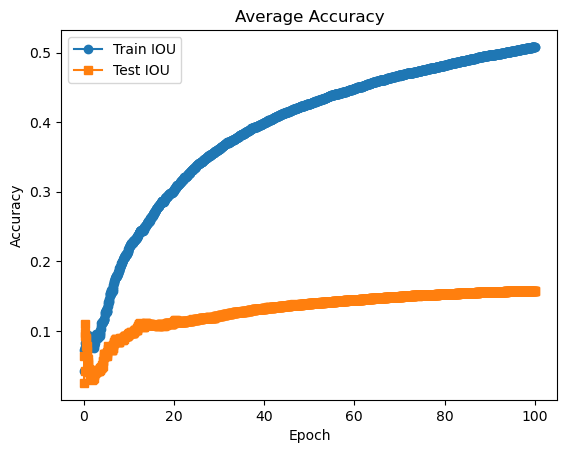

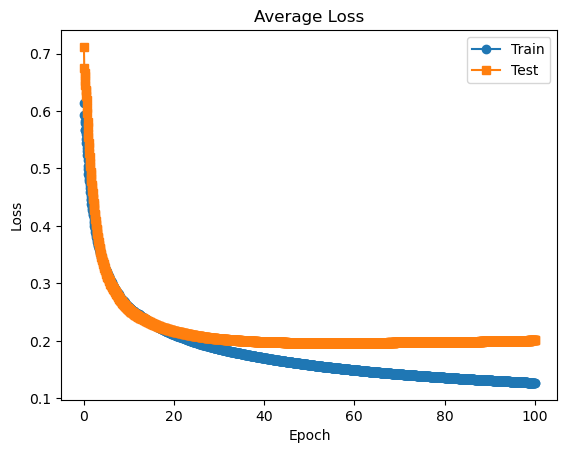

In [89]:
plt.plot(total_updater.train_epoch, total_updater.train_avr_acc, label='Train IOU', marker='o', linestyle='-')
plt.plot(total_updater.test_epoch, total_updater.test_avr_acc, label='Test IOU', marker='s', linestyle='-')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy')

plt.legend()
plt.show()


plt.plot(total_updater.train_epoch, total_updater.train_avr_loss, label='Train', marker='o', linestyle='-')
plt.plot(total_updater.test_epoch, total_updater.test_avr_loss, label='Test', marker='s', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss')

plt.legend()
plt.show()

Accuracy Scores

In [90]:
print('average sample test accuracy per epoch')
total_updater.test_avr_acc_epoch

average sample test accuracy per epoch


[0.05193533621800293,
 0.010381337485524196,
 0.0641750032565171,
 0.06659529943024996,
 0.12971710723061794,
 0.12248515193023615,
 0.16430979266070528,
 0.09388547807619621,
 0.11167601744059552,
 0.14571282056861,
 0.10935576410519558,
 0.19423072188021612,
 0.12438520838057526,
 0.15757890368956726,
 0.08424553493302135,
 0.11303226966192953,
 0.11180944420337889,
 0.09525694795046363,
 0.16562389884543335,
 0.14223187046690514,
 0.1201603721796292,
 0.09814713600508064,
 0.14289868037479733,
 0.16264139939572472,
 0.13185656216368896,
 0.13958493333174699,
 0.15326709538241667,
 0.13622517920826424,
 0.11245901950200585,
 0.17514123222736672,
 0.17543423988023837,
 0.1593596555904871,
 0.18797993552881784,
 0.16840337580135187,
 0.14354034956876144,
 0.14534815394703723,
 0.1801817100763989,
 0.18723131135687662,
 0.17063369990200433,
 0.14131775112471354,
 0.18564435799487394,
 0.14801661692762488,
 0.14214534777360743,
 0.19168752313647838,
 0.15311877429982085,
 0.1947481518214

In [91]:
#Calculate final IOU values 

final_test_batch_iterator = iter(testLoader)
batch_accuracies = []
tn_count = 0
fp_count = 0
fn_count = 0
tp_count = 0

while True:
    try:
        # model.eval()
        next_test_batch = next(final_test_batch_iterator)
        
        test_pixel_values = next_test_batch[0].float().to(device)
        test_labels = next_test_batch[1].to(device)
        test_outputs = model(pixel_values=test_pixel_values, labels=test_labels)
        test_upsampled_logits = nn.functional.interpolate(test_outputs.logits, size=test_labels.shape[-2:], mode="bilinear", align_corners=False)
        test_predicted = test_upsampled_logits.argmax(dim=1)
        test_mask = (test_labels != -1) # don't include the background class in the accuracy calculation
        test_pred_labels = test_predicted[test_mask].detach().cpu().numpy()
        test_true_labels = test_labels[test_mask].detach().cpu().numpy()
        intersection = np.logical_and(test_pred_labels, test_true_labels)
        union = np.logical_or(test_pred_labels, test_true_labels)
        test_accuracy = np.sum(intersection) / np.sum(union)
        # test_accuracy = accuracy_score(test_pred_labels, test_true_labels)
        batch_accuracies.append(test_accuracy)

        conf_matrix = confusion_matrix(test_pred_labels, test_true_labels)
        tn, fp, fn, tp = conf_matrix.ravel()
        tn_count += tn
        fp_count += fp
        fn_count += fn
        tp_count += tp



    except StopIteration:
        break

iou = tp_count/(tp_count+fp_count+fn_count)
iou0 = tn_count/(tn_count+fn_count+fp_count)

print(f'pixel-wise accuracy: {sum(batch_accuracies)/len(batch_accuracies)}')
print(f'TN: {tn_count}, FP: {fp_count}, FN: {fn_count}, TP: {tp_count}')
print(f'precision: {tp_count/(tp_count+fp_count)}')
print(f'recall: {tp_count/(tp_count+fn_count)}')
print(f'iou (1 class): {iou}')
print(f'iou (0 class): {iou0}')
print(f'miou: {0.5*(iou+iou0)}')

pixel-wise accuracy: 0.19076669542012126
TN: 52308, FP: 3039, FN: 884, TP: 1113
precision: 0.2680635838150289
recall: 0.557336004006009
iou (1 class): 0.2210087370929309
iou (0 class): 0.9302342124450925
miou: 0.5756214747690117


Hugging Face Upload

In [92]:
#model.save_pretrained("mit-b5-nodrone-mangrove-128-128") #save weights to folder

In [93]:
# model.save_model("./my_model")

# with open('auth_token.txt', 'r') as file:
#     auth_token = file.read().strip()

#model.save_model("jasonnyang/mit-b5-nodrone-mangrove-128-128")
torch.save(model.state_dict(), "satmodelWeights.pth")



In [94]:
#load the model

#model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load("satmodelWeights.pth"))
model.eval()

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(6, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

Inference

In [95]:
#Do inference on other images 

def predict(folder):
    with rasterio.open(folder + '/TC.tiff') as src:
        # Show the first TIFF while it's open
        tiff_data = src.read()
        show(src)
        # Print source shape while the file is open
        print("Source shape:", src.shape)
        # Open the second dataset and perform alignment inside the context manager of the first dataset
        with rasterio.open('DEM_30m.tif') as src2:
            ele_data = align_and_mask(src, src2)

    with rasterio.open(folder+'2.tiff') as src: #blue
        bimg = src.read()
    with rasterio.open(folder+'3.tiff') as src: #green
        gimg = src.read()
    with rasterio.open(folder+'4.tiff') as src: #red
        rimg = src.read()
    with rasterio.open(folder+'8.tiff') as src: #nearIR
        irimg = src.read()
    with rasterio.open(folder+'11.tiff') as src: #SWIR
        swirimg = src.read()

    #Vegetation Index
    ndvi = np.divide(irimg - rimg, irimg + rimg, where=(irimg + rimg != 0), dtype=np.float64)

    #Water Index
    ndwi = np.divide(gimg-irimg, gimg+irimg, where=(gimg+irimg != 0), dtype=np.float64)

    #Moisture Index
    mi = np.divide(irimg-swirimg, irimg+swirimg, where=(irimg+swirimg != 0), dtype=np.float64)

    #Custom Index
    rimg_squeezed = np.squeeze(rimg, axis=0)
    gimg_squeezed = np.squeeze(gimg, axis=0)
    bimg_squeezed = np.squeeze(bimg, axis=0)
    irimg_squeezed = np.squeeze(irimg, axis=0)
    ndvi_squeezed = np.squeeze(ndvi, axis=0)
    ndwi_squeezed = np.squeeze(ndwi, axis=0)
    mi_squeezed = np.squeeze(mi, axis=0)
    print(mi_squeezed.shape)
    print(ele_data[0].shape)
    full_img = np.stack((rimg_squeezed, gimg_squeezed, bimg_squeezed, irimg_squeezed, ndvi_squeezed, ndwi_squeezed, mi_squeezed, ele_data[0]), axis=0)
    full_img = np.expand_dims(full_img, axis=0)
    print(full_img.shape)
    full_img = torch.tensor(full_img, dtype=torch.float32).to(next(model.parameters()).device)
    # full_img = full_img.unsqueeze(0)  # Add batch dimension
    # print(full_img)
    model.eval()
    with torch.no_grad():
        test_outputs = model(pixel_values=full_img)
    upsampled_logits = nn.functional.interpolate(
        test_outputs.logits,
        size=full_img.shape[-2:],
        mode="bilinear",
        align_corners=False,
    )
    test_predicted = upsampled_logits.argmax(dim=1)
    print(test_predicted)

    print(upsampled_logits)
    print(upsampled_logits.shape)
    print(test_outputs)
    print(test_predicted.shape)
    test_predicted = test_predicted.cpu().numpy()
    show(np.squeeze(test_predicted))
    with rasterio.open(folder+'TC.tiff') as src:
        tiff_data = src.read()
        show(tiff_data)  # Optional: to visualize the TIFF data
    print(test_predicted.shape)


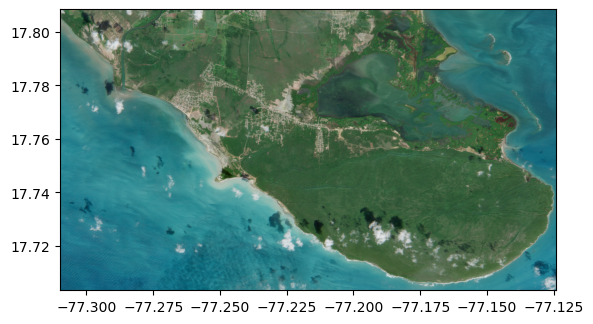

Source shape: (1231, 2068)
(1231, 2068)
(1231, 2068)
(1, 8, 1231, 2068)


RuntimeError: Given groups=1, weight of size [64, 6, 7, 7], expected input[1, 8, 1231, 2068] to have 6 channels, but got 8 channels instead

In [96]:
predict("images/")

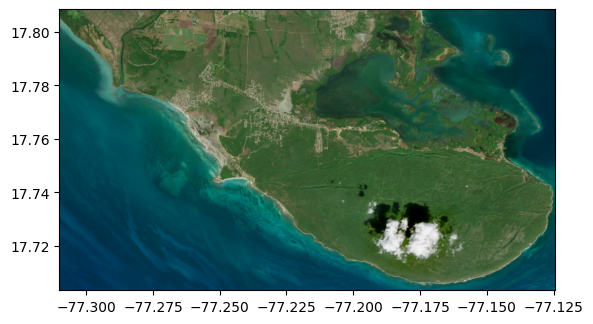

Source shape: (1231, 2068)


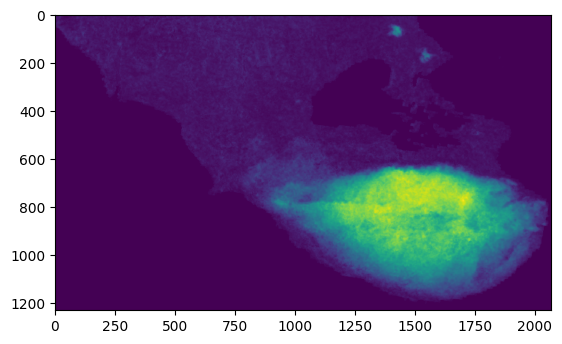

Concatenated shape: (1, 1231, 2068)
Source shape: (1231, 2068)
(1231, 2068)
(1231, 2068)
(1, 8, 1231, 2068)
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0')
tensor([[[[ 0.1995,  0.1995,  0.2062,  ...,  2.3879,  2.4270,  2.4270],
          [ 0.1995,  0.1995,  0.2062,  ...,  2.3879,  2.4270,  2.4270],
          [ 0.2587,  0.2587,  0.2640,  ...,  2.3641,  2.3998,  2.3998],
          ...,
          [ 3.3685,  3.3685,  3.3626,  ...,  2.3867,  2.4069,  2.4069],
          [ 3.3802,  3.3802,  3.3731,  ...,  2.4020,  2.4226,  2.4226],
          [ 3.3802,  3.3802,  3.3731,  ...,  2.4020,  2.4226,  2.4226]],

         [[-1.0081, -1.0081, -1.0139,  ..., -3.0495, -3.0876, -3.0876],
          [-1.0081, -1.0081, -1.0139,  ..., -3.0495, -3.0876, -3.0876],
          [-1.0382, -1.0382, -1.0406,  ..., -3.0270, -3.

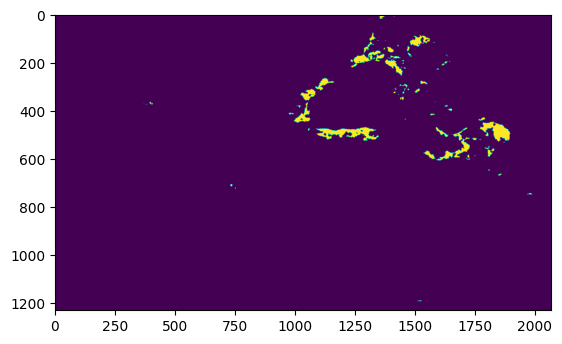

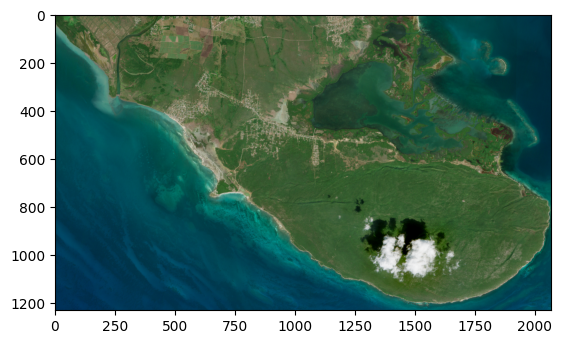

(1, 1231, 2068)


In [ ]:
predict("2019-image/")


In [ ]:
# from rasterio.transform import Affine

# # Define your georeferencing parameters
# # Example: top-left corner's longitude and latitude, pixel size in the units of the CRS (e.g., degrees or meters)
# top_left_x = -120.66029  # Longitude of the top-left corner
# top_left_y = 35.28275    # Latitude of the top-left corner
# x_pixel_size = 0.0001    # Size of one pixel in longitude degrees
# y_pixel_size = -0.0001   # Size of one pixel in latitude degrees (negative because pixel y values increase "downwards")

# # Create an Affine transformation. (column, row) -> (x, y)
# transform = Affine.translation(top_left_x, top_left_y) * Affine.scale(x_pixel_size, y_pixel_size)

# # Define the CRS
# crs = 'EPSG:4326'  # WGS84

# # Open the source TIFF file
# with rasterio.open('2019-image/TC.tiff', 'r') as src:
#     # Read the data
#     data = src.read()
    
#     # Define metadata for the new GeoTIFF
#     new_meta = src.meta.copy()
#     new_meta.update({
#         'driver': 'GTiff',  # GeoTIFF format
#         'height': data.shape[1],
#         'width': data.shape[2],
#         'transform': transform,
#         'crs': crs
#     })
    
#     # Write the data to a new GeoTIFF file with georeferencing
#     with rasterio.open('path_to_georeferenced_file.tif', 'w', **new_meta) as dst:
#         dst.write(data)

In [ ]:
#Convert mask into geotiff 

def numpy_mask_to_geotiff(numpy_mask, reference_tif_path, output_tif_path):
    # Ensure numpy_mask is 2D and has an appropriate dtype
    if numpy_mask.ndim != 2:
        numpy_mask = numpy_mask.squeeze()  # Remove extra dimensions
    numpy_mask = numpy_mask.astype('uint8')  # Convert to uint8 if not already

    with rasterio.open(reference_tif_path) as ref:
        meta = ref.meta.copy()
        meta.update({
            'height': numpy_mask.shape[0],
            'width': numpy_mask.shape[1],
            'count': 1,  # Single band
            'dtype': 'uint8',
            'nodata': 0  # Set a nodata value if applicable
        })

    with rasterio.open(output_tif_path, 'w', **meta) as dst:
        dst.write(numpy_mask, 1)  # Write numpy_mask as the first band


# Example usage
numpy_mask = test_predicted
reference_tif_path = '2019-image/TC.tiff'
output_tif_path = '2019-image/mask.tiff'

numpy_mask_to_geotiff(numpy_mask, reference_tif_path, output_tif_path)